In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import zipfile
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import cv2
import pandas as pd
import torchvision.transforms as transforms
from torchvision.models import AlexNet,resnet50
import torch.optim as optim

path_photo_train = 'train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png'
phote = Image.open(path_photo_train).convert('1')
nump_photo = np.array(phote)
print(nump_photo)



img1 = cv2.imread('train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png', cv2.IMREAD_UNCHANGED)
img3 = cv2.imread('train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png', cv2.IMREAD_UNCHANGED)

# Убедитесь, что все изображения имеют одинаковые размеры
width = min(img1.shape[1], img2.shape[1], img3.shape[1])
height = min(img1.shape[0], img2.shape[0], img3.shape[0])

img1 = cv2.resize(img1, (width, height))
img2 = cv2.resize(img2, (width, height))
img3 = cv2.resize(img3, (width, height))

# Задайте вес для каждого слоя (для альфа-смешивания)
alpha1 = 0.33
alpha2 = 0.33
alpha3 = 0.34  # Убедитесь, что сумма весов равна 1

# Смешиваем изображения
combined_image = cv2.addWeighted(img1, alpha1, img2, alpha2, 0)
combined_image = cv2.addWeighted(combined_image, 1, img3, alpha3, 0)
print(combined_image)
# combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)

In [2]:
import sys
print(sys.executable)
import torch
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\Артём\AppData\Local\Programs\Python\Python311\python.exe
False
cpu


In [3]:
df = pd.read_csv('filtered_classes.csv')
# id_belkov = []
# for c in df['Id']:
#     id_belkov.append(c+'_yellow')
#     id_belkov.append(c+'_red')
#     id_belkov.append(c+'_green')
#     id_belkov.append(c+'_blue')
# id_belkov = [f"{c}_{color}" for c in df['Id'] for color in ['yellow', 'red', 'green', 'blue']] # либо можно сделать так
# ider = id_belkov[:60]
# print(id_belkov[:50])

In [4]:
class CustomDataSet(Dataset):
    def __init__(self,id_belkov,label,transform = None):
        self.id_belkov = id_belkov
        self.transform = transform
        self.label = label
        


    def __len__(self):
        return len(self.id_belkov)
    
    def __getitem__(self,idx):
        img_name = self.id_belkov[idx]
        spisok = ['_blue', '_green', '_red', '_yellow']
        rgb_images = []
                # Итерация по списку цветов
        for number, c in enumerate(spisok):
            imger = Image.open(f'train/{img_name}{c}.png')
            imger = imger.convert('L')
            gray_image = np.array(imger)
                    
                    # Создаем новый массив с 3 слоями
            rgb_image = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)
                    # Заполнение каналов RGB
            rgb_image[..., 0] = gray_image * (number == 2 or number == 3)  # Красный (2 и 3)
            rgb_image[..., 1] = gray_image * (number == 1 or number == 3)  # Зеленый (1 и 3)
            rgb_image[..., 2] = gray_image * (number == 0)  # Синий (0)
            rgb_images.append(gray_image)
            
        combined_rgb_images = np.concatenate(rgb_images, axis=1)
        
        rgb_images[1] = np.maximum(rgb_images[1], rgb_images[3])
        rgb_images[0] = np.maximum(rgb_images[0], rgb_images[3])
        # Объединяем слои в одну RGB-картину
        combined_image = np.stack((rgb_images[2], rgb_images[1], rgb_images[0]), axis=-1) # 1: red 2: green 3: blue

        
        if self.transform:
            combined_image = self.transform(combined_image)  # Применяем преобразования

        result = [0] * 10
        for i in map(int, self.label[idx].split()):
            result[i - 1] = 1
        
        return combined_image,torch.tensor(result)

In [5]:
# class CustomDataSet(Dataset):
#     def __init__(self,id_belkov,label,transform = None):
#         self.id_belkov = id_belkov
#         self.transform = transform
#         self.label = label
        


#     def __len__(self):
#         return len(self.id_belkov)
    
#     def __getitem__(self,idx):
#         img_name = self.id_belkov[idx]
        
#         img1 = cv2.imread(f'train/{img_name}_yellow.png', cv2.IMREAD_UNCHANGED)
#         img2 = cv2.imread(f'train/{img_name}_red.png', cv2.IMREAD_UNCHANGED)
#         img3 = cv2.imread(f'train/{img_name}_green.png', cv2.IMREAD_UNCHANGED)
#         img4 = cv2.imread(f'train/{img_name}_blue.png', cv2.IMREAD_UNCHANGED)  # Добавьте четвертое изображение
        
#         # Убедитесь, что все изображения имеют одинаковые размеры
#         width = min(img1.shape[1], img2.shape[1], img3.shape[1], img4.shape[1])
#         height = min(img1.shape[0], img2.shape[0], img3.shape[0], img4.shape[0])
        
#         img1 = cv2.resize(img1, (width, height))
#         img2 = cv2.resize(img2, (width, height))
#         img3 = cv2.resize(img3, (width, height))
#         img4 = cv2.resize(img4, (width, height))
        
#         # Задайте вес для каждого слоя (для альфа-смешивания)
#         alpha1 = 0.25
#         alpha2 = 0.25
#         alpha3 = 0.25
#         alpha4 = 0.25  # Убедитесь, что сумма весов равна 1
        
#         # Смешиваем изображения
#         combined_image = cv2.addWeighted(img1, alpha1, img2, alpha2, 0)
#         combined_image = cv2.addWeighted(combined_image, 1, img3, alpha3, 0)
#         combined_image = cv2.addWeighted(combined_image, 1, img4, alpha4, 0)

#         if self.transform:
#             combined_image = self.transform(combined_image)  # Применяем преобразования

#         result = [0] * 28
#         for i in map(int, self.label[idx].split()):
#             result[i - 1] = 1
        
#         return combined_image,torch.tensor(result)

In [6]:
# # print(df['Target'].head(10).values)
# heq = CustomDataSet(df['Id'].head(10).values,df['Target'].head(10).values)

# for name,label in heq:
#     plt.imshow(name)
#     plt.title(str(label))
#     print(label)
#     plt.show()

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Конвертирует изображение в PIL формат (можно использовать после cv2)
    transforms.Grayscale(num_output_channels=3),  # Конвертация в 3-канальный RGB формат
    transforms.Resize((224, 224)),  # ResNet ожидает вход размером 224x224
    transforms.ToTensor(),  # Конвертируем в тензор
])

tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])


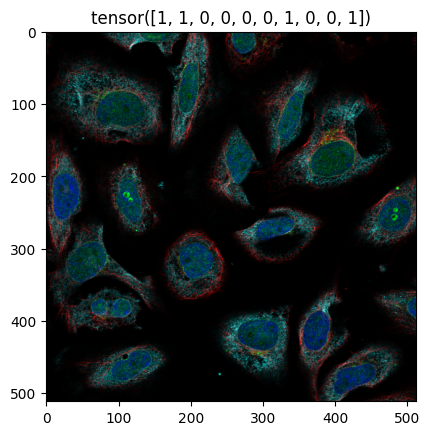

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


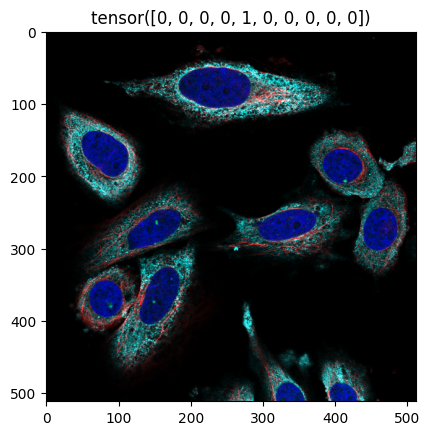

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


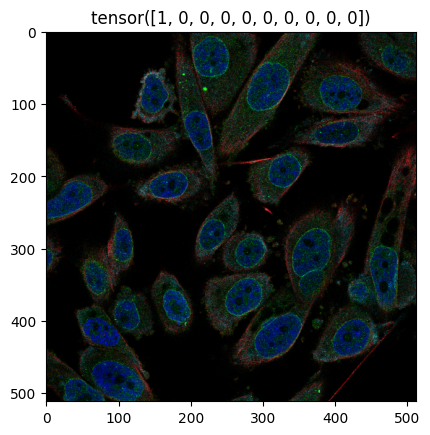

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


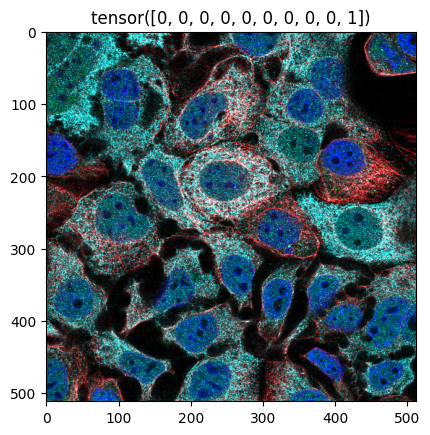

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


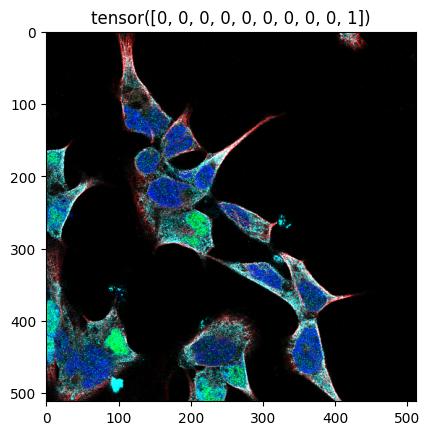

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])


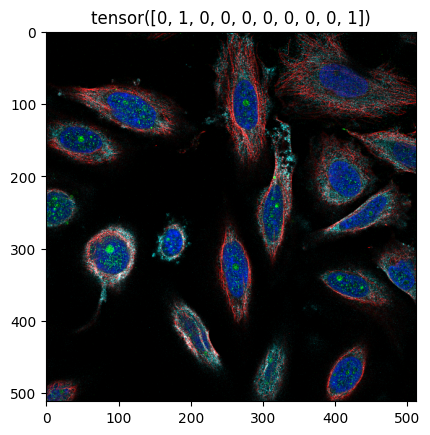

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


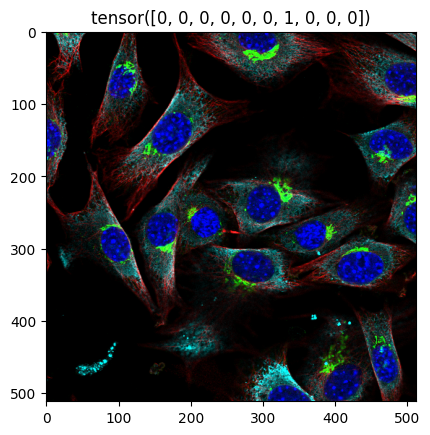

tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0])


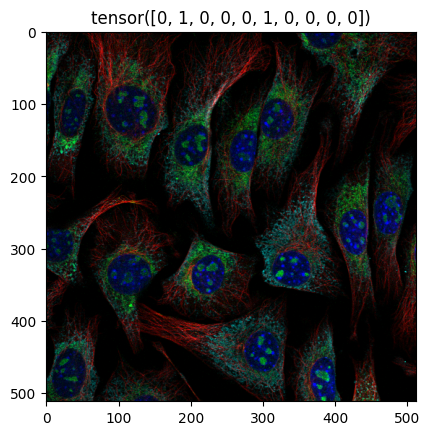

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


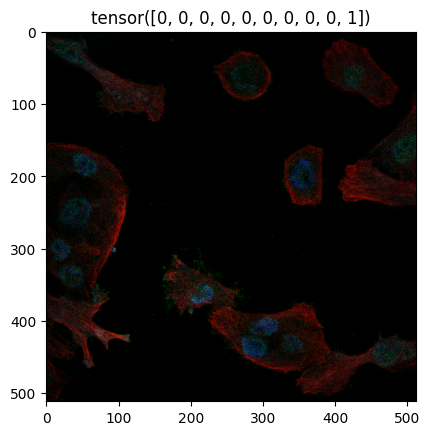

tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])


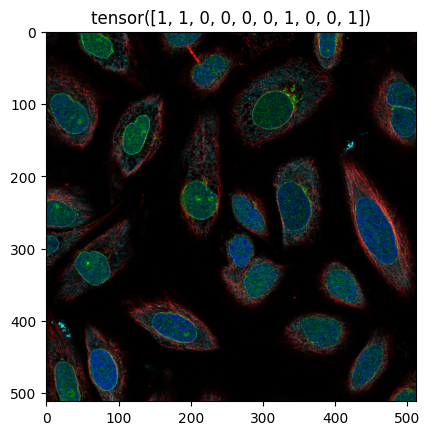

In [8]:
# print(df['Target'].head(10).values)
heq = CustomDataSet(df['Id'].head(10).values,df['Target'].head(10).values)

for name,label in heq:
    plt.imshow(name)
    plt.title(str(label))
    print(label)
    plt.show()

In [9]:
dataset = CustomDataSet(df['Id'].values,df['Target'].values,transform=transform)
train_loader = DataLoader(dataset, batch_size=28, shuffle=True)

In [1]:
model = AlexNet()

model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10) 
# for c in model.parameters():
#     print(c)


NameError: name 'AlexNet' is not defined

In [11]:
import torch.nn.functional as F
def FocalLoss(output, target, gamma=2.0, alpha=None):
    """
    Focal Loss для многометочного задания.
    
    Args:
    output: Тензор предсказаний модели (со значениями логитов), shape (batch_size, num_classes)
    target: Тензор истинных меток (двоичная маска), shape (batch_size, num_classes)
    gamma: Параметр фокуса (насколько фокализировать потери)
    alpha: Дополнительный коэффициент для контроля веса классов (необязательно)
    
    Returns:
    Средняя потеря по батчу
    """
    # Проверка на совпадение размеров
    if not (target.size() == output.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})"
                         .format(target.size(), output.size()))

    # Применим сигмоид для получения вероятностей
    probs = torch.sigmoid(output)
    
    # Если alpha не задан, мы используем одинаковые веса
    if alpha is not None:
        alpha = alpha.to(output.device)
        weights = target * alpha + (1 - target) * (1 - alpha)  # Веса для классов
    else:
        weights = None
    
    # Фокусируемся на "вероятностях", которые далеко от 1
    focal_weight = (1 - probs) ** gamma
    
    # Вычисляем потерю
    bce_loss = F.binary_cross_entropy(probs, target, weight=weights, reduction='none')
    loss = focal_weight * bce_loss
    
    return loss.sum(dim=1).mean()  # Средняя потеря по всем примерам в батче

In [12]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-10, alpha=0.4, eps=1e-8, weight_decay=0)

In [25]:
from tqdm import tqdm
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_classes = 0  # Общее количество классов везде, где есть метки
    
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Здесь мы будем считать точность
        # Предположим, что outputs - это логиты, и нужно применить softmax
    
        # print(outputs)
        total_correct += (torch.sigmoid(outputs) == labels).sum().item()  # Подсчитываем правильные предсказания
        total_classes += labels.size(0)  # Подсчитываем общее количество классов
        
        print(f'Loss: {running_loss / (batch_idx + 1)}', end='\r')

    # Вычисляем точность после каждого эпа
        accuracy = total_correct / total_classes
        print(f'\nEpoch {epoch + 1} - Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}')


Epoch 1:   0%|▏                                                                        | 1/420 [00:04<30:23,  4.35s/it]

Loss: 0.6912190914154053
Epoch 1 - Loss: 0.0016, Accuracy: 0.0000


Epoch 1:   0%|▎                                                                        | 2/420 [00:09<31:42,  4.55s/it]

Loss: 0.6910664439201355
Epoch 1 - Loss: 0.0033, Accuracy: 0.0000


Epoch 1:   1%|▌                                                                        | 3/420 [00:13<31:15,  4.50s/it]

Loss: 0.6910143693288168
Epoch 1 - Loss: 0.0049, Accuracy: 0.0000


Epoch 1:   1%|▋                                                                        | 4/420 [00:18<31:46,  4.58s/it]

Loss: 0.6910533905029297
Epoch 1 - Loss: 0.0066, Accuracy: 0.0000


Epoch 1:   1%|▊                                                                        | 5/420 [00:22<31:34,  4.56s/it]

Loss: 0.6911138296127319
Epoch 1 - Loss: 0.0082, Accuracy: 0.0000


Epoch 1:   1%|█                                                                        | 6/420 [00:27<31:32,  4.57s/it]

Loss: 0.6911094387372335
Epoch 1 - Loss: 0.0099, Accuracy: 0.0000


Epoch 1:   2%|█▏                                                                       | 7/420 [00:31<30:48,  4.48s/it]

Loss: 0.6911060128893171
Epoch 1 - Loss: 0.0115, Accuracy: 0.0000


Epoch 1:   2%|█▍                                                                       | 8/420 [00:36<30:43,  4.48s/it]

Loss: 0.691055066883564
Epoch 1 - Loss: 0.0132, Accuracy: 0.0000


Epoch 1:   2%|█▌                                                                       | 9/420 [00:40<30:29,  4.45s/it]

Loss: 0.6910557614432441
Epoch 1 - Loss: 0.0148, Accuracy: 0.0000


Epoch 1:   2%|█▋                                                                      | 10/420 [00:44<30:14,  4.43s/it]

Loss: 0.6910465002059937
Epoch 1 - Loss: 0.0165, Accuracy: 0.0000


Epoch 1:   3%|█▉                                                                      | 11/420 [00:49<29:43,  4.36s/it]

Loss: 0.6910479393872347
Epoch 1 - Loss: 0.0181, Accuracy: 0.0000


Epoch 1:   3%|██                                                                      | 12/420 [00:53<29:26,  4.33s/it]

Loss: 0.6910363684097925
Epoch 1 - Loss: 0.0197, Accuracy: 0.0000


Epoch 1:   3%|██▏                                                                     | 13/420 [00:58<30:20,  4.47s/it]

Loss: 0.6910307820026691
Epoch 1 - Loss: 0.0214, Accuracy: 0.0000


Epoch 1:   3%|██▍                                                                     | 14/420 [01:02<30:32,  4.51s/it]

Loss: 0.6910485412393298
Epoch 1 - Loss: 0.0230, Accuracy: 0.0000


Epoch 1:   4%|██▌                                                                     | 15/420 [01:07<30:30,  4.52s/it]

Loss: 0.6910751581192016
Epoch 1 - Loss: 0.0247, Accuracy: 0.0000


Epoch 1:   4%|██▋                                                                     | 16/420 [01:11<30:46,  4.57s/it]

Loss: 0.6910748779773712
Epoch 1 - Loss: 0.0263, Accuracy: 0.0000


Epoch 1:   4%|██▉                                                                     | 17/420 [01:16<30:15,  4.50s/it]

Loss: 0.691085562986486
Epoch 1 - Loss: 0.0280, Accuracy: 0.0000


Epoch 1:   4%|███                                                                     | 18/420 [01:20<29:52,  4.46s/it]

Loss: 0.6910969780551063
Epoch 1 - Loss: 0.0296, Accuracy: 0.0000


Epoch 1:   5%|███▎                                                                    | 19/420 [01:25<30:17,  4.53s/it]

Loss: 0.691091377484171
Epoch 1 - Loss: 0.0313, Accuracy: 0.0000


Epoch 1:   5%|███▍                                                                    | 20/420 [01:30<31:10,  4.68s/it]

Loss: 0.691111621260643
Epoch 1 - Loss: 0.0329, Accuracy: 0.0000


Epoch 1:   5%|███▌                                                                    | 21/420 [01:34<30:48,  4.63s/it]

Loss: 0.6911002056939262
Epoch 1 - Loss: 0.0346, Accuracy: 0.0000


Epoch 1:   5%|███▊                                                                    | 22/420 [01:39<30:52,  4.65s/it]

Loss: 0.6911053088578311
Epoch 1 - Loss: 0.0362, Accuracy: 0.0000


Epoch 1:   5%|███▉                                                                    | 23/420 [01:44<31:12,  4.72s/it]

Loss: 0.6911145085873811
Epoch 1 - Loss: 0.0378, Accuracy: 0.0000


Epoch 1:   6%|████                                                                    | 24/420 [01:49<31:20,  4.75s/it]

Loss: 0.6911112243930498
Epoch 1 - Loss: 0.0395, Accuracy: 0.0000


Epoch 1:   6%|████▎                                                                   | 25/420 [01:53<31:05,  4.72s/it]

Loss: 0.6911094832420349
Epoch 1 - Loss: 0.0411, Accuracy: 0.0000


Epoch 1:   6%|████▍                                                                   | 26/420 [01:58<31:01,  4.73s/it]

Loss: 0.6911056729463431
Epoch 1 - Loss: 0.0428, Accuracy: 0.0000


Epoch 1:   6%|████▋                                                                   | 27/420 [02:03<30:34,  4.67s/it]

Loss: 0.691104080941942
Epoch 1 - Loss: 0.0444, Accuracy: 0.0000


Epoch 1:   7%|████▊                                                                   | 28/420 [02:08<30:46,  4.71s/it]

Loss: 0.6911167353391647
Epoch 1 - Loss: 0.0461, Accuracy: 0.0000


Epoch 1:   7%|████▉                                                                   | 29/420 [02:12<30:26,  4.67s/it]

Loss: 0.6911193522913702
Epoch 1 - Loss: 0.0477, Accuracy: 0.0000


Epoch 1:   7%|█████▏                                                                  | 30/420 [02:17<30:00,  4.62s/it]

Loss: 0.69112349152565
Epoch 1 - Loss: 0.0494, Accuracy: 0.0000


Epoch 1:   7%|█████▎                                                                  | 31/420 [02:21<30:02,  4.63s/it]

Loss: 0.691118513384173
Epoch 1 - Loss: 0.0510, Accuracy: 0.0000


Epoch 1:   8%|█████▍                                                                  | 32/420 [02:26<30:10,  4.67s/it]

Loss: 0.691115528345108
Epoch 1 - Loss: 0.0527, Accuracy: 0.0000


Epoch 1:   8%|█████▋                                                                  | 33/420 [02:31<29:53,  4.63s/it]

Loss: 0.6911215402863242
Epoch 1 - Loss: 0.0543, Accuracy: 0.0000


Epoch 1:   8%|█████▊                                                                  | 34/420 [02:35<29:55,  4.65s/it]

Loss: 0.6911214414764854
Epoch 1 - Loss: 0.0559, Accuracy: 0.0000


Epoch 1:   8%|██████                                                                  | 35/420 [02:40<29:11,  4.55s/it]

Loss: 0.691119887147631
Epoch 1 - Loss: 0.0576, Accuracy: 0.0000


Epoch 1:   9%|██████▏                                                                 | 36/420 [02:44<29:38,  4.63s/it]

Loss: 0.6911128179894553
Epoch 1 - Loss: 0.0592, Accuracy: 0.0000


Epoch 1:   9%|██████▎                                                                 | 37/420 [02:49<29:34,  4.63s/it]

Loss: 0.6911214090682365
Epoch 1 - Loss: 0.0609, Accuracy: 0.0000


Epoch 1:   9%|██████▌                                                                 | 38/420 [02:54<29:28,  4.63s/it]

Loss: 0.6911244847272572
Epoch 1 - Loss: 0.0625, Accuracy: 0.0000


Epoch 1:   9%|██████▋                                                                 | 39/420 [02:58<29:31,  4.65s/it]

Loss: 0.6911277770996094
Epoch 1 - Loss: 0.0642, Accuracy: 0.0000


Epoch 1:  10%|██████▊                                                                 | 40/420 [03:03<29:10,  4.61s/it]

Loss: 0.6911285668611526
Epoch 1 - Loss: 0.0658, Accuracy: 0.0000


Epoch 1:  10%|███████                                                                 | 41/420 [03:07<29:02,  4.60s/it]

Loss: 0.691127714587421
Epoch 1 - Loss: 0.0675, Accuracy: 0.0000


Epoch 1:  10%|███████▏                                                                | 42/420 [03:12<28:54,  4.59s/it]

Loss: 0.6911221047242483
Epoch 1 - Loss: 0.0691, Accuracy: 0.0000


Epoch 1:  10%|███████▎                                                                | 43/420 [03:17<29:00,  4.62s/it]

Loss: 0.6911283066106397
Epoch 1 - Loss: 0.0708, Accuracy: 0.0000


Epoch 1:  10%|███████▌                                                                | 44/420 [03:21<29:08,  4.65s/it]

Loss: 0.6911271891810677
Epoch 1 - Loss: 0.0724, Accuracy: 0.0000


Epoch 1:  11%|███████▋                                                                | 45/420 [03:26<29:30,  4.72s/it]

Loss: 0.6911267836888632
Epoch 1 - Loss: 0.0740, Accuracy: 0.0000


Epoch 1:  11%|███████▉                                                                | 46/420 [03:31<29:18,  4.70s/it]

Loss: 0.6911283407522284
Epoch 1 - Loss: 0.0757, Accuracy: 0.0000


Epoch 1:  11%|████████                                                                | 47/420 [03:36<29:01,  4.67s/it]

Loss: 0.6911252749727127
Epoch 1 - Loss: 0.0773, Accuracy: 0.0000


Epoch 1:  11%|████████▏                                                               | 48/420 [03:40<28:59,  4.68s/it]

Loss: 0.6911290362477303
Epoch 1 - Loss: 0.0790, Accuracy: 0.0000


Epoch 1:  12%|████████▍                                                               | 49/420 [03:45<29:13,  4.73s/it]

Loss: 0.6911234247441195
Epoch 1 - Loss: 0.0806, Accuracy: 0.0000


Epoch 1:  12%|████████▌                                                               | 50/420 [03:50<29:10,  4.73s/it]

Loss: 0.6911265754699707
Epoch 1 - Loss: 0.0823, Accuracy: 0.0000


Epoch 1:  12%|████████▋                                                               | 51/420 [03:54<28:50,  4.69s/it]

Loss: 0.6911244041779462
Epoch 1 - Loss: 0.0839, Accuracy: 0.0000


Epoch 1:  12%|████████▉                                                               | 52/420 [03:59<28:19,  4.62s/it]

Loss: 0.6911264153627249
Epoch 1 - Loss: 0.0856, Accuracy: 0.0000


Epoch 1:  13%|█████████                                                               | 53/420 [04:04<28:23,  4.64s/it]

Loss: 0.6911215073657486
Epoch 1 - Loss: 0.0872, Accuracy: 0.0000


Epoch 1:  13%|█████████▎                                                              | 54/420 [04:08<28:26,  4.66s/it]

Loss: 0.691122465663486
Epoch 1 - Loss: 0.0889, Accuracy: 0.0000


Epoch 1:  13%|█████████▍                                                              | 55/420 [04:13<28:32,  4.69s/it]

Loss: 0.691121139309623
Epoch 1 - Loss: 0.0905, Accuracy: 0.0000


Epoch 1:  13%|█████████▌                                                              | 56/420 [04:18<28:34,  4.71s/it]

Loss: 0.691125710095678
Epoch 1 - Loss: 0.0922, Accuracy: 0.0000


Epoch 1:  14%|█████████▊                                                              | 57/420 [04:22<28:19,  4.68s/it]

Loss: 0.6911267251299139
Epoch 1 - Loss: 0.0938, Accuracy: 0.0000


Epoch 1:  14%|█████████▉                                                              | 58/420 [04:27<28:06,  4.66s/it]

Loss: 0.6911251627165695
Epoch 1 - Loss: 0.0954, Accuracy: 0.0000


Epoch 1:  14%|██████████                                                              | 59/420 [04:32<28:20,  4.71s/it]

Loss: 0.6911293207588842
Epoch 1 - Loss: 0.0971, Accuracy: 0.0000


Epoch 1:  14%|██████████▎                                                             | 60/420 [04:36<27:44,  4.62s/it]

Loss: 0.6911284327507019
Epoch 1 - Loss: 0.0987, Accuracy: 0.0000


Epoch 1:  15%|██████████▍                                                             | 61/420 [04:41<27:58,  4.68s/it]

Loss: 0.6911293659053865
Epoch 1 - Loss: 0.1004, Accuracy: 0.0000


Epoch 1:  15%|██████████▋                                                             | 62/420 [04:46<27:45,  4.65s/it]

Loss: 0.6911278463179066
Epoch 1 - Loss: 0.1020, Accuracy: 0.0000


Epoch 1:  15%|██████████▊                                                             | 63/420 [04:50<27:48,  4.67s/it]

Loss: 0.6911276219383119
Epoch 1 - Loss: 0.1037, Accuracy: 0.0000


Epoch 1:  15%|██████████▉                                                             | 64/420 [04:55<27:54,  4.70s/it]

Loss: 0.6911271419376135
Epoch 1 - Loss: 0.1053, Accuracy: 0.0000


Epoch 1:  15%|███████████▏                                                            | 65/420 [05:00<27:55,  4.72s/it]

Loss: 0.6911218670698313
Epoch 1 - Loss: 0.1070, Accuracy: 0.0000


Epoch 1:  16%|███████████▎                                                            | 66/420 [05:05<27:58,  4.74s/it]

Loss: 0.6911215592514385
Epoch 1 - Loss: 0.1086, Accuracy: 0.0000


Epoch 1:  16%|███████████▍                                                            | 67/420 [05:09<27:49,  4.73s/it]

Loss: 0.6911186940634428
Epoch 1 - Loss: 0.1102, Accuracy: 0.0000


Epoch 1:  16%|███████████▋                                                            | 68/420 [05:14<27:18,  4.65s/it]

Loss: 0.6911176881369423
Epoch 1 - Loss: 0.1119, Accuracy: 0.0000


Epoch 1:  16%|███████████▊                                                            | 69/420 [05:18<27:01,  4.62s/it]

Loss: 0.6911174240319625
Epoch 1 - Loss: 0.1135, Accuracy: 0.0000


Epoch 1:  17%|████████████                                                            | 70/420 [05:23<27:10,  4.66s/it]

Loss: 0.6911162146500178
Epoch 1 - Loss: 0.1152, Accuracy: 0.0000


Epoch 1:  17%|████████████▏                                                           | 71/420 [05:28<26:37,  4.58s/it]

Loss: 0.6911125879892162
Epoch 1 - Loss: 0.1168, Accuracy: 0.0000


Epoch 1:  17%|████████████▎                                                           | 72/420 [05:32<27:02,  4.66s/it]

Loss: 0.6911103866166539
Epoch 1 - Loss: 0.1185, Accuracy: 0.0000


Epoch 1:  17%|████████████▌                                                           | 73/420 [05:37<26:59,  4.67s/it]

Loss: 0.6911140116926742
Epoch 1 - Loss: 0.1201, Accuracy: 0.0000


Epoch 1:  18%|████████████▋                                                           | 74/420 [05:42<27:03,  4.69s/it]

Loss: 0.69111272853774
Epoch 1 - Loss: 0.1218, Accuracy: 0.0000


Epoch 1:  18%|████████████▊                                                           | 75/420 [05:46<26:56,  4.68s/it]

Loss: 0.6911131874720255
Epoch 1 - Loss: 0.1234, Accuracy: 0.0000


Epoch 1:  18%|█████████████                                                           | 76/420 [05:51<26:32,  4.63s/it]

Loss: 0.6911148389703349
Epoch 1 - Loss: 0.1251, Accuracy: 0.0000


Epoch 1:  18%|█████████████▏                                                          | 77/420 [05:56<26:50,  4.70s/it]

Loss: 0.6911118525963325
Epoch 1 - Loss: 0.1267, Accuracy: 0.0000


Epoch 1:  19%|█████████████▎                                                          | 78/420 [06:01<26:55,  4.72s/it]

Loss: 0.6911127582574502
Epoch 1 - Loss: 0.1283, Accuracy: 0.0000


Epoch 1:  19%|█████████████▌                                                          | 79/420 [06:05<26:30,  4.66s/it]

Loss: 0.6911116476300396
Epoch 1 - Loss: 0.1300, Accuracy: 0.0000


Epoch 1:  19%|█████████████▋                                                          | 80/420 [06:10<26:44,  4.72s/it]

Loss: 0.6911151856184006
Epoch 1 - Loss: 0.1316, Accuracy: 0.0000


Epoch 1:  19%|█████████████▉                                                          | 81/420 [06:15<26:47,  4.74s/it]

Loss: 0.6911154955993464
Epoch 1 - Loss: 0.1333, Accuracy: 0.0000


Epoch 1:  20%|██████████████                                                          | 82/420 [06:19<26:37,  4.73s/it]

Loss: 0.6911165256325792
Epoch 1 - Loss: 0.1349, Accuracy: 0.0000


Epoch 1:  20%|██████████████▏                                                         | 83/420 [06:24<26:09,  4.66s/it]

Loss: 0.6911180134279182
Epoch 1 - Loss: 0.1366, Accuracy: 0.0000


Epoch 1:  20%|██████████████▍                                                         | 84/420 [06:29<26:14,  4.69s/it]

Loss: 0.6911184539397558
Epoch 1 - Loss: 0.1382, Accuracy: 0.0000


Epoch 1:  20%|██████████████▌                                                         | 85/420 [06:33<26:05,  4.67s/it]

Loss: 0.691120562132667
Epoch 1 - Loss: 0.1399, Accuracy: 0.0000


Epoch 1:  20%|██████████████▋                                                         | 86/420 [06:38<26:10,  4.70s/it]

Loss: 0.6911222553530405
Epoch 1 - Loss: 0.1415, Accuracy: 0.0000


Epoch 1:  21%|██████████████▉                                                         | 87/420 [06:43<26:05,  4.70s/it]

Loss: 0.6911230217451336
Epoch 1 - Loss: 0.1432, Accuracy: 0.0000


Epoch 1:  21%|███████████████                                                         | 88/420 [06:48<26:08,  4.72s/it]

Loss: 0.6911247982220217
Epoch 1 - Loss: 0.1448, Accuracy: 0.0000


Epoch 1:  21%|███████████████▎                                                        | 89/420 [06:52<26:03,  4.72s/it]

Loss: 0.6911269848266345
Epoch 1 - Loss: 0.1465, Accuracy: 0.0000


Epoch 1:  21%|███████████████▍                                                        | 90/420 [06:57<25:55,  4.71s/it]

Loss: 0.6911248366038004
Epoch 1 - Loss: 0.1481, Accuracy: 0.0000


Epoch 1:  22%|███████████████▌                                                        | 91/420 [07:02<26:01,  4.75s/it]

Loss: 0.6911225803605803
Epoch 1 - Loss: 0.1497, Accuracy: 0.0000


Epoch 1:  22%|███████████████▊                                                        | 92/420 [07:06<25:40,  4.70s/it]

Loss: 0.6911207288503647
Epoch 1 - Loss: 0.1514, Accuracy: 0.0000


Epoch 1:  22%|███████████████▉                                                        | 93/420 [07:11<25:46,  4.73s/it]

Loss: 0.6911228049185968
Epoch 1 - Loss: 0.1530, Accuracy: 0.0000


Epoch 1:  22%|████████████████                                                        | 94/420 [07:16<25:02,  4.61s/it]

Loss: 0.6911233010444235
Epoch 1 - Loss: 0.1547, Accuracy: 0.0000


Epoch 1:  23%|████████████████▎                                                       | 95/420 [07:20<25:09,  4.65s/it]

Loss: 0.6911219007090519
Epoch 1 - Loss: 0.1563, Accuracy: 0.0000


Epoch 1:  23%|████████████████▍                                                       | 96/420 [07:25<25:18,  4.69s/it]

Loss: 0.6911211417367061
Epoch 1 - Loss: 0.1580, Accuracy: 0.0000


Epoch 1:  23%|████████████████▋                                                       | 97/420 [07:30<25:28,  4.73s/it]

Loss: 0.6911222258793939
Epoch 1 - Loss: 0.1596, Accuracy: 0.0000


Epoch 1:  23%|████████████████▊                                                       | 98/420 [07:35<25:22,  4.73s/it]

Loss: 0.691121157942986
Epoch 1 - Loss: 0.1613, Accuracy: 0.0000


Epoch 1:  24%|████████████████▉                                                       | 99/420 [07:39<25:16,  4.72s/it]

Loss: 0.6911215396842572
Epoch 1 - Loss: 0.1629, Accuracy: 0.0000


Epoch 1:  24%|████████████████▉                                                      | 100/420 [07:44<25:25,  4.77s/it]

Loss: 0.6911207032203674
Epoch 1 - Loss: 0.1646, Accuracy: 0.0000


Epoch 1:  24%|█████████████████                                                      | 101/420 [07:49<25:09,  4.73s/it]

Loss: 0.6911166965371311
Epoch 1 - Loss: 0.1662, Accuracy: 0.0000


Epoch 1:  24%|█████████████████▏                                                     | 102/420 [07:53<24:45,  4.67s/it]

Loss: 0.691116155946956
Epoch 1 - Loss: 0.1678, Accuracy: 0.0000


Epoch 1:  25%|█████████████████▍                                                     | 103/420 [07:58<24:42,  4.68s/it]

Loss: 0.6911170864568174
Epoch 1 - Loss: 0.1695, Accuracy: 0.0000


Epoch 1:  25%|█████████████████▌                                                     | 104/420 [08:03<24:22,  4.63s/it]

Loss: 0.691116153047635
Epoch 1 - Loss: 0.1711, Accuracy: 0.0000


Epoch 1:  25%|█████████████████▊                                                     | 105/420 [08:07<24:40,  4.70s/it]

Loss: 0.6911175381569635
Epoch 1 - Loss: 0.1728, Accuracy: 0.0000


Epoch 1:  25%|█████████████████▉                                                     | 106/420 [08:12<24:55,  4.76s/it]

Loss: 0.6911179001601238
Epoch 1 - Loss: 0.1744, Accuracy: 0.0000


Epoch 1:  25%|██████████████████                                                     | 107/420 [08:17<25:03,  4.80s/it]

Loss: 0.6911186598171698
Epoch 1 - Loss: 0.1761, Accuracy: 0.0000


Epoch 1:  26%|██████████████████▎                                                    | 108/420 [08:22<25:09,  4.84s/it]

Loss: 0.6911217967669169
Epoch 1 - Loss: 0.1777, Accuracy: 0.0000


Epoch 1:  26%|██████████████████▍                                                    | 109/420 [08:27<25:01,  4.83s/it]

Loss: 0.6911206059499618
Epoch 1 - Loss: 0.1794, Accuracy: 0.0000


Epoch 1:  26%|██████████████████▌                                                    | 110/420 [08:32<24:55,  4.82s/it]

Loss: 0.6911227377978238
Epoch 1 - Loss: 0.1810, Accuracy: 0.0000


Epoch 1:  26%|██████████████████▊                                                    | 111/420 [08:37<24:37,  4.78s/it]

Loss: 0.691121722663845
Epoch 1 - Loss: 0.1827, Accuracy: 0.0000


Epoch 1:  27%|██████████████████▉                                                    | 112/420 [08:41<24:40,  4.81s/it]

Loss: 0.6911196378724915
Epoch 1 - Loss: 0.1843, Accuracy: 0.0000


Epoch 1:  27%|███████████████████                                                    | 113/420 [08:46<24:39,  4.82s/it]

Loss: 0.6911213308309032
Epoch 1 - Loss: 0.1859, Accuracy: 0.0000


Epoch 1:  27%|███████████████████▎                                                   | 114/420 [08:51<24:48,  4.86s/it]

Loss: 0.691122490585896
Epoch 1 - Loss: 0.1876, Accuracy: 0.0000


Epoch 1:  27%|███████████████████▍                                                   | 115/420 [08:56<24:13,  4.77s/it]

Loss: 0.6911228174748628
Epoch 1 - Loss: 0.1892, Accuracy: 0.0000


Epoch 1:  28%|███████████████████▌                                                   | 116/420 [09:01<24:19,  4.80s/it]

Loss: 0.6911245409784645
Epoch 1 - Loss: 0.1909, Accuracy: 0.0000


Epoch 1:  28%|███████████████████▊                                                   | 117/420 [09:05<24:09,  4.79s/it]

Loss: 0.6911223423786652
Epoch 1 - Loss: 0.1925, Accuracy: 0.0000


Epoch 1:  28%|███████████████████▉                                                   | 118/420 [09:10<23:58,  4.76s/it]

Loss: 0.6911206725290266
Epoch 1 - Loss: 0.1942, Accuracy: 0.0000


Epoch 1:  28%|████████████████████                                                   | 119/420 [09:15<23:50,  4.75s/it]

Loss: 0.6911228905204966
Epoch 1 - Loss: 0.1958, Accuracy: 0.0000


Epoch 1:  29%|████████████████████▎                                                  | 120/420 [09:20<23:46,  4.76s/it]

Loss: 0.6911225959658622
Epoch 1 - Loss: 0.1975, Accuracy: 0.0000


Epoch 1:  29%|████████████████████▍                                                  | 121/420 [09:24<23:37,  4.74s/it]

Loss: 0.6911210304449412
Epoch 1 - Loss: 0.1991, Accuracy: 0.0000


Epoch 1:  29%|████████████████████▌                                                  | 122/420 [09:29<23:43,  4.78s/it]

Loss: 0.6911201105743158
Epoch 1 - Loss: 0.2008, Accuracy: 0.0000


Epoch 1:  29%|████████████████████▊                                                  | 123/420 [09:34<23:32,  4.76s/it]

Loss: 0.6911178517147778
Epoch 1 - Loss: 0.2024, Accuracy: 0.0000


Epoch 1:  30%|████████████████████▉                                                  | 124/420 [09:39<23:26,  4.75s/it]

Loss: 0.6911180677913851
Epoch 1 - Loss: 0.2040, Accuracy: 0.0000


Epoch 1:  30%|█████████████████████▏                                                 | 125/420 [09:43<23:32,  4.79s/it]

Loss: 0.6911182761192322
Epoch 1 - Loss: 0.2057, Accuracy: 0.0000


Epoch 1:  30%|█████████████████████▎                                                 | 126/420 [09:48<23:18,  4.76s/it]

Loss: 0.6911146593472314
Epoch 1 - Loss: 0.2073, Accuracy: 0.0000


Epoch 1:  30%|█████████████████████▍                                                 | 127/420 [09:53<23:14,  4.76s/it]

Loss: 0.6911142665570177
Epoch 1 - Loss: 0.2090, Accuracy: 0.0000


Epoch 1:  30%|█████████████████████▋                                                 | 128/420 [09:58<23:00,  4.73s/it]

Loss: 0.6911111185327172
Epoch 1 - Loss: 0.2106, Accuracy: 0.0000


Epoch 1:  31%|█████████████████████▊                                                 | 129/420 [10:02<23:05,  4.76s/it]

Loss: 0.6911125640536464
Epoch 1 - Loss: 0.2123, Accuracy: 0.0000


Epoch 1:  31%|█████████████████████▉                                                 | 130/420 [10:07<23:04,  4.77s/it]

Loss: 0.6911125100575961
Epoch 1 - Loss: 0.2139, Accuracy: 0.0000


Epoch 1:  31%|██████████████████████▏                                                | 131/420 [10:12<23:23,  4.86s/it]

Loss: 0.6911128522785566
Epoch 1 - Loss: 0.2156, Accuracy: 0.0000


Epoch 1:  31%|██████████████████████▎                                                | 132/420 [10:17<23:08,  4.82s/it]

Loss: 0.6911123688473846
Epoch 1 - Loss: 0.2172, Accuracy: 0.0000


Epoch 1:  32%|██████████████████████▍                                                | 133/420 [10:22<23:02,  4.82s/it]

Loss: 0.6911119563238961
Epoch 1 - Loss: 0.2189, Accuracy: 0.0000


Epoch 1:  32%|██████████████████████▋                                                | 134/420 [10:27<22:56,  4.81s/it]

Loss: 0.6911127184753987
Epoch 1 - Loss: 0.2205, Accuracy: 0.0000


Epoch 1:  32%|██████████████████████▊                                                | 135/420 [10:32<23:12,  4.89s/it]

Loss: 0.6911125324390552
Epoch 1 - Loss: 0.2221, Accuracy: 0.0000


Epoch 1:  32%|██████████████████████▉                                                | 136/420 [10:37<23:26,  4.95s/it]

Loss: 0.6911118920235073
Epoch 1 - Loss: 0.2238, Accuracy: 0.0000


Epoch 1:  33%|███████████████████████▏                                               | 137/420 [10:42<23:10,  4.91s/it]

Loss: 0.6911132165985386
Epoch 1 - Loss: 0.2254, Accuracy: 0.0000


Epoch 1:  33%|███████████████████████▎                                               | 138/420 [10:46<23:06,  4.92s/it]

Loss: 0.6911110126453898
Epoch 1 - Loss: 0.2271, Accuracy: 0.0000


Epoch 1:  33%|███████████████████████▍                                               | 139/420 [10:51<22:40,  4.84s/it]

Loss: 0.6911105796587553
Epoch 1 - Loss: 0.2287, Accuracy: 0.0000


Epoch 1:  33%|███████████████████████▋                                               | 140/420 [10:56<22:31,  4.83s/it]

Loss: 0.6911112840686525
Epoch 1 - Loss: 0.2304, Accuracy: 0.0000


Epoch 1:  34%|███████████████████████▊                                               | 141/420 [11:01<22:38,  4.87s/it]

Loss: 0.6911124451786068
Epoch 1 - Loss: 0.2320, Accuracy: 0.0000


Epoch 1:  34%|████████████████████████                                               | 142/420 [11:06<22:25,  4.84s/it]

Loss: 0.6911104724440776
Epoch 1 - Loss: 0.2337, Accuracy: 0.0000


Epoch 1:  34%|████████████████████████▏                                              | 143/420 [11:11<22:32,  4.88s/it]

Loss: 0.6911100620156402
Epoch 1 - Loss: 0.2353, Accuracy: 0.0000


Epoch 1:  34%|████████████████████████▎                                              | 144/420 [11:16<22:27,  4.88s/it]

Loss: 0.6911102707187334
Epoch 1 - Loss: 0.2370, Accuracy: 0.0000


Epoch 1:  35%|████████████████████████▌                                              | 145/420 [11:20<22:16,  4.86s/it]

Loss: 0.6911086481193016
Epoch 1 - Loss: 0.2386, Accuracy: 0.0000


Epoch 1:  35%|████████████████████████▋                                              | 146/420 [11:25<22:10,  4.85s/it]

Loss: 0.6911095352205512
Epoch 1 - Loss: 0.2402, Accuracy: 0.0000


Epoch 1:  35%|████████████████████████▊                                              | 147/420 [11:30<22:30,  4.95s/it]

Loss: 0.6911097927158382
Epoch 1 - Loss: 0.2419, Accuracy: 0.0000


Epoch 1:  35%|█████████████████████████                                              | 148/420 [11:35<22:23,  4.94s/it]

Loss: 0.6911105167221379
Epoch 1 - Loss: 0.2435, Accuracy: 0.0000


Epoch 1:  35%|█████████████████████████▏                                             | 149/420 [11:40<22:25,  4.96s/it]

Loss: 0.691111279013973
Epoch 1 - Loss: 0.2452, Accuracy: 0.0000


Epoch 1:  36%|█████████████████████████▎                                             | 150/420 [11:45<22:21,  4.97s/it]

Loss: 0.6911095448335012
Epoch 1 - Loss: 0.2468, Accuracy: 0.0000


Epoch 1:  36%|█████████████████████████▌                                             | 151/420 [11:50<21:50,  4.87s/it]

Loss: 0.6911107578024959
Epoch 1 - Loss: 0.2485, Accuracy: 0.0000


Epoch 1:  36%|█████████████████████████▋                                             | 152/420 [11:55<21:26,  4.80s/it]

Loss: 0.6911090059499991
Epoch 1 - Loss: 0.2501, Accuracy: 0.0000


Epoch 1:  36%|█████████████████████████▊                                             | 153/420 [11:59<21:11,  4.76s/it]

Loss: 0.6911080043300305
Epoch 1 - Loss: 0.2518, Accuracy: 0.0000


Epoch 1:  37%|██████████████████████████                                             | 154/420 [12:04<21:12,  4.79s/it]

Loss: 0.69110708538588
Epoch 1 - Loss: 0.2534, Accuracy: 0.0000


Epoch 1:  37%|██████████████████████████▏                                            | 155/420 [12:09<21:05,  4.78s/it]

Loss: 0.6911074515311949
Epoch 1 - Loss: 0.2551, Accuracy: 0.0000


Epoch 1:  37%|██████████████████████████▎                                            | 156/420 [12:14<21:14,  4.83s/it]

Loss: 0.6911058429724131
Epoch 1 - Loss: 0.2567, Accuracy: 0.0000


Epoch 1:  37%|██████████████████████████▌                                            | 157/420 [12:19<21:18,  4.86s/it]

Loss: 0.6911086151554326
Epoch 1 - Loss: 0.2583, Accuracy: 0.0000


Epoch 1:  38%|██████████████████████████▋                                            | 158/420 [12:24<21:18,  4.88s/it]

Loss: 0.6911074824725525
Epoch 1 - Loss: 0.2600, Accuracy: 0.0000


Epoch 1:  38%|██████████████████████████▉                                            | 159/420 [12:29<21:15,  4.89s/it]

Loss: 0.6911073173367003
Epoch 1 - Loss: 0.2616, Accuracy: 0.0000


Epoch 1:  38%|███████████████████████████                                            | 160/420 [12:33<21:09,  4.88s/it]

Loss: 0.6911049894988537
Epoch 1 - Loss: 0.2633, Accuracy: 0.0000


Epoch 1:  38%|███████████████████████████▏                                           | 161/420 [12:38<21:08,  4.90s/it]

Loss: 0.6911051873094547
Epoch 1 - Loss: 0.2649, Accuracy: 0.0000


Epoch 1:  39%|███████████████████████████▍                                           | 162/420 [12:43<21:02,  4.89s/it]

Loss: 0.6911058135238695
Epoch 1 - Loss: 0.2666, Accuracy: 0.0000


Epoch 1:  39%|███████████████████████████▌                                           | 163/420 [12:48<20:51,  4.87s/it]

Loss: 0.6911071480417544
Epoch 1 - Loss: 0.2682, Accuracy: 0.0000


Epoch 1:  39%|███████████████████████████▋                                           | 164/420 [12:53<20:50,  4.88s/it]

Loss: 0.6911070859286843
Epoch 1 - Loss: 0.2699, Accuracy: 0.0000


Epoch 1:  39%|███████████████████████████▉                                           | 165/420 [12:58<20:51,  4.91s/it]

Loss: 0.6911065925251354
Epoch 1 - Loss: 0.2715, Accuracy: 0.0000


Epoch 1:  40%|████████████████████████████                                           | 166/420 [13:03<20:48,  4.91s/it]

Loss: 0.6911088425710977
Epoch 1 - Loss: 0.2732, Accuracy: 0.0000


Epoch 1:  40%|████████████████████████████▏                                          | 167/420 [13:08<21:05,  5.00s/it]

Loss: 0.691109184733408
Epoch 1 - Loss: 0.2748, Accuracy: 0.0000


Epoch 1:  40%|████████████████████████████▍                                          | 168/420 [13:13<21:17,  5.07s/it]

Loss: 0.6911112286505245
Epoch 1 - Loss: 0.2764, Accuracy: 0.0000


Epoch 1:  40%|████████████████████████████▌                                          | 169/420 [13:18<21:10,  5.06s/it]

Loss: 0.6911108102318804
Epoch 1 - Loss: 0.2781, Accuracy: 0.0000


Epoch 1:  40%|████████████████████████████▋                                          | 170/420 [13:23<21:01,  5.05s/it]

Loss: 0.6911109927822562
Epoch 1 - Loss: 0.2797, Accuracy: 0.0000


Epoch 1:  41%|████████████████████████████▉                                          | 171/420 [13:28<20:39,  4.98s/it]

Loss: 0.6911114984088473
Epoch 1 - Loss: 0.2814, Accuracy: 0.0000


Epoch 1:  41%|█████████████████████████████                                          | 172/420 [13:33<20:47,  5.03s/it]

Loss: 0.69111112383909
Epoch 1 - Loss: 0.2830, Accuracy: 0.0000


Epoch 1:  41%|█████████████████████████████▏                                         | 173/420 [13:38<20:39,  5.02s/it]

Loss: 0.691111848533498
Epoch 1 - Loss: 0.2847, Accuracy: 0.0000


Epoch 1:  41%|█████████████████████████████▍                                         | 174/420 [13:43<20:36,  5.03s/it]

Loss: 0.6911107997099558
Epoch 1 - Loss: 0.2863, Accuracy: 0.0000


Epoch 1:  42%|█████████████████████████████▌                                         | 175/420 [13:48<20:18,  4.97s/it]

Loss: 0.6911109290804182
Epoch 1 - Loss: 0.2880, Accuracy: 0.0000


Epoch 1:  42%|█████████████████████████████▊                                         | 176/420 [13:53<20:24,  5.02s/it]

Loss: 0.691112178970467
Epoch 1 - Loss: 0.2896, Accuracy: 0.0000


Epoch 1:  42%|█████████████████████████████▉                                         | 177/420 [13:58<20:28,  5.06s/it]

Loss: 0.6911134507696507
Epoch 1 - Loss: 0.2913, Accuracy: 0.0000


Epoch 1:  42%|██████████████████████████████                                         | 178/420 [14:04<20:30,  5.08s/it]

Loss: 0.6911142903767274
Epoch 1 - Loss: 0.2929, Accuracy: 0.0000


Epoch 1:  43%|██████████████████████████████▎                                        | 179/420 [14:09<20:26,  5.09s/it]

Loss: 0.6911149997284959
Epoch 1 - Loss: 0.2945, Accuracy: 0.0000


Epoch 1:  43%|██████████████████████████████▍                                        | 180/420 [14:14<20:15,  5.06s/it]

Loss: 0.6911158988873164
Epoch 1 - Loss: 0.2962, Accuracy: 0.0000


Epoch 1:  43%|██████████████████████████████▌                                        | 181/420 [14:19<20:15,  5.09s/it]

Loss: 0.6911151257667753
Epoch 1 - Loss: 0.2978, Accuracy: 0.0000


Epoch 1:  43%|██████████████████████████████▊                                        | 182/420 [14:24<19:49,  5.00s/it]

Loss: 0.691113089794641
Epoch 1 - Loss: 0.2995, Accuracy: 0.0000


Epoch 1:  44%|██████████████████████████████▉                                        | 183/420 [14:29<19:50,  5.02s/it]

Loss: 0.6911133029421822
Epoch 1 - Loss: 0.3011, Accuracy: 0.0000


Epoch 1:  44%|███████████████████████████████                                        | 184/420 [14:34<19:39,  5.00s/it]

Loss: 0.6911122092734212
Epoch 1 - Loss: 0.3028, Accuracy: 0.0000


Epoch 1:  44%|███████████████████████████████▎                                       | 185/420 [14:39<19:23,  4.95s/it]

Loss: 0.6911136305009996
Epoch 1 - Loss: 0.3044, Accuracy: 0.0000


Epoch 1:  44%|███████████████████████████████▍                                       | 186/420 [14:44<19:23,  4.97s/it]

Loss: 0.691113482880336
Epoch 1 - Loss: 0.3061, Accuracy: 0.0000


Epoch 1:  45%|███████████████████████████████▌                                       | 187/420 [14:49<19:24,  5.00s/it]

Loss: 0.6911134809096229
Epoch 1 - Loss: 0.3077, Accuracy: 0.0000


Epoch 1:  45%|███████████████████████████████▊                                       | 188/420 [14:54<19:29,  5.04s/it]

Loss: 0.6911142091167733
Epoch 1 - Loss: 0.3094, Accuracy: 0.0000


Epoch 1:  45%|███████████████████████████████▉                                       | 189/420 [14:59<19:27,  5.05s/it]

Loss: 0.6911166613064115
Epoch 1 - Loss: 0.3110, Accuracy: 0.0000


Epoch 1:  45%|████████████████████████████████                                       | 190/420 [15:04<19:13,  5.02s/it]

Loss: 0.6911152271847976
Epoch 1 - Loss: 0.3126, Accuracy: 0.0000


Epoch 1:  45%|████████████████████████████████▎                                      | 191/420 [15:09<19:23,  5.08s/it]

Loss: 0.6911154233348307
Epoch 1 - Loss: 0.3143, Accuracy: 0.0000


Epoch 1:  46%|████████████████████████████████▍                                      | 192/420 [15:14<19:20,  5.09s/it]

Loss: 0.6911158583437403
Epoch 1 - Loss: 0.3159, Accuracy: 0.0000


Epoch 1:  46%|████████████████████████████████▋                                      | 193/420 [15:19<19:07,  5.05s/it]

Loss: 0.6911169213334514
Epoch 1 - Loss: 0.3176, Accuracy: 0.0000


Epoch 1:  46%|████████████████████████████████▊                                      | 194/420 [15:24<19:17,  5.12s/it]

Loss: 0.6911152509069934
Epoch 1 - Loss: 0.3192, Accuracy: 0.0000


Epoch 1:  46%|████████████████████████████████▉                                      | 195/420 [15:29<19:10,  5.11s/it]

Loss: 0.6911155972725306
Epoch 1 - Loss: 0.3209, Accuracy: 0.0000


Epoch 1:  47%|█████████████████████████████████▏                                     | 196/420 [15:35<19:05,  5.11s/it]

Loss: 0.6911150612393204
Epoch 1 - Loss: 0.3225, Accuracy: 0.0000


Epoch 1:  47%|█████████████████████████████████▎                                     | 197/420 [15:40<19:07,  5.15s/it]

Loss: 0.6911178545903434
Epoch 1 - Loss: 0.3242, Accuracy: 0.0000


Epoch 1:  47%|█████████████████████████████████▍                                     | 198/420 [15:45<19:05,  5.16s/it]

Loss: 0.6911172607932428
Epoch 1 - Loss: 0.3258, Accuracy: 0.0000


Epoch 1:  47%|█████████████████████████████████▋                                     | 199/420 [15:50<18:59,  5.16s/it]

Loss: 0.6911176056718108
Epoch 1 - Loss: 0.3275, Accuracy: 0.0000


Epoch 1:  48%|█████████████████████████████████▊                                     | 200/420 [15:55<18:41,  5.10s/it]

Loss: 0.691117652952671
Epoch 1 - Loss: 0.3291, Accuracy: 0.0000


Epoch 1:  48%|█████████████████████████████████▉                                     | 201/420 [16:00<18:37,  5.10s/it]

Loss: 0.6911179399608973
Epoch 1 - Loss: 0.3307, Accuracy: 0.0000


Epoch 1:  48%|██████████████████████████████████▏                                    | 202/420 [16:05<18:37,  5.13s/it]

Loss: 0.6911184938237218
Epoch 1 - Loss: 0.3324, Accuracy: 0.0000


Epoch 1:  48%|██████████████████████████████████▎                                    | 203/420 [16:11<18:35,  5.14s/it]

Loss: 0.6911183495826909
Epoch 1 - Loss: 0.3340, Accuracy: 0.0000


Epoch 1:  49%|██████████████████████████████████▍                                    | 204/420 [16:16<18:23,  5.11s/it]

Loss: 0.6911178581854877
Epoch 1 - Loss: 0.3357, Accuracy: 0.0000


Epoch 1:  49%|██████████████████████████████████▋                                    | 205/420 [16:21<18:23,  5.13s/it]

Loss: 0.6911169933109749
Epoch 1 - Loss: 0.3373, Accuracy: 0.0000


Epoch 1:  49%|██████████████████████████████████▊                                    | 206/420 [16:26<18:16,  5.12s/it]

Loss: 0.691117101213307
Epoch 1 - Loss: 0.3390, Accuracy: 0.0000


Epoch 1:  49%|██████████████████████████████████▉                                    | 207/420 [16:31<18:10,  5.12s/it]

Loss: 0.6911177787803797
Epoch 1 - Loss: 0.3406, Accuracy: 0.0000


Epoch 1:  50%|███████████████████████████████████▏                                   | 208/420 [16:36<18:07,  5.13s/it]

Loss: 0.6911170150224979
Epoch 1 - Loss: 0.3423, Accuracy: 0.0000


Epoch 1:  50%|███████████████████████████████████▎                                   | 209/420 [16:41<18:08,  5.16s/it]

Loss: 0.6911179497481533
Epoch 1 - Loss: 0.3439, Accuracy: 0.0000


Epoch 1:  50%|███████████████████████████████████▌                                   | 210/420 [16:47<18:06,  5.17s/it]

Loss: 0.6911181251207987
Epoch 1 - Loss: 0.3456, Accuracy: 0.0000


Epoch 1:  50%|███████████████████████████████████▋                                   | 211/420 [16:52<17:51,  5.13s/it]

Loss: 0.6911179219941957
Epoch 1 - Loss: 0.3472, Accuracy: 0.0000


Epoch 1:  50%|███████████████████████████████████▊                                   | 212/420 [16:57<17:50,  5.15s/it]

Loss: 0.691118172598335
Epoch 1 - Loss: 0.3489, Accuracy: 0.0000


Epoch 1:  51%|████████████████████████████████████                                   | 213/420 [17:02<17:45,  5.15s/it]

Loss: 0.6911184323225783
Epoch 1 - Loss: 0.3505, Accuracy: 0.0000


Epoch 1:  51%|████████████████████████████████████▏                                  | 214/420 [17:07<17:46,  5.18s/it]

Loss: 0.691118580994205
Epoch 1 - Loss: 0.3521, Accuracy: 0.0000


Epoch 1:  51%|████████████████████████████████████▎                                  | 215/420 [17:13<17:51,  5.23s/it]

Loss: 0.6911197213239448
Epoch 1 - Loss: 0.3538, Accuracy: 0.0000


Epoch 1:  51%|████████████████████████████████████▌                                  | 216/420 [17:17<17:26,  5.13s/it]

Loss: 0.6911195894634282
Epoch 1 - Loss: 0.3554, Accuracy: 0.0000


Epoch 1:  52%|████████████████████████████████████▋                                  | 217/420 [17:23<17:33,  5.19s/it]

Loss: 0.691120884934878
Epoch 1 - Loss: 0.3571, Accuracy: 0.0000


Epoch 1:  52%|████████████████████████████████████▊                                  | 218/420 [17:28<17:17,  5.14s/it]

Loss: 0.6911220020110455
Epoch 1 - Loss: 0.3587, Accuracy: 0.0000


Epoch 1:  52%|█████████████████████████████████████                                  | 219/420 [17:33<17:22,  5.19s/it]

Loss: 0.6911224314611252
Epoch 1 - Loss: 0.3604, Accuracy: 0.0000


Epoch 1:  52%|█████████████████████████████████████▏                                 | 220/420 [17:38<17:19,  5.20s/it]

Loss: 0.6911226798187603
Epoch 1 - Loss: 0.3620, Accuracy: 0.0000


Epoch 1:  53%|█████████████████████████████████████▎                                 | 221/420 [17:44<17:17,  5.21s/it]

Loss: 0.6911230308437779
Epoch 1 - Loss: 0.3637, Accuracy: 0.0000


Epoch 1:  53%|█████████████████████████████████████▌                                 | 222/420 [17:49<17:04,  5.17s/it]

Loss: 0.6911234334782437
Epoch 1 - Loss: 0.3653, Accuracy: 0.0000


Epoch 1:  53%|█████████████████████████████████████▋                                 | 223/420 [17:54<17:04,  5.20s/it]

Loss: 0.691122837932655
Epoch 1 - Loss: 0.3670, Accuracy: 0.0000


Epoch 1:  53%|█████████████████████████████████████▊                                 | 224/420 [17:59<17:09,  5.25s/it]

Loss: 0.6911228448152542
Epoch 1 - Loss: 0.3686, Accuracy: 0.0000


Epoch 1:  54%|██████████████████████████████████████                                 | 225/420 [18:04<17:00,  5.23s/it]

Loss: 0.6911219159762064
Epoch 1 - Loss: 0.3702, Accuracy: 0.0000


Epoch 1:  54%|██████████████████████████████████████▏                                | 226/420 [18:10<16:50,  5.21s/it]

Loss: 0.6911236891704323
Epoch 1 - Loss: 0.3719, Accuracy: 0.0000


Epoch 1:  54%|██████████████████████████████████████▎                                | 227/420 [18:15<16:41,  5.19s/it]

Loss: 0.6911232657894689
Epoch 1 - Loss: 0.3735, Accuracy: 0.0000


Epoch 1:  54%|██████████████████████████████████████▌                                | 228/420 [18:20<16:36,  5.19s/it]

Loss: 0.6911243255201139
Epoch 1 - Loss: 0.3752, Accuracy: 0.0000


Epoch 1:  55%|██████████████████████████████████████▋                                | 229/420 [18:25<16:33,  5.20s/it]

Loss: 0.6911242622475436
Epoch 1 - Loss: 0.3768, Accuracy: 0.0000


Epoch 1:  55%|██████████████████████████████████████▉                                | 230/420 [18:30<16:27,  5.20s/it]

Loss: 0.6911239706951638
Epoch 1 - Loss: 0.3785, Accuracy: 0.0000


Epoch 1:  55%|███████████████████████████████████████                                | 231/420 [18:36<16:27,  5.23s/it]

Loss: 0.6911236512196528
Epoch 1 - Loss: 0.3801, Accuracy: 0.0000


Epoch 1:  55%|███████████████████████████████████████▏                               | 232/420 [18:41<16:26,  5.25s/it]

Loss: 0.6911236854462788
Epoch 1 - Loss: 0.3818, Accuracy: 0.0000


Epoch 1:  55%|███████████████████████████████████████▍                               | 233/420 [18:46<16:18,  5.23s/it]

Loss: 0.691123767727946
Epoch 1 - Loss: 0.3834, Accuracy: 0.0000


Epoch 1:  56%|███████████████████████████████████████▌                               | 234/420 [18:51<16:14,  5.24s/it]

Loss: 0.6911233880071559
Epoch 1 - Loss: 0.3851, Accuracy: 0.0000


Epoch 1:  56%|███████████████████████████████████████▋                               | 235/420 [18:57<16:04,  5.21s/it]

Loss: 0.6911228461468474
Epoch 1 - Loss: 0.3867, Accuracy: 0.0000


Epoch 1:  56%|███████████████████████████████████████▉                               | 236/420 [19:02<15:53,  5.18s/it]

Loss: 0.6911230885376365
Epoch 1 - Loss: 0.3883, Accuracy: 0.0000


Epoch 1:  56%|████████████████████████████████████████                               | 237/420 [19:07<15:50,  5.19s/it]

Loss: 0.6911237282592033
Epoch 1 - Loss: 0.3900, Accuracy: 0.0000


Epoch 1:  57%|████████████████████████████████████████▏                              | 238/420 [19:12<15:53,  5.24s/it]

Loss: 0.6911226986836987
Epoch 1 - Loss: 0.3916, Accuracy: 0.0000


Epoch 1:  57%|████████████████████████████████████████▍                              | 239/420 [19:17<15:37,  5.18s/it]

Loss: 0.6911223498348412
Epoch 1 - Loss: 0.3933, Accuracy: 0.0000


Epoch 1:  57%|████████████████████████████████████████▌                              | 240/420 [19:22<15:34,  5.19s/it]

Loss: 0.6911221978565057
Epoch 1 - Loss: 0.3949, Accuracy: 0.0000


Epoch 1:  57%|████████████████████████████████████████▋                              | 241/420 [19:28<15:27,  5.18s/it]

Loss: 0.6911226147437985
Epoch 1 - Loss: 0.3966, Accuracy: 0.0000


Epoch 1:  58%|████████████████████████████████████████▉                              | 242/420 [19:33<15:22,  5.18s/it]

Loss: 0.6911226131699302
Epoch 1 - Loss: 0.3982, Accuracy: 0.0000


Epoch 1:  58%|█████████████████████████████████████████                              | 243/420 [19:38<15:18,  5.19s/it]

Loss: 0.6911236248879766
Epoch 1 - Loss: 0.3999, Accuracy: 0.0000


Epoch 1:  58%|█████████████████████████████████████████▏                             | 244/420 [19:43<15:16,  5.21s/it]

Loss: 0.6911236641348385
Epoch 1 - Loss: 0.4015, Accuracy: 0.0000


Epoch 1:  58%|█████████████████████████████████████████▍                             | 245/420 [19:49<15:17,  5.24s/it]

Loss: 0.6911239548605316
Epoch 1 - Loss: 0.4032, Accuracy: 0.0000


Epoch 1:  59%|█████████████████████████████████████████▌                             | 246/420 [19:54<15:18,  5.28s/it]

Loss: 0.6911249165612507
Epoch 1 - Loss: 0.4048, Accuracy: 0.0000


Epoch 1:  59%|█████████████████████████████████████████▊                             | 247/420 [19:59<15:06,  5.24s/it]

Loss: 0.6911263432097339
Epoch 1 - Loss: 0.4064, Accuracy: 0.0000


Epoch 1:  59%|█████████████████████████████████████████▉                             | 248/420 [20:04<14:57,  5.22s/it]

Loss: 0.6911265876504683
Epoch 1 - Loss: 0.4081, Accuracy: 0.0000


Epoch 1:  59%|██████████████████████████████████████████                             | 249/420 [20:10<14:52,  5.22s/it]

Loss: 0.6911269751897299
Epoch 1 - Loss: 0.4097, Accuracy: 0.0000


Epoch 1:  60%|██████████████████████████████████████████▎                            | 250/420 [20:15<14:59,  5.29s/it]

Loss: 0.6911266872882843
Epoch 1 - Loss: 0.4114, Accuracy: 0.0000


Epoch 1:  60%|██████████████████████████████████████████▍                            | 251/420 [20:20<14:51,  5.27s/it]

Loss: 0.6911257405680015
Epoch 1 - Loss: 0.4130, Accuracy: 0.0000


Epoch 1:  60%|██████████████████████████████████████████▌                            | 252/420 [20:25<14:40,  5.24s/it]

Loss: 0.6911252318393617
Epoch 1 - Loss: 0.4147, Accuracy: 0.0000


Epoch 1:  60%|██████████████████████████████████████████▊                            | 253/420 [20:31<14:31,  5.22s/it]

Loss: 0.6911248029927491
Epoch 1 - Loss: 0.4163, Accuracy: 0.0000


Epoch 1:  60%|██████████████████████████████████████████▉                            | 254/420 [20:36<14:26,  5.22s/it]

Loss: 0.6911254025350405
Epoch 1 - Loss: 0.4180, Accuracy: 0.0000


Epoch 1:  61%|███████████████████████████████████████████                            | 255/420 [20:41<14:17,  5.20s/it]

Loss: 0.6911246820992114
Epoch 1 - Loss: 0.4196, Accuracy: 0.0000


Epoch 1:  61%|███████████████████████████████████████████▎                           | 256/420 [20:46<14:11,  5.19s/it]

Loss: 0.6911240667104721
Epoch 1 - Loss: 0.4213, Accuracy: 0.0000


Epoch 1:  61%|███████████████████████████████████████████▍                           | 257/420 [20:51<14:03,  5.18s/it]

Loss: 0.691123695457028
Epoch 1 - Loss: 0.4229, Accuracy: 0.0000


Epoch 1:  61%|███████████████████████████████████████████▌                           | 258/420 [20:56<13:59,  5.18s/it]

Loss: 0.6911228423894837
Epoch 1 - Loss: 0.4245, Accuracy: 0.0000


Epoch 1:  62%|███████████████████████████████████████████▊                           | 259/420 [21:02<13:52,  5.17s/it]

Loss: 0.6911214824809071
Epoch 1 - Loss: 0.4262, Accuracy: 0.0000


Epoch 1:  62%|███████████████████████████████████████████▉                           | 260/420 [21:07<13:56,  5.23s/it]

Loss: 0.6911214317266757
Epoch 1 - Loss: 0.4278, Accuracy: 0.0000


Epoch 1:  62%|████████████████████████████████████████████                           | 261/420 [21:12<13:52,  5.24s/it]

Loss: 0.6911227481575305
Epoch 1 - Loss: 0.4295, Accuracy: 0.0000


Epoch 1:  62%|████████████████████████████████████████████▎                          | 262/420 [21:17<13:40,  5.20s/it]

Loss: 0.691122808756719
Epoch 1 - Loss: 0.4311, Accuracy: 0.0000


Epoch 1:  63%|████████████████████████████████████████████▍                          | 263/420 [21:23<13:38,  5.21s/it]

Loss: 0.6911226780695607
Epoch 1 - Loss: 0.4328, Accuracy: 0.0000


Epoch 1:  63%|████████████████████████████████████████████▋                          | 264/420 [21:28<13:31,  5.20s/it]

Loss: 0.6911232338258715
Epoch 1 - Loss: 0.4344, Accuracy: 0.0000


Epoch 1:  63%|████████████████████████████████████████████▊                          | 265/420 [21:33<13:28,  5.22s/it]

Loss: 0.6911239983900538
Epoch 1 - Loss: 0.4361, Accuracy: 0.0000


Epoch 1:  63%|████████████████████████████████████████████▉                          | 266/420 [21:38<13:21,  5.21s/it]

Loss: 0.6911232027792393
Epoch 1 - Loss: 0.4377, Accuracy: 0.0000


Epoch 1:  64%|█████████████████████████████████████████████▏                         | 267/420 [21:44<13:28,  5.29s/it]

Loss: 0.6911234889137611
Epoch 1 - Loss: 0.4394, Accuracy: 0.0000


Epoch 1:  64%|█████████████████████████████████████████████▎                         | 268/420 [21:49<13:23,  5.29s/it]

Loss: 0.6911230338598365
Epoch 1 - Loss: 0.4410, Accuracy: 0.0000


Epoch 1:  64%|█████████████████████████████████████████████▍                         | 269/420 [21:54<13:13,  5.26s/it]

Loss: 0.6911248139289232
Epoch 1 - Loss: 0.4426, Accuracy: 0.0000


Epoch 1:  64%|█████████████████████████████████████████████▋                         | 270/420 [21:59<13:05,  5.24s/it]

Loss: 0.6911248811969051
Epoch 1 - Loss: 0.4443, Accuracy: 0.0000


Epoch 1:  65%|█████████████████████████████████████████████▊                         | 271/420 [22:05<13:00,  5.24s/it]

Loss: 0.6911247355031791
Epoch 1 - Loss: 0.4459, Accuracy: 0.0000


Epoch 1:  65%|█████████████████████████████████████████████▉                         | 272/420 [22:10<12:53,  5.23s/it]

Loss: 0.6911241455989725
Epoch 1 - Loss: 0.4476, Accuracy: 0.0000


Epoch 1:  65%|██████████████████████████████████████████████▏                        | 273/420 [22:15<12:42,  5.18s/it]

Loss: 0.6911242108641963
Epoch 1 - Loss: 0.4492, Accuracy: 0.0000


Epoch 1:  65%|██████████████████████████████████████████████▎                        | 274/420 [22:20<12:39,  5.20s/it]

Loss: 0.6911229275873978
Epoch 1 - Loss: 0.4509, Accuracy: 0.0000


Epoch 1:  65%|██████████████████████████████████████████████▍                        | 275/420 [22:25<12:34,  5.20s/it]

Loss: 0.6911220526695252
Epoch 1 - Loss: 0.4525, Accuracy: 0.0000


Epoch 1:  66%|██████████████████████████████████████████████▋                        | 276/420 [22:31<12:34,  5.24s/it]

Loss: 0.6911232084899709
Epoch 1 - Loss: 0.4542, Accuracy: 0.0000


Epoch 1:  66%|██████████████████████████████████████████████▊                        | 277/420 [22:36<12:19,  5.17s/it]

Loss: 0.6911234102524575
Epoch 1 - Loss: 0.4558, Accuracy: 0.0000


Epoch 1:  66%|██████████████████████████████████████████████▉                        | 278/420 [22:41<12:16,  5.18s/it]

Loss: 0.6911238789987221
Epoch 1 - Loss: 0.4575, Accuracy: 0.0000


Epoch 1:  66%|███████████████████████████████████████████████▏                       | 279/420 [22:46<12:09,  5.17s/it]

Loss: 0.691124588571569
Epoch 1 - Loss: 0.4591, Accuracy: 0.0000


Epoch 1:  67%|███████████████████████████████████████████████▎                       | 280/420 [22:51<12:06,  5.19s/it]

Loss: 0.6911253015909876
Epoch 1 - Loss: 0.4608, Accuracy: 0.0000


Epoch 1:  67%|███████████████████████████████████████████████▌                       | 281/420 [22:57<12:09,  5.25s/it]

Loss: 0.6911248961377399
Epoch 1 - Loss: 0.4624, Accuracy: 0.0000


Epoch 1:  67%|███████████████████████████████████████████████▋                       | 282/420 [23:02<12:07,  5.27s/it]

Loss: 0.6911252086044203
Epoch 1 - Loss: 0.4640, Accuracy: 0.0000


Epoch 1:  67%|███████████████████████████████████████████████▊                       | 283/420 [23:07<11:58,  5.24s/it]

Loss: 0.6911244015390375
Epoch 1 - Loss: 0.4657, Accuracy: 0.0000


Epoch 1:  68%|████████████████████████████████████████████████                       | 284/420 [23:13<12:01,  5.31s/it]

Loss: 0.6911236654284975
Epoch 1 - Loss: 0.4673, Accuracy: 0.0000


Epoch 1:  68%|████████████████████████████████████████████████▏                      | 285/420 [23:18<11:47,  5.24s/it]

Loss: 0.6911234859834637
Epoch 1 - Loss: 0.4690, Accuracy: 0.0000


Epoch 1:  68%|████████████████████████████████████████████████▎                      | 286/420 [23:23<11:39,  5.22s/it]

Loss: 0.6911244190239406
Epoch 1 - Loss: 0.4706, Accuracy: 0.0000


Epoch 1:  68%|████████████████████████████████████████████████▌                      | 287/420 [23:28<11:28,  5.18s/it]

Loss: 0.6911260267583336
Epoch 1 - Loss: 0.4723, Accuracy: 0.0000


Epoch 1:  69%|████████████████████████████████████████████████▋                      | 288/420 [23:33<11:27,  5.21s/it]

Loss: 0.6911264749036895
Epoch 1 - Loss: 0.4739, Accuracy: 0.0000


Epoch 1:  69%|████████████████████████████████████████████████▊                      | 289/420 [23:38<11:25,  5.23s/it]

Loss: 0.6911273681168738
Epoch 1 - Loss: 0.4756, Accuracy: 0.0000


Epoch 1:  69%|█████████████████████████████████████████████████                      | 290/420 [23:44<11:19,  5.23s/it]

Loss: 0.6911280362770476
Epoch 1 - Loss: 0.4772, Accuracy: 0.0000


Epoch 1:  69%|█████████████████████████████████████████████████▏                     | 291/420 [23:49<11:13,  5.22s/it]

Loss: 0.6911288399466944
Epoch 1 - Loss: 0.4789, Accuracy: 0.0000


Epoch 1:  70%|█████████████████████████████████████████████████▎                     | 292/420 [23:54<11:09,  5.23s/it]

Loss: 0.6911282780235761
Epoch 1 - Loss: 0.4805, Accuracy: 0.0000


Epoch 1:  70%|█████████████████████████████████████████████████▌                     | 293/420 [23:59<10:57,  5.17s/it]

Loss: 0.6911277553327254
Epoch 1 - Loss: 0.4821, Accuracy: 0.0000


Epoch 1:  70%|█████████████████████████████████████████████████▋                     | 294/420 [24:04<10:55,  5.20s/it]

Loss: 0.6911266669124162
Epoch 1 - Loss: 0.4838, Accuracy: 0.0000


Epoch 1:  70%|█████████████████████████████████████████████████▊                     | 295/420 [24:10<10:50,  5.20s/it]

Loss: 0.6911261136248961
Epoch 1 - Loss: 0.4854, Accuracy: 0.0000


Epoch 1:  70%|██████████████████████████████████████████████████                     | 296/420 [24:15<10:51,  5.25s/it]

Loss: 0.6911268252375964
Epoch 1 - Loss: 0.4871, Accuracy: 0.0000


Epoch 1:  71%|██████████████████████████████████████████████████▏                    | 297/420 [24:20<10:44,  5.24s/it]

Loss: 0.6911265811936221
Epoch 1 - Loss: 0.4887, Accuracy: 0.0000


Epoch 1:  71%|██████████████████████████████████████████████████▍                    | 298/420 [24:25<10:38,  5.24s/it]

Loss: 0.6911270392421108
Epoch 1 - Loss: 0.4904, Accuracy: 0.0000


Epoch 1:  71%|██████████████████████████████████████████████████▌                    | 299/420 [24:31<10:29,  5.20s/it]

Loss: 0.6911269402424228
Epoch 1 - Loss: 0.4920, Accuracy: 0.0000


Epoch 1:  71%|██████████████████████████████████████████████████▋                    | 300/420 [24:36<10:24,  5.20s/it]

Loss: 0.691127254764239
Epoch 1 - Loss: 0.4937, Accuracy: 0.0000


Epoch 1:  72%|██████████████████████████████████████████████████▉                    | 301/420 [24:41<10:19,  5.21s/it]

Loss: 0.6911266697601622
Epoch 1 - Loss: 0.4953, Accuracy: 0.0000


Epoch 1:  72%|███████████████████████████████████████████████████                    | 302/420 [24:46<10:12,  5.19s/it]

Loss: 0.6911262842203607
Epoch 1 - Loss: 0.4970, Accuracy: 0.0000


Epoch 1:  72%|███████████████████████████████████████████████████▏                   | 303/420 [24:51<10:06,  5.19s/it]

Loss: 0.6911274592081705
Epoch 1 - Loss: 0.4986, Accuracy: 0.0000


Epoch 1:  72%|███████████████████████████████████████████████████▍                   | 304/420 [24:57<10:04,  5.21s/it]

Loss: 0.6911275345636042
Epoch 1 - Loss: 0.5002, Accuracy: 0.0000


Epoch 1:  73%|███████████████████████████████████████████████████▌                   | 305/420 [25:02<09:59,  5.21s/it]

Loss: 0.6911283287845674
Epoch 1 - Loss: 0.5019, Accuracy: 0.0000


Epoch 1:  73%|███████████████████████████████████████████████████▋                   | 306/420 [25:07<09:55,  5.22s/it]

Loss: 0.691129558031855
Epoch 1 - Loss: 0.5035, Accuracy: 0.0000


Epoch 1:  73%|███████████████████████████████████████████████████▉                   | 307/420 [25:12<09:53,  5.25s/it]

Loss: 0.691130897315395
Epoch 1 - Loss: 0.5052, Accuracy: 0.0000


Epoch 1:  73%|████████████████████████████████████████████████████                   | 308/420 [25:17<09:43,  5.21s/it]

Loss: 0.6911317524197814
Epoch 1 - Loss: 0.5068, Accuracy: 0.0000


Epoch 1:  74%|████████████████████████████████████████████████████▏                  | 309/420 [25:23<09:36,  5.19s/it]

Loss: 0.6911320719132531
Epoch 1 - Loss: 0.5085, Accuracy: 0.0000


Epoch 1:  74%|████████████████████████████████████████████████████▍                  | 310/420 [25:28<09:27,  5.16s/it]

Loss: 0.6911322582152581
Epoch 1 - Loss: 0.5101, Accuracy: 0.0000


Epoch 1:  74%|████████████████████████████████████████████████████▌                  | 311/420 [25:33<09:23,  5.17s/it]

Loss: 0.6911317246136558
Epoch 1 - Loss: 0.5118, Accuracy: 0.0000


Epoch 1:  74%|████████████████████████████████████████████████████▋                  | 312/420 [25:38<09:22,  5.21s/it]

Loss: 0.6911314744979907
Epoch 1 - Loss: 0.5134, Accuracy: 0.0000


Epoch 1:  75%|████████████████████████████████████████████████████▉                  | 313/420 [25:43<09:16,  5.20s/it]

Loss: 0.6911319452352798
Epoch 1 - Loss: 0.5151, Accuracy: 0.0000


Epoch 1:  75%|█████████████████████████████████████████████████████                  | 314/420 [25:49<09:14,  5.23s/it]

Loss: 0.6911323733010869
Epoch 1 - Loss: 0.5167, Accuracy: 0.0000


Epoch 1:  75%|█████████████████████████████████████████████████████▎                 | 315/420 [25:54<09:12,  5.26s/it]

Loss: 0.6911329880593315
Epoch 1 - Loss: 0.5183, Accuracy: 0.0000


Epoch 1:  75%|█████████████████████████████████████████████████████▍                 | 316/420 [25:59<09:07,  5.26s/it]

Loss: 0.6911321925588801
Epoch 1 - Loss: 0.5200, Accuracy: 0.0000


Epoch 1:  75%|█████████████████████████████████████████████████████▌                 | 317/420 [26:04<09:00,  5.25s/it]

Loss: 0.6911314295293405
Epoch 1 - Loss: 0.5216, Accuracy: 0.0000


Epoch 1:  76%|█████████████████████████████████████████████████████▊                 | 318/420 [26:10<08:54,  5.24s/it]

Loss: 0.6911311275179282
Epoch 1 - Loss: 0.5233, Accuracy: 0.0000


Epoch 1:  76%|█████████████████████████████████████████████████████▉                 | 319/420 [26:15<08:44,  5.20s/it]

Loss: 0.6911306229878369
Epoch 1 - Loss: 0.5249, Accuracy: 0.0000


Epoch 1:  76%|██████████████████████████████████████████████████████                 | 320/420 [26:20<08:38,  5.19s/it]

Loss: 0.6911297844722867
Epoch 1 - Loss: 0.5266, Accuracy: 0.0000


Epoch 1:  76%|██████████████████████████████████████████████████████▎                | 321/420 [26:25<08:30,  5.16s/it]

Loss: 0.6911292050115044
Epoch 1 - Loss: 0.5282, Accuracy: 0.0000


Epoch 1:  77%|██████████████████████████████████████████████████████▍                | 322/420 [26:30<08:27,  5.18s/it]

Loss: 0.6911286852374581
Epoch 1 - Loss: 0.5299, Accuracy: 0.0000


Epoch 1:  77%|██████████████████████████████████████████████████████▌                | 323/420 [26:35<08:22,  5.18s/it]

Loss: 0.6911285196664533
Epoch 1 - Loss: 0.5315, Accuracy: 0.0000


Epoch 1:  77%|██████████████████████████████████████████████████████▊                | 324/420 [26:41<08:21,  5.23s/it]

Loss: 0.6911276098754671
Epoch 1 - Loss: 0.5332, Accuracy: 0.0000


Epoch 1:  77%|██████████████████████████████████████████████████████▉                | 325/420 [26:46<08:15,  5.22s/it]

Loss: 0.6911267618032603
Epoch 1 - Loss: 0.5348, Accuracy: 0.0000


Epoch 1:  78%|███████████████████████████████████████████████████████                | 326/420 [26:51<08:11,  5.23s/it]

Loss: 0.6911277227972182
Epoch 1 - Loss: 0.5364, Accuracy: 0.0000


Epoch 1:  78%|███████████████████████████████████████████████████████▎               | 327/420 [26:57<08:07,  5.24s/it]

Loss: 0.6911273051839356
Epoch 1 - Loss: 0.5381, Accuracy: 0.0000


Epoch 1:  78%|███████████████████████████████████████████████████████▍               | 328/420 [27:02<07:59,  5.22s/it]

Loss: 0.6911269453604046
Epoch 1 - Loss: 0.5397, Accuracy: 0.0000


Epoch 1:  78%|███████████████████████████████████████████████████████▌               | 329/420 [27:07<07:51,  5.18s/it]

Loss: 0.691127120180333
Epoch 1 - Loss: 0.5414, Accuracy: 0.0000


Epoch 1:  79%|███████████████████████████████████████████████████████▊               | 330/420 [27:12<07:48,  5.21s/it]

Loss: 0.6911264323826992
Epoch 1 - Loss: 0.5430, Accuracy: 0.0000


Epoch 1:  79%|███████████████████████████████████████████████████████▉               | 331/420 [27:17<07:40,  5.18s/it]

Loss: 0.6911263946680144
Epoch 1 - Loss: 0.5447, Accuracy: 0.0000


Epoch 1:  79%|████████████████████████████████████████████████████████               | 332/420 [27:22<07:39,  5.22s/it]

Loss: 0.6911273255764719
Epoch 1 - Loss: 0.5463, Accuracy: 0.0000


Epoch 1:  79%|████████████████████████████████████████████████████████▎              | 333/420 [27:28<07:35,  5.24s/it]

Loss: 0.6911278060964636
Epoch 1 - Loss: 0.5480, Accuracy: 0.0000


Epoch 1:  80%|████████████████████████████████████████████████████████▍              | 334/420 [27:33<07:28,  5.21s/it]

Loss: 0.6911283276395169
Epoch 1 - Loss: 0.5496, Accuracy: 0.0000


Epoch 1:  80%|████████████████████████████████████████████████████████▋              | 335/420 [27:38<07:27,  5.27s/it]

Loss: 0.6911277036168681
Epoch 1 - Loss: 0.5513, Accuracy: 0.0000


Epoch 1:  80%|████████████████████████████████████████████████████████▊              | 336/420 [27:44<07:21,  5.26s/it]

Loss: 0.6911279497047266
Epoch 1 - Loss: 0.5529, Accuracy: 0.0000


Epoch 1:  80%|████████████████████████████████████████████████████████▉              | 337/420 [27:49<07:14,  5.24s/it]

Loss: 0.6911279582128327
Epoch 1 - Loss: 0.5545, Accuracy: 0.0000


Epoch 1:  80%|█████████████████████████████████████████████████████████▏             | 338/420 [27:54<07:10,  5.25s/it]

Loss: 0.6911279652598341
Epoch 1 - Loss: 0.5562, Accuracy: 0.0000


Epoch 1:  81%|█████████████████████████████████████████████████████████▎             | 339/420 [27:59<07:05,  5.25s/it]

Loss: 0.6911271610091217
Epoch 1 - Loss: 0.5578, Accuracy: 0.0000


Epoch 1:  81%|█████████████████████████████████████████████████████████▍             | 340/420 [28:04<06:59,  5.24s/it]

Loss: 0.6911270681549521
Epoch 1 - Loss: 0.5595, Accuracy: 0.0000


Epoch 1:  81%|█████████████████████████████████████████████████████████▋             | 341/420 [28:10<06:50,  5.19s/it]

Loss: 0.6911262838372038
Epoch 1 - Loss: 0.5611, Accuracy: 0.0000


Epoch 1:  81%|█████████████████████████████████████████████████████████▊             | 342/420 [28:15<06:48,  5.24s/it]

Loss: 0.6911257996893766
Epoch 1 - Loss: 0.5628, Accuracy: 0.0000


Epoch 1:  82%|█████████████████████████████████████████████████████████▉             | 343/420 [28:20<06:44,  5.26s/it]

Loss: 0.6911264237440015
Epoch 1 - Loss: 0.5644, Accuracy: 0.0000


Epoch 1:  82%|██████████████████████████████████████████████████████████▏            | 344/420 [28:25<06:38,  5.24s/it]

Loss: 0.6911266967654228
Epoch 1 - Loss: 0.5661, Accuracy: 0.0000


Epoch 1:  82%|██████████████████████████████████████████████████████████▎            | 345/420 [28:31<06:30,  5.21s/it]

Loss: 0.6911255266355432
Epoch 1 - Loss: 0.5677, Accuracy: 0.0000


Epoch 1:  82%|██████████████████████████████████████████████████████████▍            | 346/420 [28:36<06:22,  5.17s/it]

Loss: 0.6911253546703757
Epoch 1 - Loss: 0.5694, Accuracy: 0.0000


Epoch 1:  83%|██████████████████████████████████████████████████████████▋            | 347/420 [28:41<06:19,  5.19s/it]

Loss: 0.6911260250322413
Epoch 1 - Loss: 0.5710, Accuracy: 0.0000


Epoch 1:  83%|██████████████████████████████████████████████████████████▊            | 348/420 [28:46<06:13,  5.19s/it]

Loss: 0.6911263239794764
Epoch 1 - Loss: 0.5726, Accuracy: 0.0000


Epoch 1:  83%|██████████████████████████████████████████████████████████▉            | 349/420 [28:51<06:09,  5.20s/it]

Loss: 0.691125930380343
Epoch 1 - Loss: 0.5743, Accuracy: 0.0000


Epoch 1:  83%|███████████████████████████████████████████████████████████▏           | 350/420 [28:57<06:07,  5.25s/it]

Loss: 0.6911256643704006
Epoch 1 - Loss: 0.5759, Accuracy: 0.0000


Epoch 1:  84%|███████████████████████████████████████████████████████████▎           | 351/420 [29:02<06:02,  5.25s/it]

Loss: 0.6911258345995194
Epoch 1 - Loss: 0.5776, Accuracy: 0.0000


Epoch 1:  84%|███████████████████████████████████████████████████████████▌           | 352/420 [29:07<05:57,  5.26s/it]

Loss: 0.6911258534951643
Epoch 1 - Loss: 0.5792, Accuracy: 0.0000


Epoch 1:  84%|███████████████████████████████████████████████████████████▋           | 353/420 [29:12<05:50,  5.23s/it]

Loss: 0.6911267964090234
Epoch 1 - Loss: 0.5809, Accuracy: 0.0000


Epoch 1:  84%|███████████████████████████████████████████████████████████▊           | 354/420 [29:17<05:44,  5.22s/it]

Loss: 0.691127380240435
Epoch 1 - Loss: 0.5825, Accuracy: 0.0000


Epoch 1:  85%|████████████████████████████████████████████████████████████           | 355/420 [29:23<05:39,  5.23s/it]

Loss: 0.6911276578903198
Epoch 1 - Loss: 0.5842, Accuracy: 0.0000


Epoch 1:  85%|████████████████████████████████████████████████████████████▏          | 356/420 [29:28<05:33,  5.21s/it]

Loss: 0.6911272845241461
Epoch 1 - Loss: 0.5858, Accuracy: 0.0000


Epoch 1:  85%|████████████████████████████████████████████████████████████▎          | 357/420 [29:33<05:28,  5.21s/it]

Loss: 0.6911278485583991
Epoch 1 - Loss: 0.5875, Accuracy: 0.0000


Epoch 1:  85%|████████████████████████████████████████████████████████████▌          | 358/420 [29:38<05:24,  5.23s/it]

Loss: 0.6911275190348066
Epoch 1 - Loss: 0.5891, Accuracy: 0.0000


Epoch 1:  85%|████████████████████████████████████████████████████████████▋          | 359/420 [29:44<05:22,  5.28s/it]

Loss: 0.6911266441132697
Epoch 1 - Loss: 0.5907, Accuracy: 0.0000


Epoch 1:  86%|████████████████████████████████████████████████████████████▊          | 360/420 [29:49<05:17,  5.30s/it]

Loss: 0.6911268572012583
Epoch 1 - Loss: 0.5924, Accuracy: 0.0000


Epoch 1:  86%|█████████████████████████████████████████████████████████████          | 361/420 [29:54<05:11,  5.28s/it]

Loss: 0.6911266995929285
Epoch 1 - Loss: 0.5940, Accuracy: 0.0000


Epoch 1:  86%|█████████████████████████████████████████████████████████████▏         | 362/420 [30:00<05:08,  5.32s/it]

Loss: 0.6911270687593281
Epoch 1 - Loss: 0.5957, Accuracy: 0.0000


Epoch 1:  86%|█████████████████████████████████████████████████████████████▎         | 363/420 [30:05<05:02,  5.31s/it]

Loss: 0.691127289425243
Epoch 1 - Loss: 0.5973, Accuracy: 0.0000


Epoch 1:  87%|█████████████████████████████████████████████████████████████▌         | 364/420 [30:10<04:54,  5.27s/it]

Loss: 0.691126402590301
Epoch 1 - Loss: 0.5990, Accuracy: 0.0000


Epoch 1:  87%|█████████████████████████████████████████████████████████████▋         | 365/420 [30:15<04:48,  5.25s/it]

Loss: 0.6911260898799112
Epoch 1 - Loss: 0.6006, Accuracy: 0.0000


Epoch 1:  87%|█████████████████████████████████████████████████████████████▊         | 366/420 [30:21<04:42,  5.23s/it]

Loss: 0.6911258821278974
Epoch 1 - Loss: 0.6023, Accuracy: 0.0000


Epoch 1:  87%|██████████████████████████████████████████████████████████████         | 367/420 [30:26<04:38,  5.26s/it]

Loss: 0.6911260870561937
Epoch 1 - Loss: 0.6039, Accuracy: 0.0000


Epoch 1:  88%|██████████████████████████████████████████████████████████████▏        | 368/420 [30:31<04:32,  5.24s/it]

Loss: 0.6911265835489916
Epoch 1 - Loss: 0.6056, Accuracy: 0.0000


Epoch 1:  88%|██████████████████████████████████████████████████████████████▍        | 369/420 [30:36<04:27,  5.24s/it]

Loss: 0.6911273054314176
Epoch 1 - Loss: 0.6072, Accuracy: 0.0000


Epoch 1:  88%|██████████████████████████████████████████████████████████████▌        | 370/420 [30:42<04:21,  5.22s/it]

Loss: 0.691127114360397
Epoch 1 - Loss: 0.6089, Accuracy: 0.0000


Epoch 1:  88%|██████████████████████████████████████████████████████████████▋        | 371/420 [30:47<04:17,  5.25s/it]

Loss: 0.6911276611035082
Epoch 1 - Loss: 0.6105, Accuracy: 0.0000


Epoch 1:  89%|██████████████████████████████████████████████████████████████▉        | 372/420 [30:52<04:14,  5.30s/it]

Loss: 0.6911275409242158
Epoch 1 - Loss: 0.6121, Accuracy: 0.0000


Epoch 1:  89%|███████████████████████████████████████████████████████████████        | 373/420 [30:57<04:06,  5.24s/it]

Loss: 0.6911268571426658
Epoch 1 - Loss: 0.6138, Accuracy: 0.0000


Epoch 1:  89%|███████████████████████████████████████████████████████████████▏       | 374/420 [31:03<03:59,  5.20s/it]

Loss: 0.6911266028562332
Epoch 1 - Loss: 0.6154, Accuracy: 0.0000


Epoch 1:  89%|███████████████████████████████████████████████████████████████▍       | 375/420 [31:08<03:54,  5.20s/it]

Loss: 0.691127258459727
Epoch 1 - Loss: 0.6171, Accuracy: 0.0000


Epoch 1:  90%|███████████████████████████████████████████████████████████████▌       | 376/420 [31:13<03:50,  5.24s/it]

Loss: 0.6911276716818201
Epoch 1 - Loss: 0.6187, Accuracy: 0.0000


Epoch 1:  90%|███████████████████████████████████████████████████████████████▋       | 377/420 [31:18<03:43,  5.20s/it]

Loss: 0.6911268795516826
Epoch 1 - Loss: 0.6204, Accuracy: 0.0000


Epoch 1:  90%|███████████████████████████████████████████████████████████████▉       | 378/420 [31:23<03:37,  5.18s/it]

Loss: 0.6911271316979928
Epoch 1 - Loss: 0.6220, Accuracy: 0.0000


Epoch 1:  90%|████████████████████████████████████████████████████████████████       | 379/420 [31:28<03:32,  5.18s/it]

Loss: 0.6911269055192892
Epoch 1 - Loss: 0.6237, Accuracy: 0.0000


Epoch 1:  90%|████████████████████████████████████████████████████████████████▏      | 380/420 [31:34<03:27,  5.18s/it]

Loss: 0.6911264061927795
Epoch 1 - Loss: 0.6253, Accuracy: 0.0000


Epoch 1:  91%|████████████████████████████████████████████████████████████████▍      | 381/420 [31:39<03:21,  5.16s/it]

Loss: 0.6911264984939355
Epoch 1 - Loss: 0.6270, Accuracy: 0.0000


Epoch 1:  91%|████████████████████████████████████████████████████████████████▌      | 382/420 [31:44<03:16,  5.18s/it]

Loss: 0.6911265168202485
Epoch 1 - Loss: 0.6286, Accuracy: 0.0000


Epoch 1:  91%|████████████████████████████████████████████████████████████████▋      | 383/420 [31:49<03:12,  5.19s/it]

Loss: 0.6911265296039631
Epoch 1 - Loss: 0.6302, Accuracy: 0.0000


Epoch 1:  91%|████████████████████████████████████████████████████████████████▉      | 384/420 [31:54<03:07,  5.22s/it]

Loss: 0.6911274758167565
Epoch 1 - Loss: 0.6319, Accuracy: 0.0000


Epoch 1:  92%|█████████████████████████████████████████████████████████████████      | 385/420 [32:00<03:03,  5.24s/it]

Loss: 0.6911268763727956
Epoch 1 - Loss: 0.6335, Accuracy: 0.0000


Epoch 1:  92%|█████████████████████████████████████████████████████████████████▎     | 386/420 [32:05<02:56,  5.20s/it]

Loss: 0.6911266060073141
Epoch 1 - Loss: 0.6352, Accuracy: 0.0000


Epoch 1:  92%|█████████████████████████████████████████████████████████████████▍     | 387/420 [32:10<02:52,  5.22s/it]

Loss: 0.6911258269342033
Epoch 1 - Loss: 0.6368, Accuracy: 0.0000


Epoch 1:  92%|█████████████████████████████████████████████████████████████████▌     | 388/420 [32:15<02:47,  5.23s/it]

Loss: 0.6911256032198975
Epoch 1 - Loss: 0.6385, Accuracy: 0.0000


Epoch 1:  93%|█████████████████████████████████████████████████████████████████▊     | 389/420 [32:20<02:40,  5.18s/it]

Loss: 0.691125557477799
Epoch 1 - Loss: 0.6401, Accuracy: 0.0000


Epoch 1:  93%|█████████████████████████████████████████████████████████████████▉     | 390/420 [32:26<02:34,  5.15s/it]

Loss: 0.6911258084651751
Epoch 1 - Loss: 0.6418, Accuracy: 0.0000


Epoch 1:  93%|██████████████████████████████████████████████████████████████████     | 391/420 [32:31<02:28,  5.12s/it]

Loss: 0.691126821748436
Epoch 1 - Loss: 0.6434, Accuracy: 0.0000


Epoch 1:  93%|██████████████████████████████████████████████████████████████████▎    | 392/420 [32:36<02:21,  5.07s/it]

Loss: 0.6911265106529606
Epoch 1 - Loss: 0.6451, Accuracy: 0.0000


Epoch 1:  94%|██████████████████████████████████████████████████████████████████▍    | 393/420 [32:41<02:18,  5.14s/it]

Loss: 0.6911258708126369
Epoch 1 - Loss: 0.6467, Accuracy: 0.0000


Epoch 1:  94%|██████████████████████████████████████████████████████████████████▌    | 394/420 [32:46<02:14,  5.17s/it]

Loss: 0.6911256891216724
Epoch 1 - Loss: 0.6483, Accuracy: 0.0000


Epoch 1:  94%|██████████████████████████████████████████████████████████████████▊    | 395/420 [32:51<02:09,  5.18s/it]

Loss: 0.691126216665099
Epoch 1 - Loss: 0.6500, Accuracy: 0.0000


Epoch 1:  94%|██████████████████████████████████████████████████████████████████▉    | 396/420 [32:56<02:03,  5.17s/it]

Loss: 0.6911259207761649
Epoch 1 - Loss: 0.6516, Accuracy: 0.0000


Epoch 1:  95%|███████████████████████████████████████████████████████████████████    | 397/420 [33:02<01:59,  5.20s/it]

Loss: 0.691125796934219
Epoch 1 - Loss: 0.6533, Accuracy: 0.0000


Epoch 1:  95%|███████████████████████████████████████████████████████████████████▎   | 398/420 [33:07<01:54,  5.20s/it]

Loss: 0.6911259142298195
Epoch 1 - Loss: 0.6549, Accuracy: 0.0000


Epoch 1:  95%|███████████████████████████████████████████████████████████████████▍   | 399/420 [33:12<01:49,  5.20s/it]

Loss: 0.6911254419121229
Epoch 1 - Loss: 0.6566, Accuracy: 0.0000


Epoch 1:  95%|███████████████████████████████████████████████████████████████████▌   | 400/420 [33:17<01:43,  5.18s/it]

Loss: 0.69112538382411
Epoch 1 - Loss: 0.6582, Accuracy: 0.0000


Epoch 1:  95%|███████████████████████████████████████████████████████████████████▊   | 401/420 [33:22<01:38,  5.18s/it]

Loss: 0.6911256586821597
Epoch 1 - Loss: 0.6599, Accuracy: 0.0000


Epoch 1:  96%|███████████████████████████████████████████████████████████████████▉   | 402/420 [33:28<01:33,  5.17s/it]

Loss: 0.6911267132604894
Epoch 1 - Loss: 0.6615, Accuracy: 0.0000


Epoch 1:  96%|████████████████████████████████████████████████████████████████████▏  | 403/420 [33:33<01:28,  5.22s/it]

Loss: 0.6911266381036555
Epoch 1 - Loss: 0.6632, Accuracy: 0.0000


Epoch 1:  96%|████████████████████████████████████████████████████████████████████▎  | 404/420 [33:38<01:23,  5.23s/it]

Loss: 0.691127211445629
Epoch 1 - Loss: 0.6648, Accuracy: 0.0000


Epoch 1:  96%|████████████████████████████████████████████████████████████████████▍  | 405/420 [33:44<01:18,  5.26s/it]

Loss: 0.6911268621315191
Epoch 1 - Loss: 0.6664, Accuracy: 0.0000


Epoch 1:  97%|████████████████████████████████████████████████████████████████████▋  | 406/420 [33:49<01:13,  5.27s/it]

Loss: 0.6911270559714933
Epoch 1 - Loss: 0.6681, Accuracy: 0.0000


Epoch 1:  97%|████████████████████████████████████████████████████████████████████▊  | 407/420 [33:54<01:08,  5.25s/it]

Loss: 0.6911261071444144
Epoch 1 - Loss: 0.6697, Accuracy: 0.0000


Epoch 1:  97%|████████████████████████████████████████████████████████████████████▉  | 408/420 [33:59<01:02,  5.24s/it]

Loss: 0.6911257265829572
Epoch 1 - Loss: 0.6714, Accuracy: 0.0000


Epoch 1:  97%|█████████████████████████████████████████████████████████████████████▏ | 409/420 [34:04<00:56,  5.17s/it]

Loss: 0.6911256147188779
Epoch 1 - Loss: 0.6730, Accuracy: 0.0000


Epoch 1:  98%|█████████████████████████████████████████████████████████████████████▎ | 410/420 [34:09<00:51,  5.17s/it]

Loss: 0.6911261045351261
Epoch 1 - Loss: 0.6747, Accuracy: 0.0000


Epoch 1:  98%|█████████████████████████████████████████████████████████████████████▍ | 411/420 [34:14<00:46,  5.14s/it]

Loss: 0.6911260388483387
Epoch 1 - Loss: 0.6763, Accuracy: 0.0000


Epoch 1:  98%|█████████████████████████████████████████████████████████████████████▋ | 412/420 [34:20<00:41,  5.16s/it]

Loss: 0.6911257271049092
Epoch 1 - Loss: 0.6780, Accuracy: 0.0000


Epoch 1:  98%|█████████████████████████████████████████████████████████████████████▊ | 413/420 [34:25<00:36,  5.15s/it]

Loss: 0.6911251897096057
Epoch 1 - Loss: 0.6796, Accuracy: 0.0000


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████▉ | 414/420 [34:30<00:31,  5.20s/it]

Loss: 0.6911247742636768
Epoch 1 - Loss: 0.6813, Accuracy: 0.0000


Epoch 1:  99%|██████████████████████████████████████████████████████████████████████▏| 415/420 [34:35<00:25,  5.19s/it]

Loss: 0.6911253621779292
Epoch 1 - Loss: 0.6829, Accuracy: 0.0000


Epoch 1:  99%|██████████████████████████████████████████████████████████████████████▎| 416/420 [34:41<00:20,  5.21s/it]

Loss: 0.6911252572272832
Epoch 1 - Loss: 0.6845, Accuracy: 0.0000


Epoch 1:  99%|██████████████████████████████████████████████████████████████████████▍| 417/420 [34:46<00:15,  5.19s/it]

Loss: 0.6911253546067565
Epoch 1 - Loss: 0.6862, Accuracy: 0.0000


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████▋| 418/420 [34:51<00:10,  5.20s/it]

Loss: 0.6911254777577505
Epoch 1 - Loss: 0.6878, Accuracy: 0.0000


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████▊| 419/420 [34:56<00:05,  5.16s/it]

Loss: 0.6911253506642253
Epoch 1 - Loss: 0.6895, Accuracy: 0.0000


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 420/420 [34:59<00:00,  5.00s/it]


Loss: 0.6911259925081616
Epoch 1 - Loss: 0.6911, Accuracy: 0.0000


Epoch 2:   0%|▏                                                                        | 1/420 [00:04<33:15,  4.76s/it]

Loss: 0.6909623742103577
Epoch 2 - Loss: 0.0016, Accuracy: 0.0000


Epoch 2:   0%|▎                                                                        | 2/420 [00:09<32:07,  4.61s/it]

Loss: 0.6911726891994476
Epoch 2 - Loss: 0.0033, Accuracy: 0.0000


Epoch 2:   1%|▌                                                                        | 3/420 [00:13<32:22,  4.66s/it]

Loss: 0.6912184357643127
Epoch 2 - Loss: 0.0049, Accuracy: 0.0000


Epoch 2:   1%|▋                                                                        | 4/420 [00:18<31:26,  4.54s/it]

Loss: 0.6911785900592804
Epoch 2 - Loss: 0.0066, Accuracy: 0.0000


Epoch 2:   1%|▊                                                                        | 5/420 [00:22<31:20,  4.53s/it]

Loss: 0.6911628007888794
Epoch 2 - Loss: 0.0082, Accuracy: 0.0000


Epoch 2:   1%|█                                                                        | 6/420 [00:27<31:04,  4.50s/it]

Loss: 0.6911196013291677
Epoch 2 - Loss: 0.0099, Accuracy: 0.0000


Epoch 2:   2%|█▏                                                                       | 7/420 [00:32<31:52,  4.63s/it]

Loss: 0.6911442961011615
Epoch 2 - Loss: 0.0115, Accuracy: 0.0000


Epoch 2:   2%|█▍                                                                       | 8/420 [00:36<31:55,  4.65s/it]

Loss: 0.6911166161298752
Epoch 2 - Loss: 0.0132, Accuracy: 0.0000


Epoch 2:   2%|█▌                                                                       | 9/420 [00:41<32:11,  4.70s/it]

Loss: 0.6911025643348694
Epoch 2 - Loss: 0.0148, Accuracy: 0.0000


Epoch 2:   2%|█▋                                                                      | 10/420 [00:46<31:56,  4.68s/it]

Loss: 0.6911184370517731
Epoch 2 - Loss: 0.0165, Accuracy: 0.0000


Epoch 2:   3%|█▉                                                                      | 11/420 [00:50<31:34,  4.63s/it]

Loss: 0.6911083514040167
Epoch 2 - Loss: 0.0181, Accuracy: 0.0000


Epoch 2:   3%|██                                                                      | 12/420 [00:55<31:48,  4.68s/it]

Loss: 0.6911303947369257
Epoch 2 - Loss: 0.0197, Accuracy: 0.0000


Epoch 2:   3%|██▏                                                                     | 13/420 [01:00<31:52,  4.70s/it]

Loss: 0.6911371671236478
Epoch 2 - Loss: 0.0214, Accuracy: 0.0000


Epoch 2:   3%|██▍                                                                     | 14/420 [01:05<31:53,  4.71s/it]

Loss: 0.6911708542278835
Epoch 2 - Loss: 0.0230, Accuracy: 0.0000


Epoch 2:   4%|██▌                                                                     | 15/420 [01:09<31:46,  4.71s/it]

Loss: 0.6911747773488363
Epoch 2 - Loss: 0.0247, Accuracy: 0.0000


Epoch 2:   4%|██▋                                                                     | 16/420 [01:14<31:17,  4.65s/it]

Loss: 0.6911848150193691
Epoch 2 - Loss: 0.0263, Accuracy: 0.0000


Epoch 2:   4%|██▉                                                                     | 17/420 [01:18<31:15,  4.65s/it]

Loss: 0.6911901656319114
Epoch 2 - Loss: 0.0280, Accuracy: 0.0000


Epoch 2:   4%|███                                                                     | 18/420 [01:23<31:23,  4.69s/it]

Loss: 0.691190070576138
Epoch 2 - Loss: 0.0296, Accuracy: 0.0000


Epoch 2:   5%|███▎                                                                    | 19/420 [01:28<31:27,  4.71s/it]

Loss: 0.6911997042204204
Epoch 2 - Loss: 0.0313, Accuracy: 0.0000


Epoch 2:   5%|███▍                                                                    | 20/420 [01:33<31:35,  4.74s/it]

Loss: 0.6912128120660782
Epoch 2 - Loss: 0.0329, Accuracy: 0.0000


Epoch 2:   5%|███▌                                                                    | 21/420 [01:37<31:02,  4.67s/it]

Loss: 0.6912162445840382
Epoch 2 - Loss: 0.0346, Accuracy: 0.0000


Epoch 2:   5%|███▊                                                                    | 22/420 [01:42<30:57,  4.67s/it]

Loss: 0.6912044259634885
Epoch 2 - Loss: 0.0362, Accuracy: 0.0000


Epoch 2:   5%|███▉                                                                    | 23/420 [01:46<30:31,  4.61s/it]

Loss: 0.6911963328071262
Epoch 2 - Loss: 0.0379, Accuracy: 0.0000


Epoch 2:   6%|████                                                                    | 24/420 [01:51<30:15,  4.58s/it]

Loss: 0.6911988655726115
Epoch 2 - Loss: 0.0395, Accuracy: 0.0000


Epoch 2:   6%|████▎                                                                   | 25/420 [01:56<30:14,  4.59s/it]

Loss: 0.691193470954895
Epoch 2 - Loss: 0.0411, Accuracy: 0.0000


Epoch 2:   6%|████▍                                                                   | 26/420 [02:00<30:39,  4.67s/it]

Loss: 0.6911957837068118
Epoch 2 - Loss: 0.0428, Accuracy: 0.0000


Epoch 2:   6%|████▋                                                                   | 27/420 [02:05<30:46,  4.70s/it]

Loss: 0.6911947064929538
Epoch 2 - Loss: 0.0444, Accuracy: 0.0000


Epoch 2:   7%|████▊                                                                   | 28/420 [02:10<30:45,  4.71s/it]

Loss: 0.691196641751698
Epoch 2 - Loss: 0.0461, Accuracy: 0.0000


Epoch 2:   7%|████▉                                                                   | 29/420 [02:15<30:43,  4.71s/it]

Loss: 0.6912010312080383
Epoch 2 - Loss: 0.0477, Accuracy: 0.0000


Epoch 2:   7%|█████▏                                                                  | 30/420 [02:19<30:23,  4.68s/it]

Loss: 0.6911955793698629
Epoch 2 - Loss: 0.0494, Accuracy: 0.0000


Epoch 2:   7%|█████▎                                                                  | 31/420 [02:24<30:37,  4.72s/it]

Loss: 0.69119538991682
Epoch 2 - Loss: 0.0510, Accuracy: 0.0000


Epoch 2:   8%|█████▍                                                                  | 32/420 [02:28<29:53,  4.62s/it]

Loss: 0.6911939438432455
Epoch 2 - Loss: 0.0527, Accuracy: 0.0000


Epoch 2:   8%|█████▋                                                                  | 33/420 [02:33<29:31,  4.58s/it]

Loss: 0.6911914186044172
Epoch 2 - Loss: 0.0543, Accuracy: 0.0000


Epoch 2:   8%|█████▊                                                                  | 34/420 [02:37<28:59,  4.51s/it]

Loss: 0.6911887894658482
Epoch 2 - Loss: 0.0560, Accuracy: 0.0000


Epoch 2:   8%|██████                                                                  | 35/420 [02:41<27:58,  4.36s/it]

Loss: 0.6911857656070164
Epoch 2 - Loss: 0.0576, Accuracy: 0.0000


Epoch 2:   9%|██████▏                                                                 | 36/420 [02:46<27:45,  4.34s/it]

Loss: 0.6911774211459689
Epoch 2 - Loss: 0.0592, Accuracy: 0.0000


Epoch 2:   9%|██████▎                                                                 | 37/420 [02:50<28:02,  4.39s/it]

Loss: 0.691181163530092
Epoch 2 - Loss: 0.0609, Accuracy: 0.0000


Epoch 2:   9%|██████▌                                                                 | 38/420 [02:55<28:59,  4.55s/it]

Loss: 0.691180440940355
Epoch 2 - Loss: 0.0625, Accuracy: 0.0000


Epoch 2:   9%|██████▋                                                                 | 39/420 [03:00<28:47,  4.54s/it]

Loss: 0.6911806892126034
Epoch 2 - Loss: 0.0642, Accuracy: 0.0000


Epoch 2:  10%|██████▊                                                                 | 40/420 [03:04<28:23,  4.48s/it]

Loss: 0.6911800742149353
Epoch 2 - Loss: 0.0658, Accuracy: 0.0000


Epoch 2:  10%|███████                                                                 | 41/420 [03:09<28:54,  4.58s/it]

Loss: 0.6911798933657204
Epoch 2 - Loss: 0.0675, Accuracy: 0.0000


Epoch 2:  10%|███████▏                                                                | 42/420 [03:14<29:25,  4.67s/it]

Loss: 0.6911702752113342
Epoch 2 - Loss: 0.0691, Accuracy: 0.0000


Epoch 2:  10%|███████▎                                                                | 43/420 [03:18<29:32,  4.70s/it]

Loss: 0.6911678979563158
Epoch 2 - Loss: 0.0708, Accuracy: 0.0000


Epoch 2:  10%|███████▌                                                                | 44/420 [03:23<29:33,  4.72s/it]

Loss: 0.6911684044382789
Epoch 2 - Loss: 0.0724, Accuracy: 0.0000


Epoch 2:  11%|███████▋                                                                | 45/420 [03:28<29:22,  4.70s/it]

Loss: 0.6911667161517673
Epoch 2 - Loss: 0.0741, Accuracy: 0.0000


Epoch 2:  11%|███████▉                                                                | 46/420 [03:33<29:29,  4.73s/it]

Loss: 0.6911620808684308
Epoch 2 - Loss: 0.0757, Accuracy: 0.0000


Epoch 2:  11%|████████                                                                | 47/420 [03:37<29:13,  4.70s/it]

Loss: 0.6911568362662133
Epoch 2 - Loss: 0.0773, Accuracy: 0.0000


Epoch 2:  11%|████████▏                                                               | 48/420 [03:42<29:09,  4.70s/it]

Loss: 0.6911607968310515
Epoch 2 - Loss: 0.0790, Accuracy: 0.0000


Epoch 2:  12%|████████▍                                                               | 49/420 [03:47<29:09,  4.72s/it]

Loss: 0.6911587435372022
Epoch 2 - Loss: 0.0806, Accuracy: 0.0000


Epoch 2:  12%|████████▌                                                               | 50/420 [03:51<29:03,  4.71s/it]

Loss: 0.6911548209190369
Epoch 2 - Loss: 0.0823, Accuracy: 0.0000


Epoch 2:  12%|████████▋                                                               | 51/420 [03:56<29:16,  4.76s/it]

Loss: 0.691154752291885
Epoch 2 - Loss: 0.0839, Accuracy: 0.0000


Epoch 2:  12%|████████▉                                                               | 52/420 [04:01<29:12,  4.76s/it]

Loss: 0.6911537899420812
Epoch 2 - Loss: 0.0856, Accuracy: 0.0000


Epoch 2:  13%|█████████                                                               | 53/420 [04:06<29:05,  4.76s/it]

Loss: 0.6911502030660521
Epoch 2 - Loss: 0.0872, Accuracy: 0.0000


Epoch 2:  13%|█████████▎                                                              | 54/420 [04:11<29:17,  4.80s/it]

Loss: 0.6911454752639488
Epoch 2 - Loss: 0.0889, Accuracy: 0.0000


Epoch 2:  13%|█████████▍                                                              | 55/420 [04:15<28:47,  4.73s/it]

Loss: 0.6911424723538485
Epoch 2 - Loss: 0.0905, Accuracy: 0.0000


Epoch 2:  13%|█████████▌                                                              | 56/420 [04:20<28:53,  4.76s/it]

Loss: 0.6911412573286465
Epoch 2 - Loss: 0.0922, Accuracy: 0.0000


Epoch 2:  14%|█████████▊                                                              | 57/420 [04:25<28:56,  4.78s/it]

Loss: 0.6911383940462481
Epoch 2 - Loss: 0.0938, Accuracy: 0.0000


Epoch 2:  14%|█████████▉                                                              | 58/420 [04:30<28:46,  4.77s/it]

Loss: 0.6911345596971183
Epoch 2 - Loss: 0.0954, Accuracy: 0.0000


Epoch 2:  14%|██████████                                                              | 59/420 [04:34<28:39,  4.76s/it]

Loss: 0.691134596275071
Epoch 2 - Loss: 0.0971, Accuracy: 0.0000


Epoch 2:  14%|██████████▎                                                             | 60/420 [04:39<28:34,  4.76s/it]

Loss: 0.6911367585261663
Epoch 2 - Loss: 0.0987, Accuracy: 0.0000


Epoch 2:  15%|██████████▍                                                             | 61/420 [04:44<28:42,  4.80s/it]

Loss: 0.6911392553907926
Epoch 2 - Loss: 0.1004, Accuracy: 0.0000


Epoch 2:  15%|██████████▋                                                             | 62/420 [04:48<27:19,  4.58s/it]

Loss: 0.6911335895138402
Epoch 2 - Loss: 0.1020, Accuracy: 0.0000


Epoch 2:  15%|██████████▊                                                             | 63/420 [04:53<27:24,  4.61s/it]

Loss: 0.6911327895664033
Epoch 2 - Loss: 0.1037, Accuracy: 0.0000


Epoch 2:  15%|██████████▉                                                             | 64/420 [04:57<27:11,  4.58s/it]

Loss: 0.6911308523267508
Epoch 2 - Loss: 0.1053, Accuracy: 0.0000


Epoch 2:  15%|███████████▏                                                            | 65/420 [05:02<27:30,  4.65s/it]

Loss: 0.6911339099590595
Epoch 2 - Loss: 0.1070, Accuracy: 0.0000


Epoch 2:  16%|███████████▎                                                            | 66/420 [05:06<26:37,  4.51s/it]

Loss: 0.6911347463275447
Epoch 2 - Loss: 0.1086, Accuracy: 0.0000


Epoch 2:  16%|███████████▍                                                            | 67/420 [05:11<27:12,  4.62s/it]

Loss: 0.6911341903814628
Epoch 2 - Loss: 0.1103, Accuracy: 0.0000


Epoch 2:  16%|███████████▋                                                            | 68/420 [05:16<27:12,  4.64s/it]

Loss: 0.6911387101692312
Epoch 2 - Loss: 0.1119, Accuracy: 0.0000


Epoch 2:  16%|███████████▊                                                            | 69/420 [05:21<27:45,  4.75s/it]

Loss: 0.691134538339532
Epoch 2 - Loss: 0.1135, Accuracy: 0.0000


Epoch 2:  17%|████████████                                                            | 70/420 [05:26<27:45,  4.76s/it]

Loss: 0.6911359284605298
Epoch 2 - Loss: 0.1152, Accuracy: 0.0000


Epoch 2:  17%|████████████▏                                                           | 71/420 [05:30<27:14,  4.68s/it]

Loss: 0.691138850971007
Epoch 2 - Loss: 0.1168, Accuracy: 0.0000


Epoch 2:  17%|████████████▎                                                           | 72/420 [05:35<26:47,  4.62s/it]

Loss: 0.6911384935180346
Epoch 2 - Loss: 0.1185, Accuracy: 0.0000


Epoch 2:  17%|████████████▌                                                           | 73/420 [05:39<26:48,  4.64s/it]

Loss: 0.6911355044743787
Epoch 2 - Loss: 0.1201, Accuracy: 0.0000


Epoch 2:  18%|████████████▋                                                           | 74/420 [05:44<27:17,  4.73s/it]

Loss: 0.6911376086441247
Epoch 2 - Loss: 0.1218, Accuracy: 0.0000


Epoch 2:  18%|████████████▊                                                           | 75/420 [05:49<27:09,  4.72s/it]

Loss: 0.691137949625651
Epoch 2 - Loss: 0.1234, Accuracy: 0.0000


Epoch 2:  18%|█████████████                                                           | 76/420 [05:54<27:03,  4.72s/it]

Loss: 0.6911376275514302
Epoch 2 - Loss: 0.1251, Accuracy: 0.0000


Epoch 2:  18%|█████████████▏                                                          | 77/420 [05:59<27:12,  4.76s/it]

Loss: 0.6911370514275191
Epoch 2 - Loss: 0.1267, Accuracy: 0.0000


Epoch 2:  19%|█████████████▎                                                          | 78/420 [06:04<27:31,  4.83s/it]

Loss: 0.6911383072535197
Epoch 2 - Loss: 0.1284, Accuracy: 0.0000


Epoch 2:  19%|█████████████▌                                                          | 79/420 [06:08<27:33,  4.85s/it]

Loss: 0.691138168679008
Epoch 2 - Loss: 0.1300, Accuracy: 0.0000


Epoch 2:  19%|█████████████▋                                                          | 80/420 [06:13<27:31,  4.86s/it]

Loss: 0.6911373995244503
Epoch 2 - Loss: 0.1316, Accuracy: 0.0000


Epoch 2:  19%|█████████████▉                                                          | 81/420 [06:18<27:30,  4.87s/it]

Loss: 0.6911369863851571
Epoch 2 - Loss: 0.1333, Accuracy: 0.0000


Epoch 2:  20%|██████████████                                                          | 82/420 [06:23<26:54,  4.78s/it]

Loss: 0.6911389784115117
Epoch 2 - Loss: 0.1349, Accuracy: 0.0000


Epoch 2:  20%|██████████████▏                                                         | 83/420 [06:27<25:34,  4.55s/it]

Loss: 0.6911419464881161
Epoch 2 - Loss: 0.1366, Accuracy: 0.0000


Epoch 2:  20%|██████████████▍                                                         | 84/420 [06:31<25:43,  4.60s/it]

Loss: 0.691142853526842
Epoch 2 - Loss: 0.1382, Accuracy: 0.0000


Epoch 2:  20%|██████████████▌                                                         | 85/420 [06:36<25:46,  4.62s/it]

Loss: 0.6911394680247588
Epoch 2 - Loss: 0.1399, Accuracy: 0.0000


Epoch 2:  20%|██████████████▋                                                         | 86/420 [06:41<25:48,  4.64s/it]

Loss: 0.6911394485207492
Epoch 2 - Loss: 0.1415, Accuracy: 0.0000


Epoch 2:  21%|██████████████▉                                                         | 87/420 [06:46<25:59,  4.68s/it]

Loss: 0.691139490439974
Epoch 2 - Loss: 0.1432, Accuracy: 0.0000


Epoch 2:  21%|███████████████                                                         | 88/420 [06:50<25:49,  4.67s/it]

Loss: 0.6911394575780089
Epoch 2 - Loss: 0.1448, Accuracy: 0.0000


Epoch 2:  21%|███████████████▎                                                        | 89/420 [06:55<26:10,  4.75s/it]

Loss: 0.6911368303084642
Epoch 2 - Loss: 0.1465, Accuracy: 0.0000


Epoch 2:  21%|███████████████▍                                                        | 90/420 [07:00<26:17,  4.78s/it]

Loss: 0.6911359422736698
Epoch 2 - Loss: 0.1481, Accuracy: 0.0000


Epoch 2:  22%|███████████████▌                                                        | 91/420 [07:05<26:17,  4.80s/it]

Loss: 0.6911351084709167
Epoch 2 - Loss: 0.1497, Accuracy: 0.0000


Epoch 2:  22%|███████████████▊                                                        | 92/420 [07:10<26:22,  4.82s/it]

Loss: 0.6911332166713217
Epoch 2 - Loss: 0.1514, Accuracy: 0.0000


Epoch 2:  22%|███████████████▉                                                        | 93/420 [07:14<25:58,  4.77s/it]

Loss: 0.6911316001287071
Epoch 2 - Loss: 0.1530, Accuracy: 0.0000


Epoch 2:  22%|████████████████                                                        | 94/420 [07:19<25:51,  4.76s/it]

Loss: 0.6911297396142432
Epoch 2 - Loss: 0.1547, Accuracy: 0.0000


Epoch 2:  23%|████████████████▎                                                       | 95/420 [07:24<26:06,  4.82s/it]

Loss: 0.6911292628238076
Epoch 2 - Loss: 0.1563, Accuracy: 0.0000


Epoch 2:  23%|████████████████▍                                                       | 96/420 [07:29<25:58,  4.81s/it]

Loss: 0.6911329527695974
Epoch 2 - Loss: 0.1580, Accuracy: 0.0000


Epoch 2:  23%|████████████████▋                                                       | 97/420 [07:34<25:46,  4.79s/it]

Loss: 0.6911323850916833
Epoch 2 - Loss: 0.1596, Accuracy: 0.0000


Epoch 2:  23%|████████████████▊                                                       | 98/420 [07:38<25:44,  4.80s/it]

Loss: 0.6911331123235275
Epoch 2 - Loss: 0.1613, Accuracy: 0.0000


Epoch 2:  24%|████████████████▉                                                       | 99/420 [07:43<25:43,  4.81s/it]

Loss: 0.6911322113239404
Epoch 2 - Loss: 0.1629, Accuracy: 0.0000


Epoch 2:  24%|████████████████▉                                                      | 100/420 [07:48<25:16,  4.74s/it]

Loss: 0.6911334407329559
Epoch 2 - Loss: 0.1646, Accuracy: 0.0000


Epoch 2:  24%|█████████████████                                                      | 101/420 [07:53<25:29,  4.79s/it]

Loss: 0.6911354306900855
Epoch 2 - Loss: 0.1662, Accuracy: 0.0000


Epoch 2:  24%|█████████████████▏                                                     | 102/420 [07:57<25:18,  4.78s/it]

Loss: 0.6911355449872858
Epoch 2 - Loss: 0.1678, Accuracy: 0.0000


Epoch 2:  25%|█████████████████▍                                                     | 103/420 [08:02<25:11,  4.77s/it]

Loss: 0.6911339910284987
Epoch 2 - Loss: 0.1695, Accuracy: 0.0000


Epoch 2:  25%|█████████████████▌                                                     | 104/420 [08:07<25:10,  4.78s/it]

Loss: 0.6911335770900433
Epoch 2 - Loss: 0.1711, Accuracy: 0.0000


Epoch 2:  25%|█████████████████▊                                                     | 105/420 [08:12<25:05,  4.78s/it]

Loss: 0.6911329138846625
Epoch 2 - Loss: 0.1728, Accuracy: 0.0000


Epoch 2:  25%|█████████████████▉                                                     | 106/420 [08:17<25:03,  4.79s/it]

Loss: 0.6911346119529796
Epoch 2 - Loss: 0.1744, Accuracy: 0.0000


Epoch 2:  25%|██████████████████                                                     | 107/420 [08:21<24:48,  4.76s/it]

Loss: 0.6911341932332404
Epoch 2 - Loss: 0.1761, Accuracy: 0.0000


Epoch 2:  26%|██████████████████▎                                                    | 108/420 [08:26<24:50,  4.78s/it]

Loss: 0.6911361681090461
Epoch 2 - Loss: 0.1777, Accuracy: 0.0000


Epoch 2:  26%|██████████████████▍                                                    | 109/420 [08:31<24:40,  4.76s/it]

Loss: 0.6911364635196301
Epoch 2 - Loss: 0.1794, Accuracy: 0.0000


Epoch 2:  26%|██████████████████▌                                                    | 110/420 [08:36<24:52,  4.81s/it]

Loss: 0.6911365747451782
Epoch 2 - Loss: 0.1810, Accuracy: 0.0000


Epoch 2:  26%|██████████████████▊                                                    | 111/420 [08:41<24:44,  4.80s/it]

Loss: 0.6911356841121707
Epoch 2 - Loss: 0.1827, Accuracy: 0.0000


Epoch 2:  27%|██████████████████▉                                                    | 112/420 [08:45<24:35,  4.79s/it]

Loss: 0.6911333267177854
Epoch 2 - Loss: 0.1843, Accuracy: 0.0000


Epoch 2:  27%|███████████████████                                                    | 113/420 [08:50<24:20,  4.76s/it]

Loss: 0.6911306397049828
Epoch 2 - Loss: 0.1859, Accuracy: 0.0000


Epoch 2:  27%|███████████████████▎                                                   | 114/420 [08:55<24:19,  4.77s/it]

Loss: 0.6911314872273228
Epoch 2 - Loss: 0.1876, Accuracy: 0.0000


Epoch 2:  27%|███████████████████▍                                                   | 115/420 [09:00<24:27,  4.81s/it]

Loss: 0.6911308454430621
Epoch 2 - Loss: 0.1892, Accuracy: 0.0000


Epoch 2:  28%|███████████████████▌                                                   | 116/420 [09:05<24:35,  4.85s/it]

Loss: 0.691133528433997
Epoch 2 - Loss: 0.1909, Accuracy: 0.0000


Epoch 2:  28%|███████████████████▊                                                   | 117/420 [09:09<23:57,  4.74s/it]

Loss: 0.6911326427745004
Epoch 2 - Loss: 0.1925, Accuracy: 0.0000


Epoch 2:  28%|███████████████████▉                                                   | 118/420 [09:14<24:28,  4.86s/it]

Loss: 0.6911317428289834
Epoch 2 - Loss: 0.1942, Accuracy: 0.0000


Epoch 2:  28%|████████████████████                                                   | 119/420 [09:19<24:29,  4.88s/it]

Loss: 0.6911320666305157
Epoch 2 - Loss: 0.1958, Accuracy: 0.0000


Epoch 2:  29%|████████████████████▎                                                  | 120/420 [09:24<24:46,  4.96s/it]

Loss: 0.6911326472957929
Epoch 2 - Loss: 0.1975, Accuracy: 0.0000


Epoch 2:  29%|████████████████████▍                                                  | 121/420 [09:29<24:47,  4.97s/it]

Loss: 0.691132803101185
Epoch 2 - Loss: 0.1991, Accuracy: 0.0000


Epoch 2:  29%|████████████████████▌                                                  | 122/420 [09:34<24:33,  4.95s/it]

Loss: 0.6911309649709796
Epoch 2 - Loss: 0.2008, Accuracy: 0.0000


Epoch 2:  29%|████████████████████▊                                                  | 123/420 [09:39<24:34,  4.97s/it]

Loss: 0.6911319431250658
Epoch 2 - Loss: 0.2024, Accuracy: 0.0000


Epoch 2:  30%|████████████████████▉                                                  | 124/420 [09:44<24:22,  4.94s/it]

Loss: 0.6911293263396909
Epoch 2 - Loss: 0.2040, Accuracy: 0.0000


Epoch 2:  30%|█████████████████████▏                                                 | 125/420 [09:49<24:07,  4.91s/it]

Loss: 0.6911289396286011
Epoch 2 - Loss: 0.2057, Accuracy: 0.0000


Epoch 2:  30%|█████████████████████▎                                                 | 126/420 [09:54<23:43,  4.84s/it]

Loss: 0.691130224674467
Epoch 2 - Loss: 0.2073, Accuracy: 0.0000


Epoch 2:  30%|█████████████████████▍                                                 | 127/420 [09:59<23:43,  4.86s/it]

Loss: 0.6911307221322548
Epoch 2 - Loss: 0.2090, Accuracy: 0.0000


Epoch 2:  30%|█████████████████████▋                                                 | 128/420 [10:03<23:37,  4.85s/it]

Loss: 0.6911317058838904
Epoch 2 - Loss: 0.2106, Accuracy: 0.0000


Epoch 2:  31%|█████████████████████▊                                                 | 129/420 [10:08<23:48,  4.91s/it]

Loss: 0.6911303470301073
Epoch 2 - Loss: 0.2123, Accuracy: 0.0000


Epoch 2:  31%|█████████████████████▉                                                 | 130/420 [10:14<24:01,  4.97s/it]

Loss: 0.6911300072303185
Epoch 2 - Loss: 0.2139, Accuracy: 0.0000


Epoch 2:  31%|██████████████████████▏                                                | 131/420 [10:18<23:40,  4.92s/it]

Loss: 0.6911283426612388
Epoch 2 - Loss: 0.2156, Accuracy: 0.0000


Epoch 2:  31%|██████████████████████▎                                                | 132/420 [10:23<23:20,  4.86s/it]

Loss: 0.6911277612953475
Epoch 2 - Loss: 0.2172, Accuracy: 0.0000


Epoch 2:  32%|██████████████████████▍                                                | 133/420 [10:28<23:03,  4.82s/it]

Loss: 0.6911262139341885
Epoch 2 - Loss: 0.2189, Accuracy: 0.0000


Epoch 2:  32%|██████████████████████▋                                                | 134/420 [10:33<23:18,  4.89s/it]

Loss: 0.6911245651209532
Epoch 2 - Loss: 0.2205, Accuracy: 0.0000


Epoch 2:  32%|██████████████████████▊                                                | 135/420 [10:38<23:12,  4.89s/it]

Loss: 0.6911268746411359
Epoch 2 - Loss: 0.2221, Accuracy: 0.0000


Epoch 2:  32%|██████████████████████▉                                                | 136/420 [10:42<22:43,  4.80s/it]

Loss: 0.6911269294864991
Epoch 2 - Loss: 0.2238, Accuracy: 0.0000


Epoch 2:  33%|███████████████████████▏                                               | 137/420 [10:47<22:55,  4.86s/it]

Loss: 0.6911280994867757
Epoch 2 - Loss: 0.2254, Accuracy: 0.0000


Epoch 2:  33%|███████████████████████▎                                               | 138/420 [10:52<22:42,  4.83s/it]

Loss: 0.6911250542903292
Epoch 2 - Loss: 0.2271, Accuracy: 0.0000


Epoch 2:  33%|███████████████████████▍                                               | 139/420 [10:57<22:35,  4.82s/it]

Loss: 0.6911243307504723
Epoch 2 - Loss: 0.2287, Accuracy: 0.0000


Epoch 2:  33%|███████████████████████▋                                               | 140/420 [11:02<22:51,  4.90s/it]

Loss: 0.6911237422909056
Epoch 2 - Loss: 0.2304, Accuracy: 0.0000


Epoch 2:  34%|███████████████████████▊                                               | 141/420 [11:07<22:42,  4.88s/it]

Loss: 0.6911235346016309
Epoch 2 - Loss: 0.2320, Accuracy: 0.0000


Epoch 2:  34%|████████████████████████                                               | 142/420 [11:12<22:39,  4.89s/it]

Loss: 0.6911235040342304
Epoch 2 - Loss: 0.2337, Accuracy: 0.0000


Epoch 2:  34%|████████████████████████▏                                              | 143/420 [11:17<22:44,  4.93s/it]

Loss: 0.6911236176957617
Epoch 2 - Loss: 0.2353, Accuracy: 0.0000


Epoch 2:  34%|████████████████████████▎                                              | 144/420 [11:22<22:39,  4.92s/it]

Loss: 0.691123096893231
Epoch 2 - Loss: 0.2370, Accuracy: 0.0000


Epoch 2:  35%|████████████████████████▌                                              | 145/420 [11:26<22:23,  4.89s/it]

Loss: 0.6911230535342776
Epoch 2 - Loss: 0.2386, Accuracy: 0.0000


Epoch 2:  35%|████████████████████████▋                                              | 146/420 [11:31<22:25,  4.91s/it]

Loss: 0.6911236998969561
Epoch 2 - Loss: 0.2402, Accuracy: 0.0000


Epoch 2:  35%|████████████████████████▊                                              | 147/420 [11:37<22:37,  4.97s/it]

Loss: 0.691123700060812
Epoch 2 - Loss: 0.2419, Accuracy: 0.0000


Epoch 2:  35%|█████████████████████████                                              | 148/420 [11:42<22:47,  5.03s/it]

Loss: 0.6911231106197512
Epoch 2 - Loss: 0.2435, Accuracy: 0.0000


Epoch 2:  35%|█████████████████████████▏                                             | 149/420 [11:47<22:27,  4.97s/it]

Loss: 0.6911222222667412
Epoch 2 - Loss: 0.2452, Accuracy: 0.0000


Epoch 2:  36%|█████████████████████████▎                                             | 150/420 [11:52<22:24,  4.98s/it]

Loss: 0.6911206634839376
Epoch 2 - Loss: 0.2468, Accuracy: 0.0000


Epoch 2:  36%|█████████████████████████▌                                             | 151/420 [11:56<22:13,  4.96s/it]

Loss: 0.6911218963711467
Epoch 2 - Loss: 0.2485, Accuracy: 0.0000


Epoch 2:  36%|█████████████████████████▋                                             | 152/420 [12:02<22:18,  5.00s/it]

Loss: 0.6911209394273005
Epoch 2 - Loss: 0.2501, Accuracy: 0.0000


Epoch 2:  36%|█████████████████████████▊                                             | 153/420 [12:06<22:09,  4.98s/it]

Loss: 0.6911202895095925
Epoch 2 - Loss: 0.2518, Accuracy: 0.0000


Epoch 2:  37%|██████████████████████████                                             | 154/420 [12:11<22:08,  4.99s/it]

Loss: 0.6911200149492784
Epoch 2 - Loss: 0.2534, Accuracy: 0.0000


Epoch 2:  37%|██████████████████████████▏                                            | 155/420 [12:16<21:44,  4.92s/it]

Loss: 0.6911205880103573
Epoch 2 - Loss: 0.2551, Accuracy: 0.0000


Epoch 2:  37%|██████████████████████████▎                                            | 156/420 [12:21<21:35,  4.91s/it]

Loss: 0.6911232490570117
Epoch 2 - Loss: 0.2567, Accuracy: 0.0000


Epoch 2:  37%|██████████████████████████▌                                            | 157/420 [12:26<21:30,  4.91s/it]

Loss: 0.6911223200476093
Epoch 2 - Loss: 0.2583, Accuracy: 0.0000


Epoch 2:  38%|██████████████████████████▋                                            | 158/420 [12:31<21:46,  4.99s/it]

Loss: 0.6911236839958385
Epoch 2 - Loss: 0.2600, Accuracy: 0.0000


Epoch 2:  38%|██████████████████████████▉                                            | 159/420 [12:36<21:55,  5.04s/it]

Loss: 0.6911238356956146
Epoch 2 - Loss: 0.2616, Accuracy: 0.0000


Epoch 2:  38%|███████████████████████████                                            | 160/420 [12:42<22:05,  5.10s/it]

Loss: 0.6911225736141204
Epoch 2 - Loss: 0.2633, Accuracy: 0.0000


Epoch 2:  38%|███████████████████████████▏                                           | 161/420 [12:46<21:43,  5.03s/it]

Loss: 0.6911231586651773
Epoch 2 - Loss: 0.2649, Accuracy: 0.0000


Epoch 2:  39%|███████████████████████████▍                                           | 162/420 [12:51<21:34,  5.02s/it]

Loss: 0.6911211683426375
Epoch 2 - Loss: 0.2666, Accuracy: 0.0000


Epoch 2:  39%|███████████████████████████▌                                           | 163/420 [12:56<21:18,  4.98s/it]

Loss: 0.6911221453748597
Epoch 2 - Loss: 0.2682, Accuracy: 0.0000


Epoch 2:  39%|███████████████████████████▋                                           | 164/420 [13:01<21:08,  4.95s/it]

Loss: 0.69112151025272
Epoch 2 - Loss: 0.2699, Accuracy: 0.0000


Epoch 2:  39%|███████████████████████████▉                                           | 165/420 [13:06<21:03,  4.96s/it]

Loss: 0.6911203677004034
Epoch 2 - Loss: 0.2715, Accuracy: 0.0000


Epoch 2:  40%|████████████████████████████                                           | 166/420 [13:11<21:01,  4.96s/it]

Loss: 0.6911211214869856
Epoch 2 - Loss: 0.2732, Accuracy: 0.0000


Epoch 2:  40%|████████████████████████████▏                                          | 167/420 [13:16<21:00,  4.98s/it]

Loss: 0.6911228341970616
Epoch 2 - Loss: 0.2748, Accuracy: 0.0000


Epoch 2:  40%|████████████████████████████▍                                          | 168/420 [13:21<20:45,  4.94s/it]

Loss: 0.6911229814092318
Epoch 2 - Loss: 0.2764, Accuracy: 0.0000


Epoch 2:  40%|████████████████████████████▌                                          | 169/420 [13:26<20:30,  4.90s/it]

Loss: 0.6911225484673088
Epoch 2 - Loss: 0.2781, Accuracy: 0.0000


Epoch 2:  40%|████████████████████████████▋                                          | 170/420 [13:31<20:18,  4.87s/it]

Loss: 0.6911205018267912
Epoch 2 - Loss: 0.2797, Accuracy: 0.0000


Epoch 2:  41%|████████████████████████████▉                                          | 171/420 [13:35<20:04,  4.84s/it]

Loss: 0.6911206953009666
Epoch 2 - Loss: 0.2814, Accuracy: 0.0000


Epoch 2:  41%|█████████████████████████████                                          | 172/420 [13:40<19:54,  4.81s/it]

Loss: 0.691121784407039
Epoch 2 - Loss: 0.2830, Accuracy: 0.0000


Epoch 2:  41%|█████████████████████████████▏                                         | 173/420 [13:45<19:56,  4.85s/it]

Loss: 0.6911221222381372
Epoch 2 - Loss: 0.2847, Accuracy: 0.0000


Epoch 2:  41%|█████████████████████████████▍                                         | 174/420 [13:50<20:11,  4.92s/it]

Loss: 0.6911237020602171
Epoch 2 - Loss: 0.2863, Accuracy: 0.0000


Epoch 2:  42%|█████████████████████████████▌                                         | 175/420 [13:55<20:30,  5.02s/it]

Loss: 0.6911240540231978
Epoch 2 - Loss: 0.2880, Accuracy: 0.0000


Epoch 2:  42%|█████████████████████████████▊                                         | 176/420 [14:01<20:26,  5.03s/it]

Loss: 0.6911226443269036
Epoch 2 - Loss: 0.2896, Accuracy: 0.0000


Epoch 2:  42%|█████████████████████████████▉                                         | 177/420 [14:06<20:25,  5.04s/it]

Loss: 0.6911234424612617
Epoch 2 - Loss: 0.2913, Accuracy: 0.0000


Epoch 2:  42%|██████████████████████████████                                         | 178/420 [14:11<20:29,  5.08s/it]

Loss: 0.6911250178733569
Epoch 2 - Loss: 0.2929, Accuracy: 0.0000


Epoch 2:  43%|██████████████████████████████▎                                        | 179/420 [14:16<20:12,  5.03s/it]

Loss: 0.6911243986151072
Epoch 2 - Loss: 0.2946, Accuracy: 0.0000


Epoch 2:  43%|██████████████████████████████▍                                        | 180/420 [14:21<20:19,  5.08s/it]

Loss: 0.6911229110426373
Epoch 2 - Loss: 0.2962, Accuracy: 0.0000


Epoch 2:  43%|██████████████████████████████▌                                        | 181/420 [14:26<20:06,  5.05s/it]

Loss: 0.6911235300216886
Epoch 2 - Loss: 0.2978, Accuracy: 0.0000


Epoch 2:  43%|██████████████████████████████▊                                        | 182/420 [14:31<20:19,  5.13s/it]

Loss: 0.6911225839630588
Epoch 2 - Loss: 0.2995, Accuracy: 0.0000


Epoch 2:  44%|██████████████████████████████▉                                        | 183/420 [14:36<20:17,  5.14s/it]

Loss: 0.6911230380417871
Epoch 2 - Loss: 0.3011, Accuracy: 0.0000


Epoch 2:  44%|███████████████████████████████                                        | 184/420 [14:41<19:52,  5.05s/it]

Loss: 0.6911232303018155
Epoch 2 - Loss: 0.3028, Accuracy: 0.0000


Epoch 2:  44%|███████████████████████████████▎                                       | 185/420 [14:46<19:41,  5.03s/it]

Loss: 0.6911223923837816
Epoch 2 - Loss: 0.3044, Accuracy: 0.0000


Epoch 2:  44%|███████████████████████████████▍                                       | 186/420 [14:51<19:40,  5.04s/it]

Loss: 0.6911216910167407
Epoch 2 - Loss: 0.3061, Accuracy: 0.0000


Epoch 2:  45%|███████████████████████████████▌                                       | 187/420 [14:56<19:35,  5.05s/it]

Loss: 0.6911232343969498
Epoch 2 - Loss: 0.3077, Accuracy: 0.0000


Epoch 2:  45%|███████████████████████████████▊                                       | 188/420 [15:01<19:28,  5.04s/it]

Loss: 0.6911235679971411
Epoch 2 - Loss: 0.3094, Accuracy: 0.0000


Epoch 2:  45%|███████████████████████████████▉                                       | 189/420 [15:06<19:16,  5.01s/it]

Loss: 0.6911254553567796
Epoch 2 - Loss: 0.3110, Accuracy: 0.0000


Epoch 2:  45%|████████████████████████████████                                       | 190/420 [15:11<19:29,  5.09s/it]

Loss: 0.6911261715387044
Epoch 2 - Loss: 0.3127, Accuracy: 0.0000


Epoch 2:  45%|████████████████████████████████▎                                      | 191/420 [15:17<19:23,  5.08s/it]

Loss: 0.6911247993639003
Epoch 2 - Loss: 0.3143, Accuracy: 0.0000


Epoch 2:  46%|████████████████████████████████▍                                      | 192/420 [15:22<19:17,  5.08s/it]

Loss: 0.6911240868891279
Epoch 2 - Loss: 0.3159, Accuracy: 0.0000


Epoch 2:  46%|████████████████████████████████▋                                      | 193/420 [15:27<19:18,  5.10s/it]

Loss: 0.6911234973008151
Epoch 2 - Loss: 0.3176, Accuracy: 0.0000


Epoch 2:  46%|████████████████████████████████▊                                      | 194/420 [15:32<19:23,  5.15s/it]

Loss: 0.6911225979475631
Epoch 2 - Loss: 0.3192, Accuracy: 0.0000


Epoch 2:  46%|████████████████████████████████▉                                      | 195/420 [15:37<19:08,  5.10s/it]

Loss: 0.6911224304101407
Epoch 2 - Loss: 0.3209, Accuracy: 0.0000


Epoch 2:  47%|█████████████████████████████████▏                                     | 196/420 [15:42<19:00,  5.09s/it]

Loss: 0.6911235415205663
Epoch 2 - Loss: 0.3225, Accuracy: 0.0000


Epoch 2:  47%|█████████████████████████████████▎                                     | 197/420 [15:47<18:51,  5.07s/it]

Loss: 0.6911221582272331
Epoch 2 - Loss: 0.3242, Accuracy: 0.0000


Epoch 2:  47%|█████████████████████████████████▍                                     | 198/420 [15:52<18:39,  5.04s/it]

Loss: 0.6911220941880737
Epoch 2 - Loss: 0.3258, Accuracy: 0.0000


Epoch 2:  47%|█████████████████████████████████▋                                     | 199/420 [15:57<18:45,  5.09s/it]

Loss: 0.6911207197898597
Epoch 2 - Loss: 0.3275, Accuracy: 0.0000


Epoch 2:  48%|█████████████████████████████████▊                                     | 200/420 [16:03<18:46,  5.12s/it]

Loss: 0.6911218520998955
Epoch 2 - Loss: 0.3291, Accuracy: 0.0000


Epoch 2:  48%|█████████████████████████████████▉                                     | 201/420 [16:08<18:44,  5.13s/it]

Loss: 0.6911214800616402
Epoch 2 - Loss: 0.3308, Accuracy: 0.0000


Epoch 2:  48%|██████████████████████████████████▏                                    | 202/420 [16:13<18:40,  5.14s/it]

Loss: 0.6911216555255475
Epoch 2 - Loss: 0.3324, Accuracy: 0.0000


Epoch 2:  48%|██████████████████████████████████▎                                    | 203/420 [16:18<18:26,  5.10s/it]

Loss: 0.6911210570429346
Epoch 2 - Loss: 0.3340, Accuracy: 0.0000


Epoch 2:  49%|██████████████████████████████████▍                                    | 204/420 [16:23<18:24,  5.12s/it]

Loss: 0.691121861630795
Epoch 2 - Loss: 0.3357, Accuracy: 0.0000


Epoch 2:  49%|██████████████████████████████████▋                                    | 205/420 [16:28<18:13,  5.09s/it]

Loss: 0.6911208271980286
Epoch 2 - Loss: 0.3373, Accuracy: 0.0000


Epoch 2:  49%|██████████████████████████████████▊                                    | 206/420 [16:32<17:29,  4.90s/it]

Loss: 0.6911212234821135
Epoch 2 - Loss: 0.3390, Accuracy: 0.0000


Epoch 2:  49%|██████████████████████████████████▉                                    | 207/420 [16:37<16:50,  4.74s/it]

Loss: 0.691121226347587
Epoch 2 - Loss: 0.3406, Accuracy: 0.0000


Epoch 2:  50%|███████████████████████████████████▏                                   | 208/420 [16:42<16:43,  4.73s/it]

Loss: 0.6911210366166555
Epoch 2 - Loss: 0.3423, Accuracy: 0.0000


Epoch 2:  50%|███████████████████████████████████▎                                   | 209/420 [16:47<17:09,  4.88s/it]

Loss: 0.6911199571983666
Epoch 2 - Loss: 0.3439, Accuracy: 0.0000


Epoch 2:  50%|███████████████████████████████████▌                                   | 210/420 [16:52<17:31,  5.01s/it]

Loss: 0.6911191452117194
Epoch 2 - Loss: 0.3456, Accuracy: 0.0000


Epoch 2:  50%|███████████████████████████████████▋                                   | 211/420 [16:57<17:34,  5.05s/it]

Loss: 0.6911190999627679
Epoch 2 - Loss: 0.3472, Accuracy: 0.0000


Epoch 2:  50%|███████████████████████████████████▊                                   | 212/420 [17:02<17:37,  5.09s/it]

Loss: 0.6911204625975411
Epoch 2 - Loss: 0.3489, Accuracy: 0.0000


Epoch 2:  51%|████████████████████████████████████                                   | 213/420 [17:08<17:38,  5.11s/it]

Loss: 0.6911197447440993
Epoch 2 - Loss: 0.3505, Accuracy: 0.0000


Epoch 2:  51%|████████████████████████████████████▏                                  | 214/420 [17:13<17:40,  5.15s/it]

Loss: 0.6911188890443785
Epoch 2 - Loss: 0.3521, Accuracy: 0.0000


Epoch 2:  51%|████████████████████████████████████▎                                  | 215/420 [17:18<17:39,  5.17s/it]

Loss: 0.691117545893026
Epoch 2 - Loss: 0.3538, Accuracy: 0.0000


Epoch 2:  51%|████████████████████████████████████▌                                  | 216/420 [17:23<17:35,  5.17s/it]

Loss: 0.6911171164225649
Epoch 2 - Loss: 0.3554, Accuracy: 0.0000


Epoch 2:  52%|████████████████████████████████████▋                                  | 217/420 [17:28<17:33,  5.19s/it]

Loss: 0.6911180848899525
Epoch 2 - Loss: 0.3571, Accuracy: 0.0000


Epoch 2:  52%|████████████████████████████████████▊                                  | 218/420 [17:34<17:29,  5.19s/it]

Loss: 0.6911177214132537
Epoch 2 - Loss: 0.3587, Accuracy: 0.0000


Epoch 2:  52%|█████████████████████████████████████                                  | 219/420 [17:39<17:19,  5.17s/it]

Loss: 0.6911177033703076
Epoch 2 - Loss: 0.3604, Accuracy: 0.0000


Epoch 2:  52%|█████████████████████████████████████▏                                 | 220/420 [17:44<17:27,  5.24s/it]

Loss: 0.6911183541471307
Epoch 2 - Loss: 0.3620, Accuracy: 0.0000


Epoch 2:  53%|█████████████████████████████████████▎                                 | 221/420 [17:49<17:18,  5.22s/it]

Loss: 0.6911204087788163
Epoch 2 - Loss: 0.3637, Accuracy: 0.0000


Epoch 2:  53%|█████████████████████████████████████▌                                 | 222/420 [17:55<17:12,  5.21s/it]

Loss: 0.6911210997684581
Epoch 2 - Loss: 0.3653, Accuracy: 0.0000


Epoch 2:  53%|█████████████████████████████████████▋                                 | 223/420 [18:00<17:03,  5.19s/it]

Loss: 0.69112043770974
Epoch 2 - Loss: 0.3670, Accuracy: 0.0000


Epoch 2:  53%|█████████████████████████████████████▊                                 | 224/420 [18:05<17:01,  5.21s/it]

Loss: 0.6911206309284482
Epoch 2 - Loss: 0.3686, Accuracy: 0.0000


Epoch 2:  54%|██████████████████████████████████████                                 | 225/420 [18:10<17:02,  5.24s/it]

Loss: 0.691119491259257
Epoch 2 - Loss: 0.3702, Accuracy: 0.0000


Epoch 2:  54%|██████████████████████████████████████▏                                | 226/420 [18:16<17:03,  5.27s/it]

Loss: 0.691119201415408
Epoch 2 - Loss: 0.3719, Accuracy: 0.0000


Epoch 2:  54%|██████████████████████████████████████▎                                | 227/420 [18:21<16:50,  5.24s/it]

Loss: 0.6911189367067446
Epoch 2 - Loss: 0.3735, Accuracy: 0.0000


Epoch 2:  54%|██████████████████████████████████████▌                                | 228/420 [18:26<16:34,  5.18s/it]

Loss: 0.6911186379821677
Epoch 2 - Loss: 0.3752, Accuracy: 0.0000


Epoch 2:  55%|██████████████████████████████████████▋                                | 229/420 [18:31<16:34,  5.21s/it]

Loss: 0.6911188910621743
Epoch 2 - Loss: 0.3768, Accuracy: 0.0000


Epoch 2:  55%|██████████████████████████████████████▉                                | 230/420 [18:36<16:27,  5.20s/it]

Loss: 0.6911167997380961
Epoch 2 - Loss: 0.3785, Accuracy: 0.0000


Epoch 2:  55%|███████████████████████████████████████                                | 231/420 [18:42<16:30,  5.24s/it]

Loss: 0.691117798869228
Epoch 2 - Loss: 0.3801, Accuracy: 0.0000


Epoch 2:  55%|███████████████████████████████████████▏                               | 232/420 [18:47<16:23,  5.23s/it]

Loss: 0.6911186216206386
Epoch 2 - Loss: 0.3818, Accuracy: 0.0000


Epoch 2:  55%|███████████████████████████████████████▍                               | 233/420 [18:52<16:17,  5.23s/it]

Loss: 0.6911188980540492
Epoch 2 - Loss: 0.3834, Accuracy: 0.0000


Epoch 2:  56%|███████████████████████████████████████▌                               | 234/420 [18:57<16:05,  5.19s/it]

Loss: 0.6911194976578411
Epoch 2 - Loss: 0.3851, Accuracy: 0.0000


Epoch 2:  56%|███████████████████████████████████████▋                               | 235/420 [19:02<16:06,  5.22s/it]

Loss: 0.6911199077646784
Epoch 2 - Loss: 0.3867, Accuracy: 0.0000


Epoch 2:  56%|███████████████████████████████████████▉                               | 236/420 [19:08<16:02,  5.23s/it]

Loss: 0.6911191180095835
Epoch 2 - Loss: 0.3883, Accuracy: 0.0000


Epoch 2:  56%|████████████████████████████████████████                               | 237/420 [19:13<16:00,  5.25s/it]

Loss: 0.6911199341846418
Epoch 2 - Loss: 0.3900, Accuracy: 0.0000


Epoch 2:  57%|████████████████████████████████████████▏                              | 238/420 [19:18<15:49,  5.21s/it]

Loss: 0.691120064559103
Epoch 2 - Loss: 0.3916, Accuracy: 0.0000


Epoch 2:  57%|████████████████████████████████████████▍                              | 239/420 [19:23<15:46,  5.23s/it]

Loss: 0.6911206342685172
Epoch 2 - Loss: 0.3933, Accuracy: 0.0000


Epoch 2:  57%|████████████████████████████████████████▌                              | 240/420 [19:29<15:37,  5.21s/it]

Loss: 0.6911213969190916
Epoch 2 - Loss: 0.3949, Accuracy: 0.0000


Epoch 2:  57%|████████████████████████████████████████▋                              | 241/420 [19:34<15:30,  5.20s/it]

Loss: 0.6911210553774695
Epoch 2 - Loss: 0.3966, Accuracy: 0.0000


Epoch 2:  58%|████████████████████████████████████████▉                              | 242/420 [19:39<15:32,  5.24s/it]

Loss: 0.6911202146987284
Epoch 2 - Loss: 0.3982, Accuracy: 0.0000


Epoch 2:  58%|█████████████████████████████████████████                              | 243/420 [19:44<15:24,  5.22s/it]

Loss: 0.6911203007639191
Epoch 2 - Loss: 0.3999, Accuracy: 0.0000


Epoch 2:  58%|█████████████████████████████████████████▏                             | 244/420 [19:49<15:14,  5.20s/it]

Loss: 0.6911206489703694
Epoch 2 - Loss: 0.4015, Accuracy: 0.0000


Epoch 2:  58%|█████████████████████████████████████████▍                             | 245/420 [19:55<15:09,  5.20s/it]

Loss: 0.6911205060627996
Epoch 2 - Loss: 0.4032, Accuracy: 0.0000


Epoch 2:  59%|█████████████████████████████████████████▌                             | 246/420 [20:00<15:04,  5.20s/it]

Loss: 0.6911208273434057
Epoch 2 - Loss: 0.4048, Accuracy: 0.0000


Epoch 2:  59%|█████████████████████████████████████████▊                             | 247/420 [20:05<15:03,  5.22s/it]

Loss: 0.6911204136334933
Epoch 2 - Loss: 0.4064, Accuracy: 0.0000


Epoch 2:  59%|█████████████████████████████████████████▉                             | 248/420 [20:10<14:57,  5.22s/it]

Loss: 0.6911202724422177
Epoch 2 - Loss: 0.4081, Accuracy: 0.0000


Epoch 2:  59%|██████████████████████████████████████████                             | 249/420 [20:15<14:46,  5.18s/it]

Loss: 0.6911207686466385
Epoch 2 - Loss: 0.4097, Accuracy: 0.0000


Epoch 2:  60%|██████████████████████████████████████████▎                            | 250/420 [20:21<14:42,  5.19s/it]

Loss: 0.691119402885437
Epoch 2 - Loss: 0.4114, Accuracy: 0.0000


Epoch 2:  60%|██████████████████████████████████████████▍                            | 251/420 [20:26<14:25,  5.12s/it]

Loss: 0.6911193210765185
Epoch 2 - Loss: 0.4130, Accuracy: 0.0000


Epoch 2:  60%|██████████████████████████████████████████▌                            | 252/420 [20:31<14:24,  5.15s/it]

Loss: 0.6911193562878503
Epoch 2 - Loss: 0.4147, Accuracy: 0.0000


Epoch 2:  60%|██████████████████████████████████████████▊                            | 253/420 [20:36<14:24,  5.17s/it]

Loss: 0.6911186005758203
Epoch 2 - Loss: 0.4163, Accuracy: 0.0000


Epoch 2:  60%|██████████████████████████████████████████▉                            | 254/420 [20:41<14:16,  5.16s/it]

Loss: 0.6911180385454433
Epoch 2 - Loss: 0.4180, Accuracy: 0.0000


Epoch 2:  61%|███████████████████████████████████████████                            | 255/420 [20:46<14:22,  5.23s/it]

Loss: 0.6911174122024984
Epoch 2 - Loss: 0.4196, Accuracy: 0.0000


Epoch 2:  61%|███████████████████████████████████████████▎                           | 256/420 [20:52<14:15,  5.22s/it]

Loss: 0.6911174240522087
Epoch 2 - Loss: 0.4213, Accuracy: 0.0000


Epoch 2:  61%|███████████████████████████████████████████▍                           | 257/420 [20:57<14:08,  5.21s/it]

Loss: 0.6911172419206641
Epoch 2 - Loss: 0.4229, Accuracy: 0.0000


Epoch 2:  61%|███████████████████████████████████████████▌                           | 258/420 [21:02<13:50,  5.13s/it]

Loss: 0.6911174144393714
Epoch 2 - Loss: 0.4245, Accuracy: 0.0000


Epoch 2:  62%|███████████████████████████████████████████▊                           | 259/420 [21:07<13:51,  5.16s/it]

Loss: 0.6911175244103067
Epoch 2 - Loss: 0.4262, Accuracy: 0.0000


Epoch 2:  62%|███████████████████████████████████████████▉                           | 260/420 [21:12<13:55,  5.22s/it]

Loss: 0.691116721354998
Epoch 2 - Loss: 0.4278, Accuracy: 0.0000


Epoch 2:  62%|████████████████████████████████████████████                           | 261/420 [21:18<13:50,  5.23s/it]

Loss: 0.6911173120312307
Epoch 2 - Loss: 0.4295, Accuracy: 0.0000


Epoch 2:  62%|████████████████████████████████████████████▎                          | 262/420 [21:23<13:44,  5.22s/it]

Loss: 0.6911171438129804
Epoch 2 - Loss: 0.4311, Accuracy: 0.0000


Epoch 2:  63%|████████████████████████████████████████████▍                          | 263/420 [21:28<13:40,  5.23s/it]

Loss: 0.6911179813142059
Epoch 2 - Loss: 0.4328, Accuracy: 0.0000


Epoch 2:  63%|████████████████████████████████████████████▋                          | 264/420 [21:33<13:32,  5.21s/it]

Loss: 0.6911174286947106
Epoch 2 - Loss: 0.4344, Accuracy: 0.0000


Epoch 2:  63%|████████████████████████████████████████████▊                          | 265/420 [21:38<13:23,  5.18s/it]

Loss: 0.6911168129938954
Epoch 2 - Loss: 0.4361, Accuracy: 0.0000


Epoch 2:  63%|████████████████████████████████████████████▉                          | 266/420 [21:44<13:22,  5.21s/it]

Loss: 0.6911170422134543
Epoch 2 - Loss: 0.4377, Accuracy: 0.0000


Epoch 2:  64%|█████████████████████████████████████████████▏                         | 267/420 [21:49<13:16,  5.21s/it]

Loss: 0.691118581687913
Epoch 2 - Loss: 0.4394, Accuracy: 0.0000


Epoch 2:  64%|█████████████████████████████████████████████▎                         | 268/420 [21:54<13:19,  5.26s/it]

Loss: 0.6911187572265739
Epoch 2 - Loss: 0.4410, Accuracy: 0.0000


Epoch 2:  64%|█████████████████████████████████████████████▍                         | 269/420 [21:59<13:11,  5.24s/it]

Loss: 0.6911197231604708
Epoch 2 - Loss: 0.4426, Accuracy: 0.0000


Epoch 2:  64%|█████████████████████████████████████████████▋                         | 270/420 [22:05<13:10,  5.27s/it]

Loss: 0.6911194333323726
Epoch 2 - Loss: 0.4443, Accuracy: 0.0000


Epoch 2:  65%|█████████████████████████████████████████████▊                         | 271/420 [22:10<12:53,  5.19s/it]

Loss: 0.69111912474861
Epoch 2 - Loss: 0.4459, Accuracy: 0.0000


Epoch 2:  65%|█████████████████████████████████████████████▉                         | 272/420 [22:15<12:37,  5.12s/it]

Loss: 0.6911194867947522
Epoch 2 - Loss: 0.4476, Accuracy: 0.0000


Epoch 2:  65%|██████████████████████████████████████████████▏                        | 273/420 [22:20<12:20,  5.04s/it]

Loss: 0.6911189704587608
Epoch 2 - Loss: 0.4492, Accuracy: 0.0000


Epoch 2:  65%|██████████████████████████████████████████████▎                        | 274/420 [22:24<12:10,  5.00s/it]

Loss: 0.6911202023064134
Epoch 2 - Loss: 0.4509, Accuracy: 0.0000


Epoch 2:  65%|██████████████████████████████████████████████▍                        | 275/420 [22:29<12:00,  4.97s/it]

Loss: 0.6911217060956087
Epoch 2 - Loss: 0.4525, Accuracy: 0.0000


Epoch 2:  66%|██████████████████████████████████████████████▋                        | 276/420 [22:34<11:56,  4.98s/it]

Loss: 0.6911214255336402
Epoch 2 - Loss: 0.4542, Accuracy: 0.0000


Epoch 2:  66%|██████████████████████████████████████████████▊                        | 277/420 [22:39<11:51,  4.98s/it]

Loss: 0.6911236878336552
Epoch 2 - Loss: 0.4558, Accuracy: 0.0000


Epoch 2:  66%|██████████████████████████████████████████████▉                        | 278/420 [22:44<11:43,  4.95s/it]

Loss: 0.6911237289150842
Epoch 2 - Loss: 0.4575, Accuracy: 0.0000


Epoch 2:  66%|███████████████████████████████████████████████▏                       | 279/420 [22:49<11:35,  4.93s/it]

Loss: 0.6911250889087663
Epoch 2 - Loss: 0.4591, Accuracy: 0.0000


Epoch 2:  67%|███████████████████████████████████████████████▎                       | 280/420 [22:55<11:51,  5.08s/it]

Loss: 0.6911258650677544
Epoch 2 - Loss: 0.4608, Accuracy: 0.0000


Epoch 2:  67%|███████████████████████████████████████████████▌                       | 281/420 [23:00<11:50,  5.11s/it]

Loss: 0.6911262587720389
Epoch 2 - Loss: 0.4624, Accuracy: 0.0000


Epoch 2:  67%|███████████████████████████████████████████████▋                       | 282/420 [23:05<11:47,  5.13s/it]

Loss: 0.6911268293434847
Epoch 2 - Loss: 0.4640, Accuracy: 0.0000


Epoch 2:  67%|███████████████████████████████████████████████▊                       | 283/420 [23:10<11:46,  5.16s/it]

Loss: 0.6911265856385652
Epoch 2 - Loss: 0.4657, Accuracy: 0.0000


Epoch 2:  68%|████████████████████████████████████████████████                       | 284/420 [23:15<11:41,  5.16s/it]

Loss: 0.6911264546740223
Epoch 2 - Loss: 0.4673, Accuracy: 0.0000


Epoch 2:  68%|████████████████████████████████████████████████▏                      | 285/420 [23:20<11:36,  5.16s/it]

Loss: 0.6911261177899545
Epoch 2 - Loss: 0.4690, Accuracy: 0.0000


Epoch 2:  68%|████████████████████████████████████████████████▎                      | 286/420 [23:25<11:26,  5.12s/it]

Loss: 0.6911260858699159
Epoch 2 - Loss: 0.4706, Accuracy: 0.0000


Epoch 2:  68%|████████████████████████████████████████████████▌                      | 287/420 [23:30<11:11,  5.05s/it]

Loss: 0.6911266574876234
Epoch 2 - Loss: 0.4723, Accuracy: 0.0000


Epoch 2:  69%|████████████████████████████████████████████████▋                      | 288/420 [23:35<11:05,  5.04s/it]

Loss: 0.691127913693587
Epoch 2 - Loss: 0.4739, Accuracy: 0.0000


Epoch 2:  69%|████████████████████████████████████████████████▊                      | 289/420 [23:40<10:57,  5.02s/it]

Loss: 0.6911278247420763
Epoch 2 - Loss: 0.4756, Accuracy: 0.0000


Epoch 2:  69%|█████████████████████████████████████████████████                      | 290/420 [23:45<10:52,  5.02s/it]

Loss: 0.691129325587174
Epoch 2 - Loss: 0.4772, Accuracy: 0.0000


Epoch 2:  69%|█████████████████████████████████████████████████▏                     | 291/420 [23:51<10:56,  5.09s/it]

Loss: 0.6911291426809383
Epoch 2 - Loss: 0.4789, Accuracy: 0.0000


Epoch 2:  70%|█████████████████████████████████████████████████▎                     | 292/420 [23:56<10:57,  5.13s/it]

Loss: 0.6911297273145963
Epoch 2 - Loss: 0.4805, Accuracy: 0.0000


Epoch 2:  70%|█████████████████████████████████████████████████▌                     | 293/420 [24:01<10:53,  5.15s/it]

Loss: 0.6911299918291919
Epoch 2 - Loss: 0.4821, Accuracy: 0.0000


Epoch 2:  70%|█████████████████████████████████████████████████▋                     | 294/420 [24:06<10:58,  5.22s/it]

Loss: 0.6911300931658063
Epoch 2 - Loss: 0.4838, Accuracy: 0.0000


Epoch 2:  70%|█████████████████████████████████████████████████▊                     | 295/420 [24:12<10:55,  5.25s/it]

Loss: 0.6911298846794387
Epoch 2 - Loss: 0.4854, Accuracy: 0.0000


Epoch 2:  70%|██████████████████████████████████████████████████                     | 296/420 [24:17<10:51,  5.26s/it]

Loss: 0.6911298429241052
Epoch 2 - Loss: 0.4871, Accuracy: 0.0000


Epoch 2:  71%|██████████████████████████████████████████████████▏                    | 297/420 [24:22<10:46,  5.26s/it]

Loss: 0.6911289429022407
Epoch 2 - Loss: 0.4887, Accuracy: 0.0000


Epoch 2:  71%|██████████████████████████████████████████████████▍                    | 298/420 [24:28<10:44,  5.28s/it]

Loss: 0.6911287557758741
Epoch 2 - Loss: 0.4904, Accuracy: 0.0000


Epoch 2:  71%|██████████████████████████████████████████████████▌                    | 299/420 [24:33<10:33,  5.24s/it]

Loss: 0.6911283059662401
Epoch 2 - Loss: 0.4920, Accuracy: 0.0000


Epoch 2:  71%|██████████████████████████████████████████████████▋                    | 300/420 [24:38<10:30,  5.25s/it]

Loss: 0.6911280763149261
Epoch 2 - Loss: 0.4937, Accuracy: 0.0000


Epoch 2:  72%|██████████████████████████████████████████████████▉                    | 301/420 [24:43<10:15,  5.18s/it]

Loss: 0.6911276392762448
Epoch 2 - Loss: 0.4953, Accuracy: 0.0000


Epoch 2:  72%|███████████████████████████████████████████████████                    | 302/420 [24:48<10:11,  5.18s/it]

Loss: 0.6911280926884404
Epoch 2 - Loss: 0.4970, Accuracy: 0.0000


Epoch 2:  72%|███████████████████████████████████████████████████▏                   | 303/420 [24:53<10:04,  5.17s/it]

Loss: 0.691128149677818
Epoch 2 - Loss: 0.4986, Accuracy: 0.0000


Epoch 2:  72%|███████████████████████████████████████████████████▍                   | 304/420 [24:59<10:01,  5.18s/it]

Loss: 0.6911276637723571
Epoch 2 - Loss: 0.5002, Accuracy: 0.0000


Epoch 2:  73%|███████████████████████████████████████████████████▌                   | 305/420 [25:04<09:59,  5.22s/it]

Loss: 0.6911279764331755
Epoch 2 - Loss: 0.5019, Accuracy: 0.0000


Epoch 2:  73%|███████████████████████████████████████████████████▋                   | 306/420 [25:09<09:54,  5.21s/it]

Loss: 0.6911288980954613
Epoch 2 - Loss: 0.5035, Accuracy: 0.0000


Epoch 2:  73%|███████████████████████████████████████████████████▉                   | 307/420 [25:14<09:50,  5.23s/it]

Loss: 0.6911292697397039
Epoch 2 - Loss: 0.5052, Accuracy: 0.0000


Epoch 2:  73%|████████████████████████████████████████████████████                   | 308/420 [25:20<09:50,  5.27s/it]

Loss: 0.6911288196003282
Epoch 2 - Loss: 0.5068, Accuracy: 0.0000


Epoch 2:  74%|████████████████████████████████████████████████████▏                  | 309/420 [25:25<09:43,  5.26s/it]

Loss: 0.6911299413847691
Epoch 2 - Loss: 0.5085, Accuracy: 0.0000


Epoch 2:  74%|████████████████████████████████████████████████████▍                  | 310/420 [25:30<09:43,  5.30s/it]

Loss: 0.6911295723530554
Epoch 2 - Loss: 0.5101, Accuracy: 0.0000


Epoch 2:  74%|████████████████████████████████████████████████████▌                  | 311/420 [25:36<09:38,  5.31s/it]

Loss: 0.6911311515657849
Epoch 2 - Loss: 0.5118, Accuracy: 0.0000


Epoch 2:  74%|████████████████████████████████████████████████████▋                  | 312/420 [25:41<09:33,  5.31s/it]

Loss: 0.6911307342159443
Epoch 2 - Loss: 0.5134, Accuracy: 0.0000


Epoch 2:  75%|████████████████████████████████████████████████████▉                  | 313/420 [25:46<09:25,  5.28s/it]

Loss: 0.6911312693985887
Epoch 2 - Loss: 0.5151, Accuracy: 0.0000


Epoch 2:  75%|█████████████████████████████████████████████████████                  | 314/420 [25:52<09:20,  5.29s/it]

Loss: 0.6911316282430272
Epoch 2 - Loss: 0.5167, Accuracy: 0.0000


Epoch 2:  75%|█████████████████████████████████████████████████████▎                 | 315/420 [25:57<09:15,  5.29s/it]

Loss: 0.6911313329424177
Epoch 2 - Loss: 0.5183, Accuracy: 0.0000


Epoch 2:  75%|█████████████████████████████████████████████████████▍                 | 316/420 [26:02<09:09,  5.28s/it]

Loss: 0.6911310700676109
Epoch 2 - Loss: 0.5200, Accuracy: 0.0000


Epoch 2:  75%|█████████████████████████████████████████████████████▌                 | 317/420 [26:07<09:02,  5.27s/it]

Loss: 0.691131244322479
Epoch 2 - Loss: 0.5216, Accuracy: 0.0000


Epoch 2:  76%|█████████████████████████████████████████████████████▊                 | 318/420 [26:13<08:58,  5.28s/it]

Loss: 0.6911316542130597
Epoch 2 - Loss: 0.5233, Accuracy: 0.0000


Epoch 2:  76%|█████████████████████████████████████████████████████▉                 | 319/420 [26:18<08:52,  5.27s/it]

Loss: 0.6911318588032618
Epoch 2 - Loss: 0.5249, Accuracy: 0.0000


Epoch 2:  76%|██████████████████████████████████████████████████████                 | 320/420 [26:23<08:40,  5.20s/it]

Loss: 0.6911310980096459
Epoch 2 - Loss: 0.5266, Accuracy: 0.0000


Epoch 2:  76%|██████████████████████████████████████████████████████▎                | 321/420 [26:28<08:26,  5.11s/it]

Loss: 0.69113056830528
Epoch 2 - Loss: 0.5282, Accuracy: 0.0000


Epoch 2:  77%|██████████████████████████████████████████████████████▍                | 322/420 [26:33<08:18,  5.09s/it]

Loss: 0.6911308056449298
Epoch 2 - Loss: 0.5299, Accuracy: 0.0000


Epoch 2:  77%|██████████████████████████████████████████████████████▌                | 323/420 [26:38<08:15,  5.11s/it]

Loss: 0.6911300791675461
Epoch 2 - Loss: 0.5315, Accuracy: 0.0000


Epoch 2:  77%|██████████████████████████████████████████████████████▊                | 324/420 [26:43<08:08,  5.09s/it]

Loss: 0.6911307604592524
Epoch 2 - Loss: 0.5332, Accuracy: 0.0000


Epoch 2:  77%|██████████████████████████████████████████████████████▉                | 325/420 [26:48<07:59,  5.05s/it]

Loss: 0.6911302757263184
Epoch 2 - Loss: 0.5348, Accuracy: 0.0000


Epoch 2:  78%|███████████████████████████████████████████████████████                | 326/420 [26:53<07:49,  5.00s/it]

Loss: 0.6911295716382243
Epoch 2 - Loss: 0.5364, Accuracy: 0.0000


Epoch 2:  78%|███████████████████████████████████████████████████████▎               | 327/420 [26:58<07:49,  5.05s/it]

Loss: 0.69112908348031
Epoch 2 - Loss: 0.5381, Accuracy: 0.0000


Epoch 2:  78%|███████████████████████████████████████████████████████▍               | 328/420 [27:03<07:41,  5.01s/it]

Loss: 0.6911287756591309
Epoch 2 - Loss: 0.5397, Accuracy: 0.0000


Epoch 2:  78%|███████████████████████████████████████████████████████▌               | 329/420 [27:08<07:33,  4.98s/it]

Loss: 0.6911293840698196
Epoch 2 - Loss: 0.5414, Accuracy: 0.0000


Epoch 2:  79%|███████████████████████████████████████████████████████▊               | 330/420 [27:13<07:29,  4.99s/it]

Loss: 0.6911290522777673
Epoch 2 - Loss: 0.5430, Accuracy: 0.0000


Epoch 2:  79%|███████████████████████████████████████████████████████▉               | 331/420 [27:18<07:23,  4.99s/it]

Loss: 0.6911287675091147
Epoch 2 - Loss: 0.5447, Accuracy: 0.0000


Epoch 2:  79%|████████████████████████████████████████████████████████               | 332/420 [27:23<07:17,  4.97s/it]

Loss: 0.6911280365234398
Epoch 2 - Loss: 0.5463, Accuracy: 0.0000


Epoch 2:  79%|████████████████████████████████████████████████████████▎              | 333/420 [27:28<07:10,  4.95s/it]

Loss: 0.6911281687361343
Epoch 2 - Loss: 0.5480, Accuracy: 0.0000


Epoch 2:  80%|████████████████████████████████████████████████████████▍              | 334/420 [27:33<07:06,  4.96s/it]

Loss: 0.6911280822611141
Epoch 2 - Loss: 0.5496, Accuracy: 0.0000


Epoch 2:  80%|████████████████████████████████████████████████████████▋              | 335/420 [27:38<07:01,  4.96s/it]

Loss: 0.6911295341021979
Epoch 2 - Loss: 0.5513, Accuracy: 0.0000


Epoch 2:  80%|████████████████████████████████████████████████████████▊              | 336/420 [27:43<07:00,  5.00s/it]

Loss: 0.6911284948388735
Epoch 2 - Loss: 0.5529, Accuracy: 0.0000


Epoch 2:  80%|████████████████████████████████████████████████████████▉              | 337/420 [27:48<06:58,  5.05s/it]

Loss: 0.6911280883879619
Epoch 2 - Loss: 0.5545, Accuracy: 0.0000


Epoch 2:  80%|█████████████████████████████████████████████████████████▏             | 338/420 [27:53<06:58,  5.10s/it]

Loss: 0.6911283022553257
Epoch 2 - Loss: 0.5562, Accuracy: 0.0000


Epoch 2:  81%|█████████████████████████████████████████████████████████▎             | 339/420 [27:58<06:52,  5.09s/it]

Loss: 0.6911285662018092
Epoch 2 - Loss: 0.5578, Accuracy: 0.0000


Epoch 2:  81%|█████████████████████████████████████████████████████████▍             | 340/420 [28:03<06:50,  5.13s/it]

Loss: 0.6911288419190575
Epoch 2 - Loss: 0.5595, Accuracy: 0.0000


Epoch 2:  81%|█████████████████████████████████████████████████████████▋             | 341/420 [28:09<06:45,  5.13s/it]

Loss: 0.6911281591985932
Epoch 2 - Loss: 0.5611, Accuracy: 0.0000


Epoch 2:  81%|█████████████████████████████████████████████████████████▊             | 342/420 [28:14<06:40,  5.13s/it]

Loss: 0.691127527004097
Epoch 2 - Loss: 0.5628, Accuracy: 0.0000


Epoch 2:  82%|█████████████████████████████████████████████████████████▉             | 343/420 [28:19<06:34,  5.12s/it]

Loss: 0.6911279109059548
Epoch 2 - Loss: 0.5644, Accuracy: 0.0000


Epoch 2:  82%|██████████████████████████████████████████████████████████▏            | 344/420 [28:24<06:31,  5.15s/it]

Loss: 0.6911285892128944
Epoch 2 - Loss: 0.5661, Accuracy: 0.0000


Epoch 2:  82%|██████████████████████████████████████████████████████████▎            | 345/420 [28:29<06:24,  5.13s/it]

Loss: 0.6911291908526767
Epoch 2 - Loss: 0.5677, Accuracy: 0.0000


Epoch 2:  82%|██████████████████████████████████████████████████████████▍            | 346/420 [28:34<06:23,  5.18s/it]

Loss: 0.6911284420531609
Epoch 2 - Loss: 0.5694, Accuracy: 0.0000


Epoch 2:  83%|██████████████████████████████████████████████████████████▋            | 347/420 [28:39<06:16,  5.16s/it]

Loss: 0.6911300961840737
Epoch 2 - Loss: 0.5710, Accuracy: 0.0000


Epoch 2:  83%|██████████████████████████████████████████████████████████▊            | 348/420 [28:45<06:12,  5.17s/it]

Loss: 0.6911298673728417
Epoch 2 - Loss: 0.5727, Accuracy: 0.0000


Epoch 2:  83%|██████████████████████████████████████████████████████████▉            | 349/420 [28:50<06:09,  5.21s/it]

Loss: 0.6911300745256309
Epoch 2 - Loss: 0.5743, Accuracy: 0.0000


Epoch 2:  83%|███████████████████████████████████████████████████████████▏           | 350/420 [28:55<06:03,  5.19s/it]

Loss: 0.6911305849892753
Epoch 2 - Loss: 0.5759, Accuracy: 0.0000


Epoch 2:  84%|███████████████████████████████████████████████████████████▎           | 351/420 [29:00<05:58,  5.20s/it]

Loss: 0.6911304537047688
Epoch 2 - Loss: 0.5776, Accuracy: 0.0000


Epoch 2:  84%|███████████████████████████████████████████████████████████▌           | 352/420 [29:05<05:49,  5.14s/it]

Loss: 0.6911302274939689
Epoch 2 - Loss: 0.5792, Accuracy: 0.0000


Epoch 2:  84%|███████████████████████████████████████████████████████████▋           | 353/420 [29:11<05:47,  5.18s/it]

Loss: 0.6911299468437605
Epoch 2 - Loss: 0.5809, Accuracy: 0.0000


Epoch 2:  84%|███████████████████████████████████████████████████████████▊           | 354/420 [29:16<05:42,  5.19s/it]

Loss: 0.691130545011348
Epoch 2 - Loss: 0.5825, Accuracy: 0.0000


Epoch 2:  85%|████████████████████████████████████████████████████████████           | 355/420 [29:21<05:37,  5.19s/it]

Loss: 0.6911313602622127
Epoch 2 - Loss: 0.5842, Accuracy: 0.0000


Epoch 2:  85%|████████████████████████████████████████████████████████████▏          | 356/420 [29:26<05:34,  5.23s/it]

Loss: 0.6911310088098719
Epoch 2 - Loss: 0.5858, Accuracy: 0.0000


Epoch 2:  85%|████████████████████████████████████████████████████████████▎          | 357/420 [29:32<05:30,  5.24s/it]

Loss: 0.6911312937736511
Epoch 2 - Loss: 0.5875, Accuracy: 0.0000


Epoch 2:  85%|████████████████████████████████████████████████████████████▌          | 358/420 [29:37<05:22,  5.19s/it]

Loss: 0.691131332899605
Epoch 2 - Loss: 0.5891, Accuracy: 0.0000


Epoch 2:  85%|████████████████████████████████████████████████████████████▋          | 359/420 [29:42<05:15,  5.17s/it]

Loss: 0.6911317264469221
Epoch 2 - Loss: 0.5908, Accuracy: 0.0000


Epoch 2:  86%|████████████████████████████████████████████████████████████▊          | 360/420 [29:47<05:11,  5.19s/it]

Loss: 0.6911319134963884
Epoch 2 - Loss: 0.5924, Accuracy: 0.0000


Epoch 2:  86%|█████████████████████████████████████████████████████████████          | 361/420 [29:52<05:06,  5.19s/it]

Loss: 0.6911316632894268
Epoch 2 - Loss: 0.5940, Accuracy: 0.0000


Epoch 2:  86%|█████████████████████████████████████████████████████████████▏         | 362/420 [29:58<05:03,  5.24s/it]

Loss: 0.69113214783247
Epoch 2 - Loss: 0.5957, Accuracy: 0.0000


Epoch 2:  86%|█████████████████████████████████████████████████████████████▎         | 363/420 [30:03<04:59,  5.25s/it]

Loss: 0.6911321937545272
Epoch 2 - Loss: 0.5973, Accuracy: 0.0000


Epoch 2:  87%|█████████████████████████████████████████████████████████████▌         | 364/420 [30:08<04:53,  5.24s/it]

Loss: 0.6911311879917815
Epoch 2 - Loss: 0.5990, Accuracy: 0.0000


Epoch 2:  87%|█████████████████████████████████████████████████████████████▋         | 365/420 [30:13<04:43,  5.16s/it]

Loss: 0.6911304037864894
Epoch 2 - Loss: 0.6006, Accuracy: 0.0000


Epoch 2:  87%|█████████████████████████████████████████████████████████████▊         | 366/420 [30:18<04:36,  5.12s/it]

Loss: 0.691129895344458
Epoch 2 - Loss: 0.6023, Accuracy: 0.0000


Epoch 2:  87%|██████████████████████████████████████████████████████████████         | 367/420 [30:23<04:30,  5.10s/it]

Loss: 0.6911295096945698
Epoch 2 - Loss: 0.6039, Accuracy: 0.0000


Epoch 2:  88%|██████████████████████████████████████████████████████████████▏        | 368/420 [30:28<04:23,  5.07s/it]

Loss: 0.6911291496261306
Epoch 2 - Loss: 0.6056, Accuracy: 0.0000


Epoch 2:  88%|██████████████████████████████████████████████████████████████▍        | 369/420 [30:33<04:19,  5.09s/it]

Loss: 0.6911295074111401
Epoch 2 - Loss: 0.6072, Accuracy: 0.0000


Epoch 2:  88%|██████████████████████████████████████████████████████████████▌        | 370/420 [30:38<04:12,  5.05s/it]

Loss: 0.6911296678555978
Epoch 2 - Loss: 0.6089, Accuracy: 0.0000


Epoch 2:  88%|██████████████████████████████████████████████████████████████▋        | 371/420 [30:43<04:05,  5.02s/it]

Loss: 0.691129771204329
Epoch 2 - Loss: 0.6105, Accuracy: 0.0000


Epoch 2:  89%|██████████████████████████████████████████████████████████████▉        | 372/420 [30:48<04:01,  5.04s/it]

Loss: 0.6911304472915588
Epoch 2 - Loss: 0.6121, Accuracy: 0.0000


Epoch 2:  89%|███████████████████████████████████████████████████████████████        | 373/420 [30:53<03:57,  5.06s/it]

Loss: 0.6911312261791076
Epoch 2 - Loss: 0.6138, Accuracy: 0.0000


Epoch 2:  89%|███████████████████████████████████████████████████████████████▏       | 374/420 [30:58<03:52,  5.06s/it]

Loss: 0.6911314421477802
Epoch 2 - Loss: 0.6154, Accuracy: 0.0000


Epoch 2:  89%|███████████████████████████████████████████████████████████████▍       | 375/420 [31:03<03:48,  5.07s/it]

Loss: 0.6911318537394205
Epoch 2 - Loss: 0.6171, Accuracy: 0.0000


Epoch 2:  90%|███████████████████████████████████████████████████████████████▌       | 376/420 [31:09<03:42,  5.06s/it]

Loss: 0.6911314140926016
Epoch 2 - Loss: 0.6187, Accuracy: 0.0000


Epoch 2:  90%|███████████████████████████████████████████████████████████████▋       | 377/420 [31:13<03:36,  5.03s/it]

Loss: 0.6911316147217383
Epoch 2 - Loss: 0.6204, Accuracy: 0.0000


Epoch 2:  90%|███████████████████████████████████████████████████████████████▉       | 378/420 [31:19<03:32,  5.05s/it]

Loss: 0.6911323218749313
Epoch 2 - Loss: 0.6220, Accuracy: 0.0000


Epoch 2:  90%|████████████████████████████████████████████████████████████████       | 379/420 [31:24<03:28,  5.09s/it]

Loss: 0.6911323257675271
Epoch 2 - Loss: 0.6237, Accuracy: 0.0000


Epoch 2:  90%|████████████████████████████████████████████████████████████████▏      | 380/420 [31:29<03:23,  5.08s/it]

Loss: 0.6911316432450947
Epoch 2 - Loss: 0.6253, Accuracy: 0.0000


Epoch 2:  91%|████████████████████████████████████████████████████████████████▍      | 381/420 [31:34<03:15,  5.01s/it]

Loss: 0.6911313439917377
Epoch 2 - Loss: 0.6270, Accuracy: 0.0000


Epoch 2:  91%|████████████████████████████████████████████████████████████████▌      | 382/420 [31:39<03:12,  5.06s/it]

Loss: 0.6911310016796851
Epoch 2 - Loss: 0.6286, Accuracy: 0.0000


Epoch 2:  91%|████████████████████████████████████████████████████████████████▋      | 383/420 [31:44<03:05,  5.03s/it]

Loss: 0.6911311113803256
Epoch 2 - Loss: 0.6302, Accuracy: 0.0000


Epoch 2:  91%|████████████████████████████████████████████████████████████████▉      | 384/420 [31:49<03:00,  5.03s/it]

Loss: 0.6911302322211365
Epoch 2 - Loss: 0.6319, Accuracy: 0.0000


Epoch 2:  92%|█████████████████████████████████████████████████████████████████      | 385/420 [31:54<02:57,  5.08s/it]

Loss: 0.6911301487452024
Epoch 2 - Loss: 0.6335, Accuracy: 0.0000


Epoch 2:  92%|█████████████████████████████████████████████████████████████████▎     | 386/420 [31:59<02:53,  5.09s/it]

Loss: 0.6911301521748459
Epoch 2 - Loss: 0.6352, Accuracy: 0.0000


Epoch 2:  92%|█████████████████████████████████████████████████████████████████▍     | 387/420 [32:04<02:46,  5.06s/it]

Loss: 0.6911300945959657
Epoch 2 - Loss: 0.6368, Accuracy: 0.0000


Epoch 2:  92%|█████████████████████████████████████████████████████████████████▌     | 388/420 [32:09<02:42,  5.07s/it]

Loss: 0.691130355768597
Epoch 2 - Loss: 0.6385, Accuracy: 0.0000


Epoch 2:  93%|█████████████████████████████████████████████████████████████████▊     | 389/420 [32:14<02:37,  5.06s/it]

Loss: 0.6911302729866499
Epoch 2 - Loss: 0.6401, Accuracy: 0.0000


Epoch 2:  93%|█████████████████████████████████████████████████████████████████▉     | 390/420 [32:19<02:32,  5.07s/it]

Loss: 0.6911306142807007
Epoch 2 - Loss: 0.6418, Accuracy: 0.0000


Epoch 2:  93%|██████████████████████████████████████████████████████████████████     | 391/420 [32:24<02:27,  5.08s/it]

Loss: 0.6911301221079229
Epoch 2 - Loss: 0.6434, Accuracy: 0.0000


Epoch 2:  93%|██████████████████████████████████████████████████████████████████▎    | 392/420 [32:30<02:22,  5.08s/it]

Loss: 0.6911294577377183
Epoch 2 - Loss: 0.6451, Accuracy: 0.0000


Epoch 2:  94%|██████████████████████████████████████████████████████████████████▍    | 393/420 [32:34<02:15,  5.03s/it]

Loss: 0.6911295602339824
Epoch 2 - Loss: 0.6467, Accuracy: 0.0000


Epoch 2:  94%|██████████████████████████████████████████████████████████████████▌    | 394/420 [32:40<02:11,  5.05s/it]

Loss: 0.6911300452530081
Epoch 2 - Loss: 0.6483, Accuracy: 0.0000


Epoch 2:  94%|██████████████████████████████████████████████████████████████████▊    | 395/420 [32:45<02:05,  5.04s/it]

Loss: 0.6911299708523327
Epoch 2 - Loss: 0.6500, Accuracy: 0.0000


Epoch 2:  94%|██████████████████████████████████████████████████████████████████▉    | 396/420 [32:50<02:01,  5.05s/it]

Loss: 0.6911302418118775
Epoch 2 - Loss: 0.6516, Accuracy: 0.0000


Epoch 2:  95%|███████████████████████████████████████████████████████████████████    | 397/420 [32:55<01:56,  5.07s/it]

Loss: 0.6911302911544627
Epoch 2 - Loss: 0.6533, Accuracy: 0.0000


Epoch 2:  95%|███████████████████████████████████████████████████████████████████▎   | 398/420 [33:00<01:51,  5.07s/it]

Loss: 0.6911308021102119
Epoch 2 - Loss: 0.6549, Accuracy: 0.0000


Epoch 2:  95%|███████████████████████████████████████████████████████████████████▍   | 399/420 [33:05<01:47,  5.11s/it]

Loss: 0.6911306420065705
Epoch 2 - Loss: 0.6566, Accuracy: 0.0000


Epoch 2:  95%|███████████████████████████████████████████████████████████████████▌   | 400/420 [33:10<01:41,  5.08s/it]

Loss: 0.6911301398277283
Epoch 2 - Loss: 0.6582, Accuracy: 0.0000


Epoch 2:  95%|███████████████████████████████████████████████████████████████████▊   | 401/420 [33:15<01:36,  5.07s/it]

Loss: 0.6911295971965552
Epoch 2 - Loss: 0.6599, Accuracy: 0.0000


Epoch 2:  96%|███████████████████████████████████████████████████████████████████▉   | 402/420 [33:20<01:31,  5.07s/it]

Loss: 0.6911293898352343
Epoch 2 - Loss: 0.6615, Accuracy: 0.0000


Epoch 2:  96%|████████████████████████████████████████████████████████████████████▏  | 403/420 [33:25<01:26,  5.09s/it]

Loss: 0.6911293047829242
Epoch 2 - Loss: 0.6632, Accuracy: 0.0000


Epoch 2:  96%|████████████████████████████████████████████████████████████████████▎  | 404/420 [33:30<01:21,  5.08s/it]

Loss: 0.6911288530814765
Epoch 2 - Loss: 0.6648, Accuracy: 0.0000


Epoch 2:  96%|████████████████████████████████████████████████████████████████████▍  | 405/420 [33:35<01:16,  5.08s/it]

Loss: 0.6911283974294309
Epoch 2 - Loss: 0.6664, Accuracy: 0.0000


Epoch 2:  97%|████████████████████████████████████████████████████████████████████▋  | 406/420 [33:41<01:11,  5.12s/it]

Loss: 0.6911285457939937
Epoch 2 - Loss: 0.6681, Accuracy: 0.0000


Epoch 2:  97%|████████████████████████████████████████████████████████████████████▊  | 407/420 [33:46<01:06,  5.11s/it]

Loss: 0.6911285017280673
Epoch 2 - Loss: 0.6697, Accuracy: 0.0000


Epoch 2:  97%|████████████████████████████████████████████████████████████████████▉  | 408/420 [33:51<01:01,  5.10s/it]

Loss: 0.6911287050621182
Epoch 2 - Loss: 0.6714, Accuracy: 0.0000


Epoch 2:  97%|█████████████████████████████████████████████████████████████████████▏ | 409/420 [33:56<00:55,  5.07s/it]

Loss: 0.6911285795034581
Epoch 2 - Loss: 0.6730, Accuracy: 0.0000


Epoch 2:  98%|█████████████████████████████████████████████████████████████████████▎ | 410/420 [34:01<00:50,  5.04s/it]

Loss: 0.6911279451556323
Epoch 2 - Loss: 0.6747, Accuracy: 0.0000


Epoch 2:  98%|█████████████████████████████████████████████████████████████████████▍ | 411/420 [34:06<00:45,  5.03s/it]

Loss: 0.6911282442201954
Epoch 2 - Loss: 0.6763, Accuracy: 0.0000


Epoch 2:  98%|█████████████████████████████████████████████████████████████████████▋ | 412/420 [34:11<00:40,  5.03s/it]

Loss: 0.6911275758615976
Epoch 2 - Loss: 0.6780, Accuracy: 0.0000


Epoch 2:  98%|█████████████████████████████████████████████████████████████████████▊ | 413/420 [34:16<00:35,  5.02s/it]

Loss: 0.6911270237430822
Epoch 2 - Loss: 0.6796, Accuracy: 0.0000


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████▉ | 414/420 [34:21<00:30,  5.03s/it]

Loss: 0.6911268824540474
Epoch 2 - Loss: 0.6813, Accuracy: 0.0000


Epoch 2:  99%|██████████████████████████████████████████████████████████████████████▏| 415/420 [34:26<00:25,  5.05s/it]

Loss: 0.6911270041063607
Epoch 2 - Loss: 0.6829, Accuracy: 0.0000


Epoch 2:  99%|██████████████████████████████████████████████████████████████████████▎| 416/420 [34:31<00:20,  5.05s/it]

Loss: 0.6911273124412849
Epoch 2 - Loss: 0.6845, Accuracy: 0.0000


Epoch 2:  99%|██████████████████████████████████████████████████████████████████████▍| 417/420 [34:36<00:15,  5.04s/it]

Loss: 0.691127103581417
Epoch 2 - Loss: 0.6862, Accuracy: 0.0000


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████▋| 418/420 [34:39<00:09,  4.52s/it]

Loss: 0.6911265911382921
Epoch 2 - Loss: 0.6878, Accuracy: 0.0000


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████▊| 419/420 [34:42<00:04,  4.05s/it]

Loss: 0.6911275194766698
Epoch 2 - Loss: 0.6895, Accuracy: 0.0000


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 420/420 [34:44<00:00,  4.96s/it]


Loss: 0.6911271462837855
Epoch 2 - Loss: 0.6911, Accuracy: 0.0000


Epoch 3:   0%|▏                                                                        | 1/420 [00:02<18:51,  2.70s/it]

Loss: 0.6911773085594177
Epoch 3 - Loss: 0.0016, Accuracy: 0.0000


Epoch 3:   0%|▎                                                                        | 2/420 [00:05<18:55,  2.72s/it]

Loss: 0.6909849643707275
Epoch 3 - Loss: 0.0033, Accuracy: 0.0000


Epoch 3:   1%|▌                                                                        | 3/420 [00:08<18:46,  2.70s/it]

Loss: 0.6910428206125895
Epoch 3 - Loss: 0.0049, Accuracy: 0.0000


Epoch 3:   1%|▋                                                                        | 4/420 [00:10<18:45,  2.70s/it]

Loss: 0.6910343766212463
Epoch 3 - Loss: 0.0066, Accuracy: 0.0000


Epoch 3:   1%|▊                                                                        | 5/420 [00:13<18:49,  2.72s/it]

Loss: 0.6910403370857239
Epoch 3 - Loss: 0.0082, Accuracy: 0.0000


Epoch 3:   1%|█                                                                        | 6/420 [00:16<18:55,  2.74s/it]

Loss: 0.6910820702711741
Epoch 3 - Loss: 0.0099, Accuracy: 0.0000


Epoch 3:   2%|█▏                                                                       | 7/420 [00:19<18:43,  2.72s/it]

Loss: 0.6911077499389648
Epoch 3 - Loss: 0.0115, Accuracy: 0.0000


Epoch 3:   2%|█▍                                                                       | 8/420 [00:21<19:00,  2.77s/it]

Loss: 0.6911016032099724
Epoch 3 - Loss: 0.0132, Accuracy: 0.0000


Epoch 3:   2%|█▌                                                                       | 9/420 [00:24<19:00,  2.78s/it]

Loss: 0.6910835305849711
Epoch 3 - Loss: 0.0148, Accuracy: 0.0000


Epoch 3:   2%|█▋                                                                      | 10/420 [00:27<19:24,  2.84s/it]

Loss: 0.691095769405365
Epoch 3 - Loss: 0.0165, Accuracy: 0.0000


Epoch 3:   3%|█▉                                                                      | 11/420 [00:30<19:24,  2.85s/it]

Loss: 0.6910865740342573
Epoch 3 - Loss: 0.0181, Accuracy: 0.0000


Epoch 3:   3%|██                                                                      | 12/420 [00:33<19:02,  2.80s/it]

Loss: 0.6911237239837646
Epoch 3 - Loss: 0.0197, Accuracy: 0.0000


Epoch 3:   3%|██▏                                                                     | 13/420 [00:35<18:54,  2.79s/it]

Loss: 0.6911369745547955
Epoch 3 - Loss: 0.0214, Accuracy: 0.0000


Epoch 3:   3%|██▍                                                                     | 14/420 [00:38<18:56,  2.80s/it]

Loss: 0.6911524278776986
Epoch 3 - Loss: 0.0230, Accuracy: 0.0000


Epoch 3:   4%|██▌                                                                     | 15/420 [00:41<19:24,  2.87s/it]

Loss: 0.6911521951357523
Epoch 3 - Loss: 0.0247, Accuracy: 0.0000


Epoch 3:   4%|██▋                                                                     | 16/420 [00:44<19:12,  2.85s/it]

Loss: 0.6911504045128822
Epoch 3 - Loss: 0.0263, Accuracy: 0.0000


Epoch 3:   4%|██▉                                                                     | 17/420 [00:47<19:18,  2.87s/it]

Loss: 0.691153768230887
Epoch 3 - Loss: 0.0280, Accuracy: 0.0000


Epoch 3:   4%|███                                                                     | 18/420 [00:50<19:15,  2.87s/it]

Loss: 0.691155817773607
Epoch 3 - Loss: 0.0296, Accuracy: 0.0000


Epoch 3:   5%|███▎                                                                    | 19/420 [00:53<19:10,  2.87s/it]

Loss: 0.6911627085585343
Epoch 3 - Loss: 0.0313, Accuracy: 0.0000


Epoch 3:   5%|███▍                                                                    | 20/420 [00:56<19:00,  2.85s/it]

Loss: 0.6911463230848313
Epoch 3 - Loss: 0.0329, Accuracy: 0.0000


Epoch 3:   5%|███▌                                                                    | 21/420 [00:58<18:51,  2.84s/it]

Loss: 0.691140836193448
Epoch 3 - Loss: 0.0346, Accuracy: 0.0000


Epoch 3:   5%|███▊                                                                    | 22/420 [01:01<18:42,  2.82s/it]

Loss: 0.6911458481441844
Epoch 3 - Loss: 0.0362, Accuracy: 0.0000


Epoch 3:   5%|███▉                                                                    | 23/420 [01:04<18:41,  2.82s/it]

Loss: 0.6911434297976287
Epoch 3 - Loss: 0.0378, Accuracy: 0.0000


Epoch 3:   6%|████                                                                    | 24/420 [01:07<18:43,  2.84s/it]

Loss: 0.6911399563153585
Epoch 3 - Loss: 0.0395, Accuracy: 0.0000


Epoch 3:   6%|████▎                                                                   | 25/420 [01:10<18:56,  2.88s/it]

Loss: 0.6911426186561584
Epoch 3 - Loss: 0.0411, Accuracy: 0.0000


Epoch 3:   6%|████▍                                                                   | 26/420 [01:13<19:00,  2.89s/it]

Loss: 0.6911433499593002
Epoch 3 - Loss: 0.0428, Accuracy: 0.0000


Epoch 3:   6%|████▋                                                                   | 27/420 [01:16<19:05,  2.91s/it]

Loss: 0.6911340135115164
Epoch 3 - Loss: 0.0444, Accuracy: 0.0000


Epoch 3:   7%|████▊                                                                   | 28/420 [01:19<19:08,  2.93s/it]

Loss: 0.6911345188106809
Epoch 3 - Loss: 0.0461, Accuracy: 0.0000


Epoch 3:   7%|████▉                                                                   | 29/420 [01:22<19:11,  2.94s/it]

Loss: 0.6911212678613334
Epoch 3 - Loss: 0.0477, Accuracy: 0.0000


Epoch 3:   7%|█████▏                                                                  | 30/420 [01:24<18:44,  2.88s/it]

Loss: 0.69111820658048
Epoch 3 - Loss: 0.0494, Accuracy: 0.0000


Epoch 3:   7%|█████▎                                                                  | 31/420 [01:27<18:28,  2.85s/it]

Loss: 0.6911120645461544
Epoch 3 - Loss: 0.0510, Accuracy: 0.0000


Epoch 3:   8%|█████▍                                                                  | 32/420 [01:30<18:37,  2.88s/it]

Loss: 0.6911178510636091
Epoch 3 - Loss: 0.0527, Accuracy: 0.0000


Epoch 3:   8%|█████▋                                                                  | 33/420 [01:33<18:36,  2.88s/it]

Loss: 0.6911114056905111
Epoch 3 - Loss: 0.0543, Accuracy: 0.0000


Epoch 3:   8%|█████▊                                                                  | 34/420 [01:36<18:27,  2.87s/it]

Loss: 0.6911037073415869
Epoch 3 - Loss: 0.0559, Accuracy: 0.0000


Epoch 3:   8%|██████                                                                  | 35/420 [01:39<18:47,  2.93s/it]

Loss: 0.6911088415554592
Epoch 3 - Loss: 0.0576, Accuracy: 0.0000


Epoch 3:   9%|██████▏                                                                 | 36/420 [01:42<18:53,  2.95s/it]

Loss: 0.6911214921209548
Epoch 3 - Loss: 0.0592, Accuracy: 0.0000


Epoch 3:   9%|██████▎                                                                 | 37/420 [01:45<19:03,  2.98s/it]

Loss: 0.6911155452599397
Epoch 3 - Loss: 0.0609, Accuracy: 0.0000


Epoch 3:   9%|██████▌                                                                 | 38/420 [01:48<18:52,  2.97s/it]

Loss: 0.6911167957280812
Epoch 3 - Loss: 0.0625, Accuracy: 0.0000


Epoch 3:   9%|██████▋                                                                 | 39/420 [01:51<18:38,  2.94s/it]

Loss: 0.6911118458478879
Epoch 3 - Loss: 0.0642, Accuracy: 0.0000


Epoch 3:  10%|██████▊                                                                 | 40/420 [01:54<18:14,  2.88s/it]

Loss: 0.6911190792918205
Epoch 3 - Loss: 0.0658, Accuracy: 0.0000


Epoch 3:  10%|███████                                                                 | 41/420 [01:57<18:20,  2.90s/it]

Loss: 0.6911188262264903
Epoch 3 - Loss: 0.0675, Accuracy: 0.0000


Epoch 3:  10%|███████▏                                                                | 42/420 [01:59<18:14,  2.89s/it]

Loss: 0.6911202129863557
Epoch 3 - Loss: 0.0691, Accuracy: 0.0000


Epoch 3:  10%|███████▎                                                                | 43/420 [02:02<18:01,  2.87s/it]

Loss: 0.6911205677099006
Epoch 3 - Loss: 0.0708, Accuracy: 0.0000


Epoch 3:  10%|███████▌                                                                | 44/420 [02:05<17:50,  2.85s/it]

Loss: 0.6911162449554964
Epoch 3 - Loss: 0.0724, Accuracy: 0.0000


Epoch 3:  11%|███████▋                                                                | 45/420 [02:08<17:28,  2.80s/it]

Loss: 0.6911226206355625
Epoch 3 - Loss: 0.0740, Accuracy: 0.0000


Epoch 3:  11%|███████▉                                                                | 46/420 [02:11<17:29,  2.81s/it]

Loss: 0.6911267055117566
Epoch 3 - Loss: 0.0757, Accuracy: 0.0000


Epoch 3:  11%|████████                                                                | 47/420 [02:13<17:19,  2.79s/it]

Loss: 0.6911285113781056
Epoch 3 - Loss: 0.0773, Accuracy: 0.0000


Epoch 3:  11%|████████▏                                                               | 48/420 [02:16<17:00,  2.74s/it]

Loss: 0.6911299116909504
Epoch 3 - Loss: 0.0790, Accuracy: 0.0000


Epoch 3:  12%|████████▍                                                               | 49/420 [02:19<16:59,  2.75s/it]

Loss: 0.6911255376679557
Epoch 3 - Loss: 0.0806, Accuracy: 0.0000


Epoch 3:  12%|████████▌                                                               | 50/420 [02:21<17:01,  2.76s/it]

Loss: 0.6911186730861664
Epoch 3 - Loss: 0.0823, Accuracy: 0.0000


Epoch 3:  12%|████████▋                                                               | 51/420 [02:24<16:52,  2.75s/it]

Loss: 0.6911136987162572
Epoch 3 - Loss: 0.0839, Accuracy: 0.0000


Epoch 3:  12%|████████▉                                                               | 52/420 [02:27<17:07,  2.79s/it]

Loss: 0.6911105685509168
Epoch 3 - Loss: 0.0856, Accuracy: 0.0000


Epoch 3:  13%|█████████                                                               | 53/420 [02:30<17:19,  2.83s/it]

Loss: 0.6911117232070779
Epoch 3 - Loss: 0.0872, Accuracy: 0.0000


Epoch 3:  13%|█████████▎                                                              | 54/420 [02:33<17:31,  2.87s/it]

Loss: 0.6911113968601933
Epoch 3 - Loss: 0.0889, Accuracy: 0.0000


Epoch 3:  13%|█████████▍                                                              | 55/420 [02:36<17:16,  2.84s/it]

Loss: 0.691106646711176
Epoch 3 - Loss: 0.0905, Accuracy: 0.0000


Epoch 3:  13%|█████████▌                                                              | 56/420 [02:39<17:10,  2.83s/it]

Loss: 0.6911028048821858
Epoch 3 - Loss: 0.0921, Accuracy: 0.0000


Epoch 3:  14%|█████████▊                                                              | 57/420 [02:42<17:22,  2.87s/it]

Loss: 0.6911043650225589
Epoch 3 - Loss: 0.0938, Accuracy: 0.0000


Epoch 3:  14%|█████████▉                                                              | 58/420 [02:44<17:12,  2.85s/it]

Loss: 0.6911052670972101
Epoch 3 - Loss: 0.0954, Accuracy: 0.0000


Epoch 3:  14%|██████████                                                              | 59/420 [02:47<17:30,  2.91s/it]

Loss: 0.6911114302732176
Epoch 3 - Loss: 0.0971, Accuracy: 0.0000


Epoch 3:  14%|██████████▎                                                             | 60/420 [02:50<17:33,  2.93s/it]

Loss: 0.691107589006424
Epoch 3 - Loss: 0.0987, Accuracy: 0.0000


Epoch 3:  15%|██████████▍                                                             | 61/420 [02:53<17:47,  2.97s/it]

Loss: 0.6911056041717529
Epoch 3 - Loss: 0.1004, Accuracy: 0.0000


Epoch 3:  15%|██████████▋                                                             | 62/420 [02:56<17:37,  2.95s/it]

Loss: 0.6911078979892116
Epoch 3 - Loss: 0.1020, Accuracy: 0.0000


Epoch 3:  15%|██████████▊                                                             | 63/420 [02:59<17:31,  2.94s/it]

Loss: 0.6911102117054047
Epoch 3 - Loss: 0.1037, Accuracy: 0.0000


Epoch 3:  15%|██████████▉                                                             | 64/420 [03:02<17:19,  2.92s/it]

Loss: 0.6911047426983714
Epoch 3 - Loss: 0.1053, Accuracy: 0.0000


Epoch 3:  15%|███████████▏                                                            | 65/420 [03:05<17:20,  2.93s/it]

Loss: 0.6911088246565599
Epoch 3 - Loss: 0.1070, Accuracy: 0.0000


Epoch 3:  16%|███████████▎                                                            | 66/420 [03:08<17:12,  2.92s/it]

Loss: 0.6911134801127694
Epoch 3 - Loss: 0.1086, Accuracy: 0.0000


Epoch 3:  16%|███████████▍                                                            | 67/420 [03:11<16:58,  2.89s/it]

Loss: 0.6911116571568731
Epoch 3 - Loss: 0.1102, Accuracy: 0.0000


Epoch 3:  16%|███████████▋                                                            | 68/420 [03:14<16:42,  2.85s/it]

Loss: 0.6911137182922924
Epoch 3 - Loss: 0.1119, Accuracy: 0.0000


Epoch 3:  16%|███████████▊                                                            | 69/420 [03:16<16:45,  2.87s/it]

Loss: 0.6911153534184331
Epoch 3 - Loss: 0.1135, Accuracy: 0.0000


Epoch 3:  17%|████████████                                                            | 70/420 [03:19<16:52,  2.89s/it]

Loss: 0.6911179755415235
Epoch 3 - Loss: 0.1152, Accuracy: 0.0000


Epoch 3:  17%|████████████▏                                                           | 71/420 [03:22<16:48,  2.89s/it]

Loss: 0.6911215924880874
Epoch 3 - Loss: 0.1168, Accuracy: 0.0000


Epoch 3:  17%|████████████▎                                                           | 72/420 [03:25<16:35,  2.86s/it]

Loss: 0.6911247670650482
Epoch 3 - Loss: 0.1185, Accuracy: 0.0000


Epoch 3:  17%|████████████▌                                                           | 73/420 [03:28<16:39,  2.88s/it]

Loss: 0.6911214933003464
Epoch 3 - Loss: 0.1201, Accuracy: 0.0000


Epoch 3:  18%|████████████▋                                                           | 74/420 [03:31<16:43,  2.90s/it]

Loss: 0.6911221122419512
Epoch 3 - Loss: 0.1218, Accuracy: 0.0000


Epoch 3:  18%|████████████▊                                                           | 75/420 [03:34<16:18,  2.84s/it]

Loss: 0.6911200984319051
Epoch 3 - Loss: 0.1234, Accuracy: 0.0000


Epoch 3:  18%|█████████████                                                           | 76/420 [03:37<16:25,  2.87s/it]

Loss: 0.6911248125528034
Epoch 3 - Loss: 0.1251, Accuracy: 0.0000


Epoch 3:  18%|█████████████▏                                                          | 77/420 [03:39<16:20,  2.86s/it]

Loss: 0.6911266964751405
Epoch 3 - Loss: 0.1267, Accuracy: 0.0000


Epoch 3:  19%|█████████████▎                                                          | 78/420 [03:42<16:12,  2.84s/it]

Loss: 0.6911264673257486
Epoch 3 - Loss: 0.1284, Accuracy: 0.0000


Epoch 3:  19%|█████████████▌                                                          | 79/420 [03:45<16:10,  2.84s/it]

Loss: 0.6911259489723399
Epoch 3 - Loss: 0.1300, Accuracy: 0.0000


Epoch 3:  19%|█████████████▋                                                          | 80/420 [03:48<16:48,  2.97s/it]

Loss: 0.6911306165158748
Epoch 3 - Loss: 0.1316, Accuracy: 0.0000


Epoch 3:  19%|█████████████▉                                                          | 81/420 [03:51<16:38,  2.95s/it]

Loss: 0.6911286726410006
Epoch 3 - Loss: 0.1333, Accuracy: 0.0000


Epoch 3:  20%|██████████████                                                          | 82/420 [03:54<16:34,  2.94s/it]

Loss: 0.6911302790409182
Epoch 3 - Loss: 0.1349, Accuracy: 0.0000


Epoch 3:  20%|██████████████▏                                                         | 83/420 [03:57<16:16,  2.90s/it]

Loss: 0.6911292183830078
Epoch 3 - Loss: 0.1366, Accuracy: 0.0000


Epoch 3:  20%|██████████████▍                                                         | 84/420 [04:00<16:12,  2.90s/it]

Loss: 0.6911294900235676
Epoch 3 - Loss: 0.1382, Accuracy: 0.0000


Epoch 3:  20%|██████████████▌                                                         | 85/420 [04:03<15:52,  2.84s/it]

Loss: 0.6911271473940681
Epoch 3 - Loss: 0.1399, Accuracy: 0.0000


Epoch 3:  20%|██████████████▋                                                         | 86/420 [04:05<15:52,  2.85s/it]

Loss: 0.6911278720511946
Epoch 3 - Loss: 0.1415, Accuracy: 0.0000


Epoch 3:  21%|██████████████▉                                                         | 87/420 [04:08<15:58,  2.88s/it]

Loss: 0.6911279833179781
Epoch 3 - Loss: 0.1432, Accuracy: 0.0000


Epoch 3:  21%|███████████████                                                         | 88/420 [04:11<15:52,  2.87s/it]

Loss: 0.691132511604916
Epoch 3 - Loss: 0.1448, Accuracy: 0.0000


Epoch 3:  21%|███████████████▎                                                        | 89/420 [04:14<15:54,  2.88s/it]

Loss: 0.6911377170112696
Epoch 3 - Loss: 0.1465, Accuracy: 0.0000


Epoch 3:  21%|███████████████▍                                                        | 90/420 [04:17<15:40,  2.85s/it]

Loss: 0.6911393072870042
Epoch 3 - Loss: 0.1481, Accuracy: 0.0000


Epoch 3:  22%|███████████████▌                                                        | 91/420 [04:20<15:47,  2.88s/it]

Loss: 0.6911388059238811
Epoch 3 - Loss: 0.1497, Accuracy: 0.0000


Epoch 3:  22%|███████████████▊                                                        | 92/420 [04:23<15:59,  2.92s/it]

Loss: 0.691143146675566
Epoch 3 - Loss: 0.1514, Accuracy: 0.0000


Epoch 3:  22%|███████████████▉                                                        | 93/420 [04:26<16:02,  2.94s/it]

Loss: 0.6911401831975548
Epoch 3 - Loss: 0.1530, Accuracy: 0.0000


Epoch 3:  22%|████████████████                                                        | 94/420 [04:30<17:59,  3.31s/it]

Loss: 0.6911416136203928
Epoch 3 - Loss: 0.1547, Accuracy: 0.0000


Epoch 3:  23%|████████████████▎                                                       | 95/420 [04:35<19:53,  3.67s/it]

Loss: 0.6911393516942075
Epoch 3 - Loss: 0.1563, Accuracy: 0.0000


Epoch 3:  23%|████████████████▍                                                       | 96/420 [04:39<20:54,  3.87s/it]

Loss: 0.6911376249045134
Epoch 3 - Loss: 0.1580, Accuracy: 0.0000


Epoch 3:  23%|████████████████▋                                                       | 97/420 [04:43<21:31,  4.00s/it]

Loss: 0.6911364781487849
Epoch 3 - Loss: 0.1596, Accuracy: 0.0000


Epoch 3:  23%|████████████████▊                                                       | 98/420 [04:47<21:50,  4.07s/it]

Loss: 0.6911396390321304
Epoch 3 - Loss: 0.1613, Accuracy: 0.0000


Epoch 3:  24%|████████████████▉                                                       | 99/420 [04:52<21:53,  4.09s/it]

Loss: 0.6911397985737733
Epoch 3 - Loss: 0.1629, Accuracy: 0.0000


Epoch 3:  24%|████████████████▉                                                      | 100/420 [04:56<22:23,  4.20s/it]

Loss: 0.6911382460594178
Epoch 3 - Loss: 0.1646, Accuracy: 0.0000


Epoch 3:  24%|█████████████████                                                      | 101/420 [05:00<22:19,  4.20s/it]

Loss: 0.6911397688459642
Epoch 3 - Loss: 0.1662, Accuracy: 0.0000


Epoch 3:  24%|█████████████████▏                                                     | 102/420 [05:04<22:04,  4.16s/it]

Loss: 0.6911408597347783
Epoch 3 - Loss: 0.1678, Accuracy: 0.0000


Epoch 3:  25%|█████████████████▍                                                     | 103/420 [05:08<21:42,  4.11s/it]

Loss: 0.6911410145389224
Epoch 3 - Loss: 0.1695, Accuracy: 0.0000


Epoch 3:  25%|█████████████████▌                                                     | 104/420 [05:12<21:07,  4.01s/it]

Loss: 0.6911414483418832
Epoch 3 - Loss: 0.1711, Accuracy: 0.0000


Epoch 3:  25%|█████████████████▊                                                     | 105/420 [05:16<20:29,  3.90s/it]

Loss: 0.6911425034205119
Epoch 3 - Loss: 0.1728, Accuracy: 0.0000


Epoch 3:  25%|█████████████████▉                                                     | 106/420 [05:19<20:14,  3.87s/it]

Loss: 0.6911430274540523
Epoch 3 - Loss: 0.1744, Accuracy: 0.0000


Epoch 3:  25%|██████████████████                                                     | 107/420 [05:23<19:35,  3.76s/it]

Loss: 0.6911416176323578
Epoch 3 - Loss: 0.1761, Accuracy: 0.0000


Epoch 3:  26%|██████████████████▎                                                    | 108/420 [05:26<18:45,  3.61s/it]

Loss: 0.691140565055388
Epoch 3 - Loss: 0.1777, Accuracy: 0.0000


Epoch 3:  26%|██████████████████▍                                                    | 109/420 [05:29<18:03,  3.48s/it]

Loss: 0.6911399189485322
Epoch 3 - Loss: 0.1794, Accuracy: 0.0000


Epoch 3:  26%|██████████████████▌                                                    | 110/420 [05:33<17:46,  3.44s/it]

Loss: 0.6911392304030332
Epoch 3 - Loss: 0.1810, Accuracy: 0.0000


Epoch 3:  26%|██████████████████▊                                                    | 111/420 [05:36<17:35,  3.42s/it]

Loss: 0.6911366517479355
Epoch 3 - Loss: 0.1827, Accuracy: 0.0000


Epoch 3:  27%|██████████████████▉                                                    | 112/420 [05:39<17:04,  3.33s/it]

Loss: 0.69113493551101
Epoch 3 - Loss: 0.1843, Accuracy: 0.0000


Epoch 3:  27%|███████████████████                                                    | 113/420 [05:43<16:57,  3.31s/it]

Loss: 0.6911377627237708
Epoch 3 - Loss: 0.1859, Accuracy: 0.0000


Epoch 3:  27%|███████████████████▎                                                   | 114/420 [05:46<16:46,  3.29s/it]

Loss: 0.691134722609269
Epoch 3 - Loss: 0.1876, Accuracy: 0.0000


Epoch 3:  27%|███████████████████▍                                                   | 115/420 [05:49<16:24,  3.23s/it]

Loss: 0.691134180193362
Epoch 3 - Loss: 0.1892, Accuracy: 0.0000


Epoch 3:  28%|███████████████████▌                                                   | 116/420 [05:52<16:14,  3.20s/it]

Loss: 0.6911317027848343
Epoch 3 - Loss: 0.1909, Accuracy: 0.0000


Epoch 3:  28%|███████████████████▊                                                   | 117/420 [05:55<15:44,  3.12s/it]

Loss: 0.6911324665077732
Epoch 3 - Loss: 0.1925, Accuracy: 0.0000


Epoch 3:  28%|███████████████████▉                                                   | 118/420 [05:58<15:23,  3.06s/it]

Loss: 0.6911303113072605
Epoch 3 - Loss: 0.1942, Accuracy: 0.0000


Epoch 3:  28%|████████████████████                                                   | 119/420 [06:01<15:22,  3.06s/it]

Loss: 0.6911293303265291
Epoch 3 - Loss: 0.1958, Accuracy: 0.0000


Epoch 3:  29%|████████████████████▎                                                  | 120/420 [06:04<15:20,  3.07s/it]

Loss: 0.6911288931965828
Epoch 3 - Loss: 0.1975, Accuracy: 0.0000


Epoch 3:  29%|████████████████████▍                                                  | 121/420 [06:07<15:07,  3.04s/it]

Loss: 0.6911269367233781
Epoch 3 - Loss: 0.1991, Accuracy: 0.0000


Epoch 3:  29%|████████████████████▌                                                  | 122/420 [06:10<15:11,  3.06s/it]

Loss: 0.6911296043239656
Epoch 3 - Loss: 0.2008, Accuracy: 0.0000


Epoch 3:  29%|████████████████████▊                                                  | 123/420 [06:13<14:52,  3.00s/it]

Loss: 0.6911279908040675
Epoch 3 - Loss: 0.2024, Accuracy: 0.0000


Epoch 3:  30%|████████████████████▉                                                  | 124/420 [06:16<14:40,  2.97s/it]

Loss: 0.6911281034831078
Epoch 3 - Loss: 0.2040, Accuracy: 0.0000


Epoch 3:  30%|█████████████████████▏                                                 | 125/420 [06:19<14:24,  2.93s/it]

Loss: 0.6911283931732177
Epoch 3 - Loss: 0.2057, Accuracy: 0.0000


Epoch 3:  30%|█████████████████████▎                                                 | 126/420 [06:22<14:43,  3.00s/it]

Loss: 0.6911270736701904
Epoch 3 - Loss: 0.2073, Accuracy: 0.0000


Epoch 3:  30%|█████████████████████▍                                                 | 127/420 [06:25<14:49,  3.04s/it]

Loss: 0.6911249141993485
Epoch 3 - Loss: 0.2090, Accuracy: 0.0000


Epoch 3:  30%|█████████████████████▋                                                 | 128/420 [06:29<15:35,  3.20s/it]

Loss: 0.6911232522688806
Epoch 3 - Loss: 0.2106, Accuracy: 0.0000


Epoch 3:  31%|█████████████████████▊                                                 | 129/420 [06:32<15:15,  3.15s/it]

Loss: 0.6911245316498039
Epoch 3 - Loss: 0.2123, Accuracy: 0.0000


Epoch 3:  31%|█████████████████████▉                                                 | 130/420 [06:35<15:19,  3.17s/it]

Loss: 0.6911232948303223
Epoch 3 - Loss: 0.2139, Accuracy: 0.0000


Epoch 3:  31%|██████████████████████▏                                                | 131/420 [06:38<15:54,  3.30s/it]

Loss: 0.6911232075618423
Epoch 3 - Loss: 0.2156, Accuracy: 0.0000


Epoch 3:  31%|██████████████████████▎                                                | 132/420 [06:43<17:22,  3.62s/it]

Loss: 0.6911233130729559
Epoch 3 - Loss: 0.2172, Accuracy: 0.0000


Epoch 3:  32%|██████████████████████▍                                                | 133/420 [06:47<18:04,  3.78s/it]

Loss: 0.6911227241494602
Epoch 3 - Loss: 0.2189, Accuracy: 0.0000


Epoch 3:  32%|██████████████████████▋                                                | 134/420 [06:51<18:47,  3.94s/it]

Loss: 0.6911211089411778
Epoch 3 - Loss: 0.2205, Accuracy: 0.0000


Epoch 3:  32%|██████████████████████▊                                                | 135/420 [06:55<19:01,  4.01s/it]

Loss: 0.6911219914754232
Epoch 3 - Loss: 0.2221, Accuracy: 0.0000


Epoch 3:  32%|██████████████████████▉                                                | 136/420 [07:00<19:34,  4.14s/it]

Loss: 0.6911201735629755
Epoch 3 - Loss: 0.2238, Accuracy: 0.0000


Epoch 3:  33%|███████████████████████▏                                               | 137/420 [07:04<19:41,  4.18s/it]

Loss: 0.6911212066664313
Epoch 3 - Loss: 0.2254, Accuracy: 0.0000


Epoch 3:  33%|███████████████████████▎                                               | 138/420 [07:08<19:29,  4.15s/it]

Loss: 0.6911217367303544
Epoch 3 - Loss: 0.2271, Accuracy: 0.0000


Epoch 3:  33%|███████████████████████▍                                               | 139/420 [07:13<19:41,  4.20s/it]

Loss: 0.6911223033349291
Epoch 3 - Loss: 0.2287, Accuracy: 0.0000


Epoch 3:  33%|███████████████████████▋                                               | 140/420 [07:17<19:32,  4.19s/it]

Loss: 0.6911218668733324
Epoch 3 - Loss: 0.2304, Accuracy: 0.0000


Epoch 3:  34%|███████████████████████▊                                               | 141/420 [07:21<18:59,  4.08s/it]

Loss: 0.6911228709187068
Epoch 3 - Loss: 0.2320, Accuracy: 0.0000


Epoch 3:  34%|████████████████████████                                               | 142/420 [07:24<18:28,  3.99s/it]

Loss: 0.69112289455575
Epoch 3 - Loss: 0.2337, Accuracy: 0.0000


Epoch 3:  34%|████████████████████████▏                                              | 143/420 [07:28<17:48,  3.86s/it]

Loss: 0.691123473894346
Epoch 3 - Loss: 0.2353, Accuracy: 0.0000


Epoch 3:  34%|████████████████████████▎                                              | 144/420 [07:31<17:16,  3.76s/it]

Loss: 0.6911234710779455
Epoch 3 - Loss: 0.2370, Accuracy: 0.0000


Epoch 3:  35%|████████████████████████▌                                              | 145/420 [07:35<17:09,  3.74s/it]

Loss: 0.6911229355581876
Epoch 3 - Loss: 0.2386, Accuracy: 0.0000


Epoch 3:  35%|████████████████████████▋                                              | 146/420 [07:39<16:56,  3.71s/it]

Loss: 0.6911233541083662
Epoch 3 - Loss: 0.2402, Accuracy: 0.0000


Epoch 3:  35%|████████████████████████▊                                              | 147/420 [07:42<16:15,  3.57s/it]

Loss: 0.6911251200299685
Epoch 3 - Loss: 0.2419, Accuracy: 0.0000


Epoch 3:  35%|█████████████████████████                                              | 148/420 [07:45<15:52,  3.50s/it]

Loss: 0.6911253220326191
Epoch 3 - Loss: 0.2435, Accuracy: 0.0000


Epoch 3:  35%|█████████████████████████▏                                             | 149/420 [07:49<16:13,  3.59s/it]

Loss: 0.6911259937606402
Epoch 3 - Loss: 0.2452, Accuracy: 0.0000


Epoch 3:  36%|█████████████████████████▎                                             | 150/420 [07:52<15:34,  3.46s/it]

Loss: 0.6911258848508199
Epoch 3 - Loss: 0.2468, Accuracy: 0.0000


Epoch 3:  36%|█████████████████████████▌                                             | 151/420 [07:55<14:59,  3.34s/it]

Loss: 0.691125412255723
Epoch 3 - Loss: 0.2485, Accuracy: 0.0000


Epoch 3:  36%|█████████████████████████▋                                             | 152/420 [07:58<14:27,  3.24s/it]

Loss: 0.6911258105384676
Epoch 3 - Loss: 0.2501, Accuracy: 0.0000


Epoch 3:  36%|█████████████████████████▊                                             | 153/420 [08:01<14:17,  3.21s/it]

Loss: 0.6911256932744793
Epoch 3 - Loss: 0.2518, Accuracy: 0.0000


Epoch 3:  37%|██████████████████████████                                             | 154/420 [08:05<14:10,  3.20s/it]

Loss: 0.6911261546147334
Epoch 3 - Loss: 0.2534, Accuracy: 0.0000


Epoch 3:  37%|██████████████████████████▏                                            | 155/420 [08:08<13:43,  3.11s/it]

Loss: 0.6911244630813599
Epoch 3 - Loss: 0.2551, Accuracy: 0.0000


Epoch 3:  37%|██████████████████████████▎                                            | 156/420 [08:11<13:34,  3.09s/it]

Loss: 0.6911268593409122
Epoch 3 - Loss: 0.2567, Accuracy: 0.0000


Epoch 3:  37%|██████████████████████████▌                                            | 157/420 [08:13<13:18,  3.03s/it]

Loss: 0.6911275326066716
Epoch 3 - Loss: 0.2584, Accuracy: 0.0000


Epoch 3:  38%|██████████████████████████▋                                            | 158/420 [08:16<13:13,  3.03s/it]

Loss: 0.6911283233497716
Epoch 3 - Loss: 0.2600, Accuracy: 0.0000


Epoch 3:  38%|██████████████████████████▉                                            | 159/420 [08:20<13:30,  3.11s/it]

Loss: 0.6911292121095477
Epoch 3 - Loss: 0.2616, Accuracy: 0.0000


Epoch 3:  38%|███████████████████████████                                            | 160/420 [08:23<13:30,  3.12s/it]

Loss: 0.691127796843648
Epoch 3 - Loss: 0.2633, Accuracy: 0.0000


Epoch 3:  38%|███████████████████████████▏                                           | 161/420 [08:26<13:37,  3.16s/it]

Loss: 0.6911283131711972
Epoch 3 - Loss: 0.2649, Accuracy: 0.0000


Epoch 3:  39%|███████████████████████████▍                                           | 162/420 [08:30<14:09,  3.29s/it]

Loss: 0.69112660009184
Epoch 3 - Loss: 0.2666, Accuracy: 0.0000


Epoch 3:  39%|███████████████████████████▌                                           | 163/420 [08:33<14:15,  3.33s/it]

Loss: 0.6911249873828302
Epoch 3 - Loss: 0.2682, Accuracy: 0.0000


Epoch 3:  39%|███████████████████████████▋                                           | 164/420 [08:37<14:48,  3.47s/it]

Loss: 0.6911247085507323
Epoch 3 - Loss: 0.2699, Accuracy: 0.0000


Epoch 3:  39%|███████████████████████████▉                                           | 165/420 [08:41<15:31,  3.65s/it]

Loss: 0.6911274064670909
Epoch 3 - Loss: 0.2715, Accuracy: 0.0000


Epoch 3:  40%|████████████████████████████                                           | 166/420 [08:45<16:17,  3.85s/it]

Loss: 0.6911282805075128
Epoch 3 - Loss: 0.2732, Accuracy: 0.0000


Epoch 3:  40%|████████████████████████████▏                                          | 167/420 [08:50<17:01,  4.04s/it]

Loss: 0.6911273848510788
Epoch 3 - Loss: 0.2748, Accuracy: 0.0000


Epoch 3:  40%|████████████████████████████▍                                          | 168/420 [08:54<17:18,  4.12s/it]

Loss: 0.6911292711184138
Epoch 3 - Loss: 0.2765, Accuracy: 0.0000


Epoch 3:  40%|████████████████████████████▌                                          | 169/420 [08:58<17:26,  4.17s/it]

Loss: 0.6911284884757544
Epoch 3 - Loss: 0.2781, Accuracy: 0.0000


Epoch 3:  40%|████████████████████████████▋                                          | 170/420 [09:03<17:37,  4.23s/it]

Loss: 0.691129116451039
Epoch 3 - Loss: 0.2797, Accuracy: 0.0000


Epoch 3:  41%|████████████████████████████▉                                          | 171/420 [09:07<17:44,  4.28s/it]

Loss: 0.691129443938272
Epoch 3 - Loss: 0.2814, Accuracy: 0.0000


Epoch 3:  41%|█████████████████████████████                                          | 172/420 [09:12<17:46,  4.30s/it]

Loss: 0.6911289612221163
Epoch 3 - Loss: 0.2830, Accuracy: 0.0000


Epoch 3:  41%|█████████████████████████████▏                                         | 173/420 [09:15<17:09,  4.17s/it]

Loss: 0.6911278194774783
Epoch 3 - Loss: 0.2847, Accuracy: 0.0000


Epoch 3:  41%|█████████████████████████████▍                                         | 174/420 [09:20<17:05,  4.17s/it]

Loss: 0.6911268313040678
Epoch 3 - Loss: 0.2863, Accuracy: 0.0000


Epoch 3:  42%|█████████████████████████████▌                                         | 175/420 [09:23<16:41,  4.09s/it]

Loss: 0.6911279954229083
Epoch 3 - Loss: 0.2880, Accuracy: 0.0000


Epoch 3:  42%|█████████████████████████████▊                                         | 176/420 [09:28<16:34,  4.08s/it]

Loss: 0.6911300701851194
Epoch 3 - Loss: 0.2896, Accuracy: 0.0000


Epoch 3:  42%|█████████████████████████████▉                                         | 177/420 [09:31<16:01,  3.95s/it]

Loss: 0.6911303266293585
Epoch 3 - Loss: 0.2913, Accuracy: 0.0000


Epoch 3:  42%|██████████████████████████████                                         | 178/420 [09:35<15:29,  3.84s/it]

Loss: 0.6911301211024938
Epoch 3 - Loss: 0.2929, Accuracy: 0.0000


Epoch 3:  43%|██████████████████████████████▎                                        | 179/420 [09:38<14:56,  3.72s/it]

Loss: 0.691129423053571
Epoch 3 - Loss: 0.2946, Accuracy: 0.0000


Epoch 3:  43%|██████████████████████████████▍                                        | 180/420 [09:42<14:26,  3.61s/it]

Loss: 0.6911295192109214
Epoch 3 - Loss: 0.2962, Accuracy: 0.0000


Epoch 3:  43%|██████████████████████████████▌                                        | 181/420 [09:45<14:36,  3.67s/it]

Loss: 0.6911294753380244
Epoch 3 - Loss: 0.2978, Accuracy: 0.0000


Epoch 3:  43%|██████████████████████████████▊                                        | 182/420 [09:49<14:53,  3.75s/it]

Loss: 0.6911306607199239
Epoch 3 - Loss: 0.2995, Accuracy: 0.0000


Epoch 3:  44%|██████████████████████████████▉                                        | 183/420 [09:53<15:07,  3.83s/it]

Loss: 0.6911301945076614
Epoch 3 - Loss: 0.3011, Accuracy: 0.0000


Epoch 3:  44%|███████████████████████████████                                        | 184/420 [09:57<14:33,  3.70s/it]

Loss: 0.6911297187857006
Epoch 3 - Loss: 0.3028, Accuracy: 0.0000


Epoch 3:  44%|███████████████████████████████▎                                       | 185/420 [10:00<14:12,  3.63s/it]

Loss: 0.6911292105107694
Epoch 3 - Loss: 0.3044, Accuracy: 0.0000


Epoch 3:  44%|███████████████████████████████▍                                       | 186/420 [10:04<13:48,  3.54s/it]

Loss: 0.6911303032470005
Epoch 3 - Loss: 0.3061, Accuracy: 0.0000


Epoch 3:  45%|███████████████████████████████▌                                       | 187/420 [10:07<13:15,  3.42s/it]

Loss: 0.6911298221445339
Epoch 3 - Loss: 0.3077, Accuracy: 0.0000


Epoch 3:  45%|███████████████████████████████▊                                       | 188/420 [10:10<13:03,  3.38s/it]

Loss: 0.6911300141760643
Epoch 3 - Loss: 0.3094, Accuracy: 0.0000


Epoch 3:  45%|███████████████████████████████▉                                       | 189/420 [10:13<12:52,  3.34s/it]

Loss: 0.6911300947426489
Epoch 3 - Loss: 0.3110, Accuracy: 0.0000


Epoch 3:  45%|████████████████████████████████                                       | 190/420 [10:16<12:31,  3.27s/it]

Loss: 0.6911285525874088
Epoch 3 - Loss: 0.3127, Accuracy: 0.0000


Epoch 3:  45%|████████████████████████████████▎                                      | 191/420 [10:20<12:27,  3.26s/it]

Loss: 0.691126128765925
Epoch 3 - Loss: 0.3143, Accuracy: 0.0000


Epoch 3:  46%|████████████████████████████████▍                                      | 192/420 [10:23<12:15,  3.23s/it]

Loss: 0.6911280096198121
Epoch 3 - Loss: 0.3159, Accuracy: 0.0000


Epoch 3:  46%|████████████████████████████████▋                                      | 193/420 [10:26<12:05,  3.20s/it]

Loss: 0.6911295090314638
Epoch 3 - Loss: 0.3176, Accuracy: 0.0000


Epoch 3:  46%|████████████████████████████████▊                                      | 194/420 [10:29<12:09,  3.23s/it]

Loss: 0.6911295040981057
Epoch 3 - Loss: 0.3192, Accuracy: 0.0000


Epoch 3:  46%|████████████████████████████████▉                                      | 195/420 [10:33<12:53,  3.44s/it]

Loss: 0.6911287702046908
Epoch 3 - Loss: 0.3209, Accuracy: 0.0000


Epoch 3:  47%|█████████████████████████████████▏                                     | 196/420 [10:37<13:33,  3.63s/it]

Loss: 0.6911285039113493
Epoch 3 - Loss: 0.3225, Accuracy: 0.0000


Epoch 3:  47%|█████████████████████████████████▎                                     | 197/420 [10:41<14:12,  3.82s/it]

Loss: 0.6911296593356253
Epoch 3 - Loss: 0.3242, Accuracy: 0.0000


Epoch 3:  47%|█████████████████████████████████▍                                     | 198/420 [10:46<15:01,  4.06s/it]

Loss: 0.6911297533849273
Epoch 3 - Loss: 0.3258, Accuracy: 0.0000


Epoch 3:  47%|█████████████████████████████████▋                                     | 199/420 [10:51<15:33,  4.22s/it]

Loss: 0.6911293489849148
Epoch 3 - Loss: 0.3275, Accuracy: 0.0000


Epoch 3:  48%|█████████████████████████████████▊                                     | 200/420 [10:55<15:48,  4.31s/it]

Loss: 0.6911290404200554
Epoch 3 - Loss: 0.3291, Accuracy: 0.0000


Epoch 3:  48%|█████████████████████████████████▉                                     | 201/420 [11:00<16:00,  4.39s/it]

Loss: 0.6911288126191096
Epoch 3 - Loss: 0.3308, Accuracy: 0.0000


Epoch 3:  48%|██████████████████████████████████▏                                    | 202/420 [11:04<16:16,  4.48s/it]

Loss: 0.6911286393014511
Epoch 3 - Loss: 0.3324, Accuracy: 0.0000


Epoch 3:  48%|██████████████████████████████████▎                                    | 203/420 [11:09<16:11,  4.48s/it]

Loss: 0.6911296536182535
Epoch 3 - Loss: 0.3340, Accuracy: 0.0000


Epoch 3:  49%|██████████████████████████████████▍                                    | 204/420 [11:13<16:08,  4.48s/it]

Loss: 0.6911285826388527
Epoch 3 - Loss: 0.3357, Accuracy: 0.0000


Epoch 3:  49%|██████████████████████████████████▋                                    | 205/420 [11:18<15:57,  4.45s/it]

Loss: 0.6911268949508667
Epoch 3 - Loss: 0.3373, Accuracy: 0.0000


Epoch 3:  49%|██████████████████████████████████▊                                    | 206/420 [11:22<15:40,  4.40s/it]

Loss: 0.6911260610066571
Epoch 3 - Loss: 0.3390, Accuracy: 0.0000


Epoch 3:  49%|██████████████████████████████████▉                                    | 207/420 [11:26<15:08,  4.27s/it]

Loss: 0.6911266025713676
Epoch 3 - Loss: 0.3406, Accuracy: 0.0000


Epoch 3:  50%|███████████████████████████████████▏                                   | 208/420 [11:30<14:59,  4.24s/it]

Loss: 0.691125076264143
Epoch 3 - Loss: 0.3423, Accuracy: 0.0000


Epoch 3:  50%|███████████████████████████████████▎                                   | 209/420 [11:34<14:32,  4.14s/it]

Loss: 0.691124655698475
Epoch 3 - Loss: 0.3439, Accuracy: 0.0000


Epoch 3:  50%|███████████████████████████████████▌                                   | 210/420 [11:38<14:00,  4.00s/it]

Loss: 0.6911242652507056
Epoch 3 - Loss: 0.3456, Accuracy: 0.0000


Epoch 3:  50%|███████████████████████████████████▋                                   | 211/420 [11:42<13:43,  3.94s/it]

Loss: 0.6911237075995494
Epoch 3 - Loss: 0.3472, Accuracy: 0.0000


Epoch 3:  50%|███████████████████████████████████▊                                   | 212/420 [11:45<13:19,  3.84s/it]

Loss: 0.6911242981002016
Epoch 3 - Loss: 0.3489, Accuracy: 0.0000


Epoch 3:  51%|████████████████████████████████████                                   | 213/420 [11:49<13:08,  3.81s/it]

Loss: 0.6911238129709808
Epoch 3 - Loss: 0.3505, Accuracy: 0.0000


Epoch 3:  51%|████████████████████████████████████▏                                  | 214/420 [11:52<12:47,  3.73s/it]

Loss: 0.6911248625995957
Epoch 3 - Loss: 0.3521, Accuracy: 0.0000


Epoch 3:  51%|████████████████████████████████████▎                                  | 215/420 [11:56<12:11,  3.57s/it]

Loss: 0.6911250799201255
Epoch 3 - Loss: 0.3538, Accuracy: 0.0000


Epoch 3:  51%|████████████████████████████████████▌                                  | 216/420 [11:59<11:47,  3.47s/it]

Loss: 0.6911236251945849
Epoch 3 - Loss: 0.3554, Accuracy: 0.0000


Epoch 3:  52%|████████████████████████████████████▋                                  | 217/420 [12:02<11:47,  3.48s/it]

Loss: 0.6911237182155732
Epoch 3 - Loss: 0.3571, Accuracy: 0.0000


Epoch 3:  52%|████████████████████████████████████▊                                  | 218/420 [12:06<11:27,  3.40s/it]

Loss: 0.691124379908273
Epoch 3 - Loss: 0.3587, Accuracy: 0.0000


Epoch 3:  52%|█████████████████████████████████████                                  | 219/420 [12:09<11:19,  3.38s/it]

Loss: 0.6911258719283152
Epoch 3 - Loss: 0.3604, Accuracy: 0.0000


Epoch 3:  52%|█████████████████████████████████████▏                                 | 220/420 [12:12<11:07,  3.34s/it]

Loss: 0.6911271864717657
Epoch 3 - Loss: 0.3620, Accuracy: 0.0000


Epoch 3:  53%|█████████████████████████████████████▎                                 | 221/420 [12:15<11:03,  3.33s/it]

Loss: 0.6911266481175142
Epoch 3 - Loss: 0.3637, Accuracy: 0.0000


Epoch 3:  53%|█████████████████████████████████████▌                                 | 222/420 [12:19<11:02,  3.35s/it]

Loss: 0.6911270827860445
Epoch 3 - Loss: 0.3653, Accuracy: 0.0000


Epoch 3:  53%|█████████████████████████████████████▋                                 | 223/420 [12:22<11:05,  3.38s/it]

Loss: 0.6911268830299377
Epoch 3 - Loss: 0.3670, Accuracy: 0.0000


Epoch 3:  53%|█████████████████████████████████████▊                                 | 224/420 [12:26<11:33,  3.54s/it]

Loss: 0.6911281538861138
Epoch 3 - Loss: 0.3686, Accuracy: 0.0000


Epoch 3:  54%|██████████████████████████████████████                                 | 225/420 [12:30<12:08,  3.74s/it]

Loss: 0.6911271100574069
Epoch 3 - Loss: 0.3702, Accuracy: 0.0000


Epoch 3:  54%|██████████████████████████████████████▏                                | 226/420 [12:35<12:34,  3.89s/it]

Loss: 0.6911274999116375
Epoch 3 - Loss: 0.3719, Accuracy: 0.0000


Epoch 3:  54%|██████████████████████████████████████▎                                | 227/420 [12:39<13:20,  4.15s/it]

Loss: 0.6911277214335975
Epoch 3 - Loss: 0.3735, Accuracy: 0.0000


Epoch 3:  54%|██████████████████████████████████████▌                                | 228/420 [12:44<13:30,  4.22s/it]

Loss: 0.6911271619692183
Epoch 3 - Loss: 0.3752, Accuracy: 0.0000


Epoch 3:  55%|██████████████████████████████████████▋                                | 229/420 [12:48<13:41,  4.30s/it]

Loss: 0.6911274067179084
Epoch 3 - Loss: 0.3768, Accuracy: 0.0000


Epoch 3:  55%|██████████████████████████████████████▉                                | 230/420 [12:53<14:04,  4.44s/it]

Loss: 0.6911275840323904
Epoch 3 - Loss: 0.3785, Accuracy: 0.0000


Epoch 3:  55%|███████████████████████████████████████                                | 231/420 [12:58<14:01,  4.45s/it]

Loss: 0.6911282585812853
Epoch 3 - Loss: 0.3801, Accuracy: 0.0000


Epoch 3:  55%|███████████████████████████████████████▏                               | 232/420 [13:02<13:59,  4.47s/it]

Loss: 0.6911274911514644
Epoch 3 - Loss: 0.3818, Accuracy: 0.0000


Epoch 3:  55%|███████████████████████████████████████▍                               | 233/420 [13:07<13:58,  4.49s/it]

Loss: 0.6911264785881206
Epoch 3 - Loss: 0.3834, Accuracy: 0.0000


Epoch 3:  56%|███████████████████████████████████████▌                               | 234/420 [13:11<13:50,  4.46s/it]

Loss: 0.6911265442514012
Epoch 3 - Loss: 0.3851, Accuracy: 0.0000


Epoch 3:  56%|███████████████████████████████████████▋                               | 235/420 [13:15<13:45,  4.46s/it]

Loss: 0.691126461485599
Epoch 3 - Loss: 0.3867, Accuracy: 0.0000


Epoch 3:  56%|███████████████████████████████████████▉                               | 236/420 [13:20<13:41,  4.46s/it]

Loss: 0.6911254598427627
Epoch 3 - Loss: 0.3883, Accuracy: 0.0000


Epoch 3:  56%|████████████████████████████████████████                               | 237/420 [13:24<13:21,  4.38s/it]

Loss: 0.6911258119068066
Epoch 3 - Loss: 0.3900, Accuracy: 0.0000


Epoch 3:  57%|████████████████████████████████████████▏                              | 238/420 [13:28<13:01,  4.30s/it]

Loss: 0.6911248411951947
Epoch 3 - Loss: 0.3916, Accuracy: 0.0000


Epoch 3:  57%|████████████████████████████████████████▍                              | 239/420 [13:32<12:57,  4.30s/it]

Loss: 0.691124197828221
Epoch 3 - Loss: 0.3933, Accuracy: 0.0000


Epoch 3:  57%|████████████████████████████████████████▌                              | 240/420 [13:36<12:25,  4.14s/it]

Loss: 0.691123520831267
Epoch 3 - Loss: 0.3949, Accuracy: 0.0000


Epoch 3:  57%|████████████████████████████████████████▋                              | 241/420 [13:40<12:09,  4.08s/it]

Loss: 0.6911238063420497
Epoch 3 - Loss: 0.3966, Accuracy: 0.0000


Epoch 3:  58%|████████████████████████████████████████▉                              | 242/420 [13:44<11:50,  3.99s/it]

Loss: 0.6911219070272997
Epoch 3 - Loss: 0.3982, Accuracy: 0.0000


Epoch 3:  58%|█████████████████████████████████████████                              | 243/420 [13:48<11:50,  4.01s/it]

Loss: 0.6911218553904153
Epoch 3 - Loss: 0.3999, Accuracy: 0.0000


Epoch 3:  58%|█████████████████████████████████████████▏                             | 244/420 [13:52<11:51,  4.04s/it]

Loss: 0.691119975731021
Epoch 3 - Loss: 0.4015, Accuracy: 0.0000


Epoch 3:  58%|█████████████████████████████████████████▍                             | 245/420 [13:56<11:38,  3.99s/it]

Loss: 0.6911202187440834
Epoch 3 - Loss: 0.4032, Accuracy: 0.0000


Epoch 3:  59%|█████████████████████████████████████████▌                             | 246/420 [14:00<11:26,  3.95s/it]

Loss: 0.6911205816559676
Epoch 3 - Loss: 0.4048, Accuracy: 0.0000


Epoch 3:  59%|█████████████████████████████████████████▊                             | 247/420 [14:04<11:08,  3.86s/it]

Loss: 0.6911200936506634
Epoch 3 - Loss: 0.4064, Accuracy: 0.0000


Epoch 3:  59%|█████████████████████████████████████████▉                             | 248/420 [14:07<10:38,  3.72s/it]

Loss: 0.6911216616149871
Epoch 3 - Loss: 0.4081, Accuracy: 0.0000


Epoch 3:  59%|██████████████████████████████████████████                             | 249/420 [14:11<10:31,  3.69s/it]

Loss: 0.6911217149002964
Epoch 3 - Loss: 0.4097, Accuracy: 0.0000


Epoch 3:  60%|██████████████████████████████████████████▎                            | 250/420 [14:14<10:14,  3.61s/it]

Loss: 0.6911219592094422
Epoch 3 - Loss: 0.4114, Accuracy: 0.0000


Epoch 3:  60%|██████████████████████████████████████████▍                            | 251/420 [14:17<09:57,  3.53s/it]

Loss: 0.6911229258514495
Epoch 3 - Loss: 0.4130, Accuracy: 0.0000


Epoch 3:  60%|██████████████████████████████████████████▌                            | 252/420 [14:21<09:40,  3.46s/it]

Loss: 0.6911227222945955
Epoch 3 - Loss: 0.4147, Accuracy: 0.0000


Epoch 3:  60%|██████████████████████████████████████████▊                            | 253/420 [14:24<09:25,  3.39s/it]

Loss: 0.6911225022063425
Epoch 3 - Loss: 0.4163, Accuracy: 0.0000


Epoch 3:  60%|██████████████████████████████████████████▉                            | 254/420 [14:27<09:15,  3.35s/it]

Loss: 0.6911226858304241
Epoch 3 - Loss: 0.4180, Accuracy: 0.0000


Epoch 3:  61%|███████████████████████████████████████████                            | 255/420 [14:31<09:37,  3.50s/it]

Loss: 0.6911226244533764
Epoch 3 - Loss: 0.4196, Accuracy: 0.0000


Epoch 3:  61%|███████████████████████████████████████████▎                           | 256/420 [14:35<10:18,  3.77s/it]

Loss: 0.6911230755504221
Epoch 3 - Loss: 0.4213, Accuracy: 0.0000


Epoch 3:  61%|███████████████████████████████████████████▍                           | 257/420 [14:40<10:49,  3.98s/it]

Loss: 0.6911237130833043
Epoch 3 - Loss: 0.4229, Accuracy: 0.0000


Epoch 3:  61%|███████████████████████████████████████████▌                           | 258/420 [14:44<11:16,  4.18s/it]

Loss: 0.6911229625228763
Epoch 3 - Loss: 0.4245, Accuracy: 0.0000


Epoch 3:  62%|███████████████████████████████████████████▊                           | 259/420 [14:49<11:32,  4.30s/it]

Loss: 0.6911235193948488
Epoch 3 - Loss: 0.4262, Accuracy: 0.0000


Epoch 3:  62%|███████████████████████████████████████████▉                           | 260/420 [14:54<11:46,  4.41s/it]

Loss: 0.6911237918413602
Epoch 3 - Loss: 0.4278, Accuracy: 0.0000


Epoch 3:  62%|████████████████████████████████████████████                           | 261/420 [14:58<11:52,  4.48s/it]

Loss: 0.6911244586509763
Epoch 3 - Loss: 0.4295, Accuracy: 0.0000


Epoch 3:  62%|████████████████████████████████████████████▎                          | 262/420 [15:03<11:45,  4.46s/it]

Loss: 0.691124340732589
Epoch 3 - Loss: 0.4311, Accuracy: 0.0000


Epoch 3:  63%|████████████████████████████████████████████▍                          | 263/420 [15:07<11:41,  4.47s/it]

Loss: 0.6911246867234263
Epoch 3 - Loss: 0.4328, Accuracy: 0.0000


Epoch 3:  63%|████████████████████████████████████████████▋                          | 264/420 [15:12<11:49,  4.55s/it]

Loss: 0.6911252549651897
Epoch 3 - Loss: 0.4344, Accuracy: 0.0000


Epoch 3:  63%|████████████████████████████████████████████▊                          | 265/420 [15:17<12:06,  4.69s/it]

Loss: 0.6911247235424114
Epoch 3 - Loss: 0.4361, Accuracy: 0.0000


Epoch 3:  63%|████████████████████████████████████████████▉                          | 266/420 [15:21<11:44,  4.58s/it]

Loss: 0.691124015956893
Epoch 3 - Loss: 0.4377, Accuracy: 0.0000


Epoch 3:  64%|█████████████████████████████████████████████▏                         | 267/420 [15:26<11:32,  4.52s/it]

Loss: 0.6911237483167469
Epoch 3 - Loss: 0.4394, Accuracy: 0.0000


Epoch 3:  64%|█████████████████████████████████████████████▎                         | 268/420 [15:31<11:38,  4.59s/it]

Loss: 0.6911248013154784
Epoch 3 - Loss: 0.4410, Accuracy: 0.0000


Epoch 3:  64%|█████████████████████████████████████████████▍                         | 269/420 [15:35<11:23,  4.53s/it]

Loss: 0.6911247849021259
Epoch 3 - Loss: 0.4426, Accuracy: 0.0000


Epoch 3:  64%|█████████████████████████████████████████████▋                         | 270/420 [15:39<11:03,  4.42s/it]

Loss: 0.6911246140797933
Epoch 3 - Loss: 0.4443, Accuracy: 0.0000


Epoch 3:  65%|█████████████████████████████████████████████▊                         | 271/420 [15:43<10:24,  4.19s/it]

Loss: 0.6911243824941206
Epoch 3 - Loss: 0.4459, Accuracy: 0.0000


Epoch 3:  65%|█████████████████████████████████████████████▉                         | 272/420 [15:46<09:58,  4.04s/it]

Loss: 0.6911251124213723
Epoch 3 - Loss: 0.4476, Accuracy: 0.0000


Epoch 3:  65%|██████████████████████████████████████████████▏                        | 273/420 [15:50<09:42,  3.96s/it]

Loss: 0.6911252440113724
Epoch 3 - Loss: 0.4492, Accuracy: 0.0000


Epoch 3:  65%|██████████████████████████████████████████████▎                        | 274/420 [15:54<09:11,  3.78s/it]

Loss: 0.6911249254306737
Epoch 3 - Loss: 0.4509, Accuracy: 0.0000


Epoch 3:  65%|██████████████████████████████████████████████▍                        | 275/420 [15:57<08:43,  3.61s/it]

Loss: 0.6911245950785551
Epoch 3 - Loss: 0.4525, Accuracy: 0.0000


Epoch 3:  66%|██████████████████████████████████████████████▋                        | 276/420 [16:01<08:49,  3.68s/it]

Loss: 0.6911249143489893
Epoch 3 - Loss: 0.4542, Accuracy: 0.0000


Epoch 3:  66%|██████████████████████████████████████████████▊                        | 277/420 [16:04<08:36,  3.61s/it]

Loss: 0.6911261593822108
Epoch 3 - Loss: 0.4558, Accuracy: 0.0000


Epoch 3:  66%|██████████████████████████████████████████████▉                        | 278/420 [16:07<08:15,  3.49s/it]

Loss: 0.6911256354060962
Epoch 3 - Loss: 0.4575, Accuracy: 0.0000


Epoch 3:  66%|███████████████████████████████████████████████▏                       | 279/420 [16:11<08:04,  3.43s/it]

Loss: 0.6911261141513838
Epoch 3 - Loss: 0.4591, Accuracy: 0.0000


Epoch 3:  67%|███████████████████████████████████████████████▎                       | 280/420 [16:14<07:52,  3.37s/it]

Loss: 0.6911256411245891
Epoch 3 - Loss: 0.4608, Accuracy: 0.0000


Epoch 3:  67%|███████████████████████████████████████████████▌                       | 281/420 [16:17<07:37,  3.29s/it]

Loss: 0.6911254041559756
Epoch 3 - Loss: 0.4624, Accuracy: 0.0000


Epoch 3:  67%|███████████████████████████████████████████████▋                       | 282/420 [16:20<07:25,  3.23s/it]

Loss: 0.6911251386429401
Epoch 3 - Loss: 0.4640, Accuracy: 0.0000


Epoch 3:  67%|███████████████████████████████████████████████▊                       | 283/420 [16:23<07:33,  3.31s/it]

Loss: 0.6911255748870094
Epoch 3 - Loss: 0.4657, Accuracy: 0.0000


Epoch 3:  68%|████████████████████████████████████████████████                       | 284/420 [16:27<07:48,  3.45s/it]

Loss: 0.6911261308361107
Epoch 3 - Loss: 0.4673, Accuracy: 0.0000


Epoch 3:  68%|████████████████████████████████████████████████▏                      | 285/420 [16:32<08:20,  3.70s/it]

Loss: 0.691126909590604
Epoch 3 - Loss: 0.4690, Accuracy: 0.0000


Epoch 3:  68%|████████████████████████████████████████████████▎                      | 286/420 [16:36<08:51,  3.97s/it]

Loss: 0.6911275422239637
Epoch 3 - Loss: 0.4706, Accuracy: 0.0000


Epoch 3:  68%|████████████████████████████████████████████████▌                      | 287/420 [16:41<09:07,  4.12s/it]

Loss: 0.6911274616311236
Epoch 3 - Loss: 0.4723, Accuracy: 0.0000


Epoch 3:  69%|████████████████████████████████████████████████▋                      | 288/420 [16:45<09:21,  4.26s/it]

Loss: 0.691127788896362
Epoch 3 - Loss: 0.4739, Accuracy: 0.0000


Epoch 3:  69%|████████████████████████████████████████████████▊                      | 289/420 [16:50<09:29,  4.34s/it]

Loss: 0.6911271903341617
Epoch 3 - Loss: 0.4756, Accuracy: 0.0000


Epoch 3:  69%|█████████████████████████████████████████████████                      | 290/420 [16:54<09:32,  4.40s/it]

Loss: 0.691126707093469
Epoch 3 - Loss: 0.4772, Accuracy: 0.0000


Epoch 3:  69%|█████████████████████████████████████████████████▏                     | 291/420 [16:59<09:32,  4.44s/it]

Loss: 0.6911255328106307
Epoch 3 - Loss: 0.4789, Accuracy: 0.0000


Epoch 3:  70%|█████████████████████████████████████████████████▎                     | 292/420 [17:03<09:26,  4.42s/it]

Loss: 0.6911255741772586
Epoch 3 - Loss: 0.4805, Accuracy: 0.0000


Epoch 3:  70%|█████████████████████████████████████████████████▌                     | 293/420 [17:08<09:25,  4.45s/it]

Loss: 0.6911247124444095
Epoch 3 - Loss: 0.4821, Accuracy: 0.0000


Epoch 3:  70%|█████████████████████████████████████████████████▋                     | 294/420 [17:12<09:24,  4.48s/it]

Loss: 0.6911244524173996
Epoch 3 - Loss: 0.4838, Accuracy: 0.0000


Epoch 3:  70%|█████████████████████████████████████████████████▊                     | 295/420 [17:16<09:10,  4.40s/it]

Loss: 0.6911240119045063
Epoch 3 - Loss: 0.4854, Accuracy: 0.0000


Epoch 3:  70%|██████████████████████████████████████████████████                     | 296/420 [17:21<09:10,  4.44s/it]

Loss: 0.6911241812883197
Epoch 3 - Loss: 0.4871, Accuracy: 0.0000


Epoch 3:  71%|██████████████████████████████████████████████████▏                    | 297/420 [17:25<09:04,  4.42s/it]

Loss: 0.6911240272249035
Epoch 3 - Loss: 0.4887, Accuracy: 0.0000


Epoch 3:  71%|██████████████████████████████████████████████████▍                    | 298/420 [17:30<09:00,  4.43s/it]

Loss: 0.6911249472790917
Epoch 3 - Loss: 0.4904, Accuracy: 0.0000


Epoch 3:  71%|██████████████████████████████████████████████████▌                    | 299/420 [17:34<08:54,  4.42s/it]

Loss: 0.6911256680121789
Epoch 3 - Loss: 0.4920, Accuracy: 0.0000


Epoch 3:  71%|██████████████████████████████████████████████████▋                    | 300/420 [17:39<08:52,  4.44s/it]

Loss: 0.6911251735687256
Epoch 3 - Loss: 0.4937, Accuracy: 0.0000


Epoch 3:  72%|██████████████████████████████████████████████████▉                    | 301/420 [17:43<08:41,  4.38s/it]

Loss: 0.6911254792514433
Epoch 3 - Loss: 0.4953, Accuracy: 0.0000


Epoch 3:  72%|███████████████████████████████████████████████████                    | 302/420 [17:47<08:25,  4.29s/it]

Loss: 0.6911247871964183
Epoch 3 - Loss: 0.4970, Accuracy: 0.0000


Epoch 3:  72%|███████████████████████████████████████████████████▏                   | 303/420 [17:51<08:16,  4.24s/it]

Loss: 0.6911254346173982
Epoch 3 - Loss: 0.4986, Accuracy: 0.0000


Epoch 3:  72%|███████████████████████████████████████████████████▍                   | 304/420 [17:55<08:01,  4.15s/it]

Loss: 0.6911249111749624
Epoch 3 - Loss: 0.5002, Accuracy: 0.0000


Epoch 3:  73%|███████████████████████████████████████████████████▌                   | 305/420 [17:59<07:42,  4.02s/it]

Loss: 0.6911239999239562
Epoch 3 - Loss: 0.5019, Accuracy: 0.0000


Epoch 3:  73%|███████████████████████████████████████████████████▋                   | 306/420 [18:03<07:28,  3.94s/it]

Loss: 0.6911236610677507
Epoch 3 - Loss: 0.5035, Accuracy: 0.0000


Epoch 3:  73%|███████████████████████████████████████████████████▉                   | 307/420 [18:06<07:12,  3.82s/it]

Loss: 0.6911237713568373
Epoch 3 - Loss: 0.5052, Accuracy: 0.0000


Epoch 3:  73%|████████████████████████████████████████████████████                   | 308/420 [18:10<06:59,  3.75s/it]

Loss: 0.6911246538549275
Epoch 3 - Loss: 0.5068, Accuracy: 0.0000


Epoch 3:  74%|████████████████████████████████████████████████████▏                  | 309/420 [18:13<06:46,  3.66s/it]

Loss: 0.6911256039412662
Epoch 3 - Loss: 0.5085, Accuracy: 0.0000


Epoch 3:  74%|████████████████████████████████████████████████████▍                  | 310/420 [18:16<06:31,  3.56s/it]

Loss: 0.6911262716016462
Epoch 3 - Loss: 0.5101, Accuracy: 0.0000


Epoch 3:  74%|████████████████████████████████████████████████████▌                  | 311/420 [18:20<06:18,  3.47s/it]

Loss: 0.691126516585948
Epoch 3 - Loss: 0.5118, Accuracy: 0.0000


Epoch 3:  74%|████████████████████████████████████████████████████▋                  | 312/420 [18:23<06:10,  3.43s/it]

Loss: 0.6911267454807575
Epoch 3 - Loss: 0.5134, Accuracy: 0.0000


Epoch 3:  75%|████████████████████████████████████████████████████▉                  | 313/420 [18:26<06:03,  3.40s/it]

Loss: 0.6911267304953675
Epoch 3 - Loss: 0.5151, Accuracy: 0.0000


Epoch 3:  75%|█████████████████████████████████████████████████████                  | 314/420 [18:30<05:55,  3.35s/it]

Loss: 0.6911265880438933
Epoch 3 - Loss: 0.5167, Accuracy: 0.0000


Epoch 3:  75%|█████████████████████████████████████████████████████▎                 | 315/420 [18:33<05:47,  3.31s/it]

Loss: 0.6911270020500062
Epoch 3 - Loss: 0.5183, Accuracy: 0.0000


Epoch 3:  75%|█████████████████████████████████████████████████████▍                 | 316/420 [18:36<05:45,  3.32s/it]

Loss: 0.6911277429589743
Epoch 3 - Loss: 0.5200, Accuracy: 0.0000


Epoch 3:  75%|█████████████████████████████████████████████████████▌                 | 317/420 [18:40<05:46,  3.36s/it]

Loss: 0.6911280805756241
Epoch 3 - Loss: 0.5216, Accuracy: 0.0000


Epoch 3:  76%|█████████████████████████████████████████████████████▊                 | 318/420 [18:43<05:50,  3.44s/it]

Loss: 0.691127968659191
Epoch 3 - Loss: 0.5233, Accuracy: 0.0000


Epoch 3:  76%|█████████████████████████████████████████████████████▉                 | 319/420 [18:47<06:05,  3.62s/it]

Loss: 0.6911270134501323
Epoch 3 - Loss: 0.5249, Accuracy: 0.0000


Epoch 3:  76%|██████████████████████████████████████████████████████                 | 320/420 [18:52<06:22,  3.83s/it]

Loss: 0.691127159819007
Epoch 3 - Loss: 0.5266, Accuracy: 0.0000


Epoch 3:  76%|██████████████████████████████████████████████████████▎                | 321/420 [18:56<06:42,  4.07s/it]

Loss: 0.691126790930549
Epoch 3 - Loss: 0.5282, Accuracy: 0.0000


Epoch 3:  77%|██████████████████████████████████████████████████████▍                | 322/420 [19:01<06:57,  4.26s/it]

Loss: 0.691127123669808
Epoch 3 - Loss: 0.5299, Accuracy: 0.0000


Epoch 3:  77%|██████████████████████████████████████████████████████▌                | 323/420 [19:06<07:06,  4.40s/it]

Loss: 0.6911273742607873
Epoch 3 - Loss: 0.5315, Accuracy: 0.0000


Epoch 3:  77%|██████████████████████████████████████████████████████▊                | 324/420 [19:10<07:09,  4.48s/it]

Loss: 0.6911280272919454
Epoch 3 - Loss: 0.5332, Accuracy: 0.0000


Epoch 3:  77%|██████████████████████████████████████████████████████▉                | 325/420 [19:15<07:04,  4.47s/it]

Loss: 0.6911287584671607
Epoch 3 - Loss: 0.5348, Accuracy: 0.0000


Epoch 3:  78%|███████████████████████████████████████████████████████                | 326/420 [19:19<07:00,  4.47s/it]

Loss: 0.6911283894184909
Epoch 3 - Loss: 0.5364, Accuracy: 0.0000


Epoch 3:  78%|███████████████████████████████████████████████████████▎               | 327/420 [19:24<06:56,  4.48s/it]

Loss: 0.6911278137373268
Epoch 3 - Loss: 0.5381, Accuracy: 0.0000


Epoch 3:  78%|███████████████████████████████████████████████████████▍               | 328/420 [19:28<06:50,  4.46s/it]

Loss: 0.6911276071900274
Epoch 3 - Loss: 0.5397, Accuracy: 0.0000


Epoch 3:  78%|███████████████████████████████████████████████████████▌               | 329/420 [19:33<06:47,  4.48s/it]

Loss: 0.6911287086712915
Epoch 3 - Loss: 0.5414, Accuracy: 0.0000


Epoch 3:  79%|███████████████████████████████████████████████████████▊               | 330/420 [19:37<06:33,  4.37s/it]

Loss: 0.6911278610879724
Epoch 3 - Loss: 0.5430, Accuracy: 0.0000


Epoch 3:  79%|███████████████████████████████████████████████████████▉               | 331/420 [19:42<06:43,  4.54s/it]

Loss: 0.6911281898302614
Epoch 3 - Loss: 0.5447, Accuracy: 0.0000


Epoch 3:  79%|████████████████████████████████████████████████████████               | 332/420 [19:46<06:35,  4.50s/it]

Loss: 0.6911292086882763
Epoch 3 - Loss: 0.5463, Accuracy: 0.0000


Epoch 3:  79%|████████████████████████████████████████████████████████▎              | 333/420 [19:51<06:37,  4.57s/it]

Loss: 0.691129453547366
Epoch 3 - Loss: 0.5480, Accuracy: 0.0000


Epoch 3:  80%|████████████████████████████████████████████████████████▍              | 334/420 [19:55<06:22,  4.45s/it]

Loss: 0.6911292181400481
Epoch 3 - Loss: 0.5496, Accuracy: 0.0000


Epoch 3:  80%|████████████████████████████████████████████████████████▋              | 335/420 [20:00<06:22,  4.50s/it]

Loss: 0.6911293937199151
Epoch 3 - Loss: 0.5513, Accuracy: 0.0000


Epoch 3:  80%|████████████████████████████████████████████████████████▊              | 336/420 [20:04<06:11,  4.42s/it]

Loss: 0.6911294816860131
Epoch 3 - Loss: 0.5529, Accuracy: 0.0000


Epoch 3:  80%|████████████████████████████████████████████████████████▉              | 337/420 [20:08<06:07,  4.43s/it]

Loss: 0.6911286016600068
Epoch 3 - Loss: 0.5545, Accuracy: 0.0000


Epoch 3:  80%|█████████████████████████████████████████████████████████▏             | 338/420 [20:13<05:59,  4.39s/it]

Loss: 0.6911282936144157
Epoch 3 - Loss: 0.5562, Accuracy: 0.0000


Epoch 3:  81%|█████████████████████████████████████████████████████████▎             | 339/420 [20:16<05:42,  4.22s/it]

Loss: 0.6911277479126742
Epoch 3 - Loss: 0.5578, Accuracy: 0.0000


Epoch 3:  81%|█████████████████████████████████████████████████████████▍             | 340/420 [20:20<05:30,  4.13s/it]

Loss: 0.6911272296134163
Epoch 3 - Loss: 0.5595, Accuracy: 0.0000


Epoch 3:  81%|█████████████████████████████████████████████████████████▋             | 341/420 [20:24<05:15,  3.99s/it]

Loss: 0.691126948402774
Epoch 3 - Loss: 0.5611, Accuracy: 0.0000


Epoch 3:  81%|█████████████████████████████████████████████████████████▊             | 342/420 [20:28<05:00,  3.86s/it]

Loss: 0.6911259689177686
Epoch 3 - Loss: 0.5628, Accuracy: 0.0000


Epoch 3:  82%|█████████████████████████████████████████████████████████▉             | 343/420 [20:31<04:50,  3.77s/it]

Loss: 0.6911259637629673
Epoch 3 - Loss: 0.5644, Accuracy: 0.0000


Epoch 3:  82%|██████████████████████████████████████████████████████████▏            | 344/420 [20:35<04:44,  3.75s/it]

Loss: 0.6911261892595957
Epoch 3 - Loss: 0.5661, Accuracy: 0.0000


Epoch 3:  82%|██████████████████████████████████████████████████████████▎            | 345/420 [20:38<04:38,  3.71s/it]

Loss: 0.6911258296690126
Epoch 3 - Loss: 0.5677, Accuracy: 0.0000


Epoch 3:  82%|██████████████████████████████████████████████████████████▍            | 346/420 [20:42<04:38,  3.76s/it]

Loss: 0.6911252237468786
Epoch 3 - Loss: 0.5694, Accuracy: 0.0000


Epoch 3:  83%|██████████████████████████████████████████████████████████▋            | 347/420 [20:46<04:31,  3.72s/it]

Loss: 0.6911253499709907
Epoch 3 - Loss: 0.5710, Accuracy: 0.0000


Epoch 3:  83%|██████████████████████████████████████████████████████████▊            | 348/420 [20:49<04:21,  3.63s/it]

Loss: 0.691124829067581
Epoch 3 - Loss: 0.5726, Accuracy: 0.0000


Epoch 3:  83%|██████████████████████████████████████████████████████████▉            | 349/420 [20:53<04:12,  3.56s/it]

Loss: 0.6911246506737433
Epoch 3 - Loss: 0.5743, Accuracy: 0.0000


Epoch 3:  83%|███████████████████████████████████████████████████████████▏           | 350/420 [20:56<04:04,  3.49s/it]

Loss: 0.6911242311341422
Epoch 3 - Loss: 0.5759, Accuracy: 0.0000


Epoch 3:  84%|███████████████████████████████████████████████████████████▎           | 351/420 [21:00<03:58,  3.46s/it]

Loss: 0.6911244653908276
Epoch 3 - Loss: 0.5776, Accuracy: 0.0000


Epoch 3:  84%|███████████████████████████████████████████████████████████▌           | 352/420 [21:03<03:54,  3.44s/it]

Loss: 0.6911259440874512
Epoch 3 - Loss: 0.5792, Accuracy: 0.0000


Epoch 3:  84%|███████████████████████████████████████████████████████████▋           | 353/420 [21:06<03:50,  3.44s/it]

Loss: 0.6911264012960807
Epoch 3 - Loss: 0.5809, Accuracy: 0.0000


Epoch 3:  84%|███████████████████████████████████████████████████████████▊           | 354/420 [21:11<04:01,  3.66s/it]

Loss: 0.691127308849561
Epoch 3 - Loss: 0.5825, Accuracy: 0.0000


Epoch 3:  85%|████████████████████████████████████████████████████████████           | 355/420 [21:15<04:16,  3.95s/it]

Loss: 0.6911261106880617
Epoch 3 - Loss: 0.5842, Accuracy: 0.0000


Epoch 3:  85%|████████████████████████████████████████████████████████████▏          | 356/420 [21:20<04:25,  4.14s/it]

Loss: 0.6911271095610736
Epoch 3 - Loss: 0.5858, Accuracy: 0.0000


Epoch 3:  85%|████████████████████████████████████████████████████████████▎          | 357/420 [21:24<04:29,  4.28s/it]

Loss: 0.6911265031964171
Epoch 3 - Loss: 0.5875, Accuracy: 0.0000


Epoch 3:  85%|████████████████████████████████████████████████████████████▌          | 358/420 [21:29<04:31,  4.39s/it]

Loss: 0.691125922862378
Epoch 3 - Loss: 0.5891, Accuracy: 0.0000


Epoch 3:  85%|████████████████████████████████████████████████████████████▋          | 359/420 [21:34<04:34,  4.49s/it]

Loss: 0.6911257128529562
Epoch 3 - Loss: 0.5907, Accuracy: 0.0000


Epoch 3:  86%|████████████████████████████████████████████████████████████▊          | 360/420 [21:38<04:23,  4.40s/it]

Loss: 0.6911265191104677
Epoch 3 - Loss: 0.5924, Accuracy: 0.0000


Epoch 3:  86%|█████████████████████████████████████████████████████████████          | 361/420 [21:42<04:15,  4.34s/it]

Loss: 0.6911270464886589
Epoch 3 - Loss: 0.5940, Accuracy: 0.0000


Epoch 3:  86%|█████████████████████████████████████████████████████████████▏         | 362/420 [21:47<04:17,  4.44s/it]

Loss: 0.6911266078935803
Epoch 3 - Loss: 0.5957, Accuracy: 0.0000


Epoch 3:  86%|█████████████████████████████████████████████████████████████▎         | 363/420 [21:52<04:21,  4.59s/it]

Loss: 0.6911264991300493
Epoch 3 - Loss: 0.5973, Accuracy: 0.0000


Epoch 3:  87%|█████████████████████████████████████████████████████████████▌         | 364/420 [21:56<04:16,  4.58s/it]

Loss: 0.6911265278583044
Epoch 3 - Loss: 0.5990, Accuracy: 0.0000


Epoch 3:  87%|█████████████████████████████████████████████████████████████▋         | 365/420 [22:01<04:10,  4.55s/it]

Loss: 0.6911255909971995
Epoch 3 - Loss: 0.6006, Accuracy: 0.0000


Epoch 3:  87%|█████████████████████████████████████████████████████████████▊         | 366/420 [22:05<04:02,  4.49s/it]

Loss: 0.6911254596840488
Epoch 3 - Loss: 0.6023, Accuracy: 0.0000


Epoch 3:  87%|██████████████████████████████████████████████████████████████         | 367/420 [22:09<03:54,  4.43s/it]

Loss: 0.6911254632375545
Epoch 3 - Loss: 0.6039, Accuracy: 0.0000


Epoch 3:  88%|██████████████████████████████████████████████████████████████▏        | 368/420 [22:14<03:47,  4.38s/it]

Loss: 0.6911241732861685
Epoch 3 - Loss: 0.6056, Accuracy: 0.0000


Epoch 3:  88%|██████████████████████████████████████████████████████████████▍        | 369/420 [22:18<03:39,  4.31s/it]

Loss: 0.6911238856754975
Epoch 3 - Loss: 0.6072, Accuracy: 0.0000


Epoch 3:  88%|██████████████████████████████████████████████████████████████▌        | 370/420 [22:22<03:30,  4.22s/it]

Loss: 0.6911234602734849
Epoch 3 - Loss: 0.6088, Accuracy: 0.0000


Epoch 3:  88%|██████████████████████████████████████████████████████████████▋        | 371/420 [22:26<03:19,  4.08s/it]

Loss: 0.6911238929974743
Epoch 3 - Loss: 0.6105, Accuracy: 0.0000


Epoch 3:  89%|██████████████████████████████████████████████████████████████▉        | 372/420 [22:29<03:10,  3.96s/it]

Loss: 0.6911245052532483
Epoch 3 - Loss: 0.6121, Accuracy: 0.0000


Epoch 3:  89%|███████████████████████████████████████████████████████████████        | 373/420 [22:33<03:03,  3.90s/it]

Loss: 0.691123766649824
Epoch 3 - Loss: 0.6138, Accuracy: 0.0000


Epoch 3:  89%|███████████████████████████████████████████████████████████████▏       | 374/420 [22:36<02:52,  3.75s/it]

Loss: 0.6911242229734512
Epoch 3 - Loss: 0.6154, Accuracy: 0.0000


Epoch 3:  89%|███████████████████████████████████████████████████████████████▍       | 375/420 [22:40<02:45,  3.67s/it]

Loss: 0.6911243844032288
Epoch 3 - Loss: 0.6171, Accuracy: 0.0000


Epoch 3:  90%|███████████████████████████████████████████████████████████████▌       | 376/420 [22:43<02:37,  3.58s/it]

Loss: 0.6911253868899447
Epoch 3 - Loss: 0.6187, Accuracy: 0.0000


Epoch 3:  90%|███████████████████████████████████████████████████████████████▋       | 377/420 [22:47<02:31,  3.52s/it]

Loss: 0.6911254164710917
Epoch 3 - Loss: 0.6204, Accuracy: 0.0000


Epoch 3:  90%|███████████████████████████████████████████████████████████████▉       | 378/420 [22:50<02:24,  3.45s/it]

Loss: 0.6911257615795842
Epoch 3 - Loss: 0.6220, Accuracy: 0.0000


Epoch 3:  90%|████████████████████████████████████████████████████████████████       | 379/420 [22:53<02:18,  3.39s/it]

Loss: 0.6911259803105155
Epoch 3 - Loss: 0.6237, Accuracy: 0.0000


Epoch 3:  90%|████████████████████████████████████████████████████████████████▏      | 380/420 [22:56<02:13,  3.34s/it]

Loss: 0.6911260143706673
Epoch 3 - Loss: 0.6253, Accuracy: 0.0000


Epoch 3:  91%|████████████████████████████████████████████████████████████████▍      | 381/420 [23:00<02:09,  3.31s/it]

Loss: 0.691125821253759
Epoch 3 - Loss: 0.6269, Accuracy: 0.0000


Epoch 3:  91%|████████████████████████████████████████████████████████████████▌      | 382/420 [23:03<02:06,  3.33s/it]

Loss: 0.6911264461372535
Epoch 3 - Loss: 0.6286, Accuracy: 0.0000


Epoch 3:  91%|████████████████████████████████████████████████████████████████▋      | 383/420 [23:07<02:06,  3.42s/it]

Loss: 0.6911253308191623
Epoch 3 - Loss: 0.6302, Accuracy: 0.0000


Epoch 3:  91%|████████████████████████████████████████████████████████████████▉      | 384/420 [23:11<02:09,  3.58s/it]

Loss: 0.691125305990378
Epoch 3 - Loss: 0.6319, Accuracy: 0.0000


Epoch 3:  92%|█████████████████████████████████████████████████████████████████      | 385/420 [23:15<02:11,  3.77s/it]

Loss: 0.6911260527449768
Epoch 3 - Loss: 0.6335, Accuracy: 0.0000


Epoch 3:  92%|█████████████████████████████████████████████████████████████████▎     | 386/420 [23:19<02:12,  3.91s/it]

Loss: 0.6911262195036201
Epoch 3 - Loss: 0.6352, Accuracy: 0.0000


Epoch 3:  92%|█████████████████████████████████████████████████████████████████▍     | 387/420 [23:24<02:17,  4.16s/it]

Loss: 0.6911276882317023
Epoch 3 - Loss: 0.6368, Accuracy: 0.0000


Epoch 3:  92%|█████████████████████████████████████████████████████████████████▌     | 388/420 [23:28<02:16,  4.26s/it]

Loss: 0.691127140497424
Epoch 3 - Loss: 0.6385, Accuracy: 0.0000


Epoch 3:  93%|█████████████████████████████████████████████████████████████████▊     | 389/420 [23:33<02:15,  4.37s/it]

Loss: 0.6911267160143522
Epoch 3 - Loss: 0.6401, Accuracy: 0.0000


Epoch 3:  93%|█████████████████████████████████████████████████████████████████▉     | 390/420 [23:38<02:13,  4.45s/it]

Loss: 0.6911266950460581
Epoch 3 - Loss: 0.6418, Accuracy: 0.0000


Epoch 3:  93%|██████████████████████████████████████████████████████████████████     | 391/420 [23:42<02:09,  4.46s/it]

Loss: 0.6911262048174963
Epoch 3 - Loss: 0.6434, Accuracy: 0.0000


Epoch 3:  93%|██████████████████████████████████████████████████████████████████▎    | 392/420 [23:47<02:05,  4.47s/it]

Loss: 0.6911266105515617
Epoch 3 - Loss: 0.6451, Accuracy: 0.0000


Epoch 3:  94%|██████████████████████████████████████████████████████████████████▍    | 393/420 [23:51<02:03,  4.58s/it]

Loss: 0.6911275943423653
Epoch 3 - Loss: 0.6467, Accuracy: 0.0000


Epoch 3:  94%|██████████████████████████████████████████████████████████████████▌    | 394/420 [23:57<02:03,  4.76s/it]

Loss: 0.6911284082432083
Epoch 3 - Loss: 0.6483, Accuracy: 0.0000


Epoch 3:  94%|██████████████████████████████████████████████████████████████████▊    | 395/420 [24:01<01:58,  4.72s/it]

Loss: 0.6911288400239582
Epoch 3 - Loss: 0.6500, Accuracy: 0.0000


Epoch 3:  94%|██████████████████████████████████████████████████████████████████▉    | 396/420 [24:06<01:50,  4.62s/it]

Loss: 0.6911287945930404
Epoch 3 - Loss: 0.6516, Accuracy: 0.0000


Epoch 3:  95%|███████████████████████████████████████████████████████████████████    | 397/420 [24:10<01:45,  4.60s/it]

Loss: 0.6911289206980458
Epoch 3 - Loss: 0.6533, Accuracy: 0.0000


Epoch 3:  95%|███████████████████████████████████████████████████████████████████▎   | 398/420 [24:15<01:40,  4.55s/it]

Loss: 0.6911284010014941
Epoch 3 - Loss: 0.6549, Accuracy: 0.0000


Epoch 3:  95%|███████████████████████████████████████████████████████████████████▍   | 399/420 [24:19<01:34,  4.50s/it]

Loss: 0.6911284923553467
Epoch 3 - Loss: 0.6566, Accuracy: 0.0000


Epoch 3:  95%|███████████████████████████████████████████████████████████████████▌   | 400/420 [24:24<01:31,  4.55s/it]

Loss: 0.6911281061172485
Epoch 3 - Loss: 0.6582, Accuracy: 0.0000


Epoch 3:  95%|███████████████████████████████████████████████████████████████████▊   | 401/420 [24:28<01:26,  4.53s/it]

Loss: 0.6911273279094934
Epoch 3 - Loss: 0.6599, Accuracy: 0.0000


Epoch 3:  95%|███████████████████████████████████████████████████████████████████▊   | 401/420 [24:29<01:09,  3.67s/it]


KeyboardInterrupt: 

In [89]:
img_name = '002679c2-bbb6-11e8-b2ba-ac1f6b6435d0'

spisok = ['_blue', '_green', '_red', '_yellow']
rgb_images = []
                # Итерация по списку цветов
for number, c in enumerate(spisok):
    imger = Image.open(f'train/{img_name}{c}.png')
    imger = imger.convert('L')
    gray_image = np.array(imger)
                    
                    # Создаем новый массив с 3 слоями
    rgb_image = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)
                    # Заполнение каналов RGB
    rgb_image[..., 0] = gray_image * (number == 2 or number == 3)  # Красный (2 и 3)
    rgb_image[..., 1] = gray_image * (number == 1 or number == 3)  # Зеленый (1 и 3)
    rgb_image[..., 2] = gray_image * (number == 0)  # Синий (0)
    rgb_images.append(gray_image)
            
combined_rgb_images = np.concatenate(rgb_images, axis=1)
        
rgb_images[1] = np.maximum(rgb_images[1], rgb_images[3])
rgb_images[0] = np.maximum(rgb_images[0], rgb_images[3])
        # Объединяем слои в одну RGB-картину
combined_image = np.stack((rgb_images[2], rgb_images[3], rgb_images[0]), axis=-1) # 1: red 2: green 3: blue



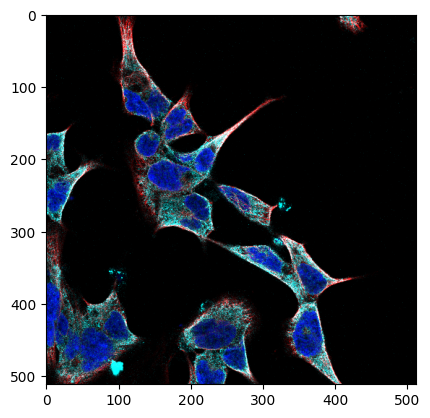

In [90]:
plt.imshow(combined_image)

In [93]:
# Загрузка изображения
print(sum(combined_image))
img_tensor = transform(combined_image)
img_tensor = img_tensor.unsqueeze(0)
# Ввод в модель
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    binary_outputs = torch.round(torch.sigmoid(outputs))
    

print(f'Предсказанный класс: {torch.sigmoid(outputs)}')

[[151  57 182]
 [ 38 114 125]
 [206  90 245]
 ...
 [  3 189 207]
 [  4  75  78]
 [  1  68  72]]
Предсказанный класс: tensor([[0.4952, 0.4998, 0.5002, 0.5000, 0.5021, 0.4967, 0.4958, 0.5008, 0.4970,
         0.4998]])


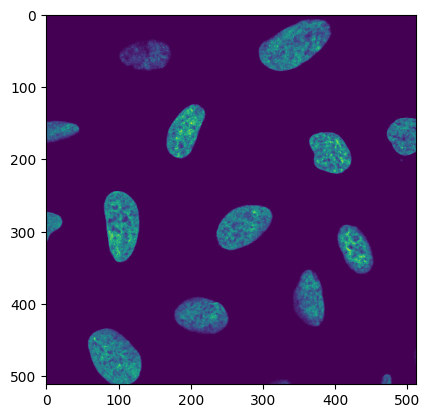

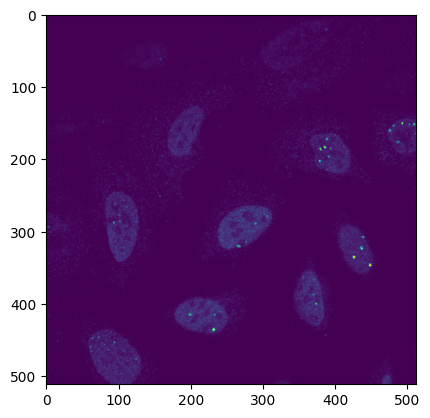

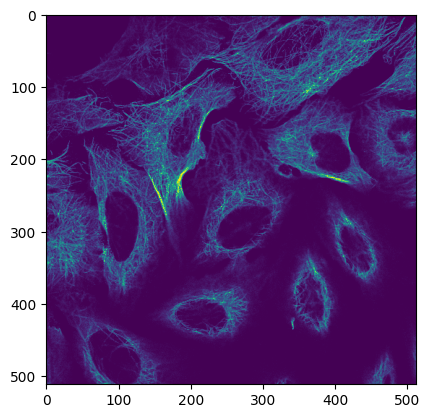

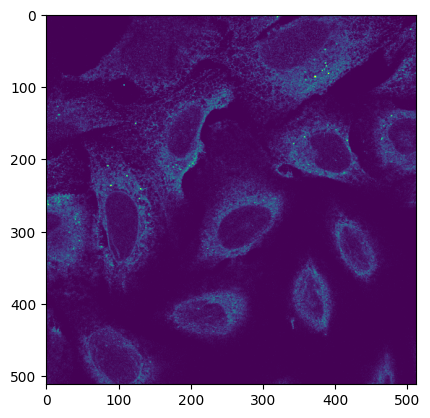

In [51]:
img_name = '0e962068-bbc8-11e8-b2bc-ac1f6b6435d0'
spisok = ['_blue','_green','_red','_yellow']
for c in spisok:
    imger = cv2.imread(f'train/{img_name}{c}.png', cv2.BORDER_DEFAULT)
    plt.imshow(imger)
    plt.show()

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])]


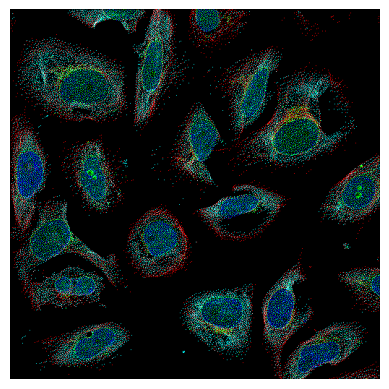

In [55]:
img_name = '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0'
spisok = ['_blue', '_green', '_red', '_yellow']
rgb_images = []
        # Итерация по списку цветов
for number, c in enumerate(spisok):
    imger = Image.open(f'train/{img_name}{c}.png')
    imger = imger.convert('1')
    gray_image = np.array(imger)
    gray_image = gray_image.astype(int) * 255
            
            # Создаем новый массив с 3 слоями
    rgb_image = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)
            # Заполнение каналов RGB
    rgb_image[..., 0] = gray_image * (number == 2 or number == 3)  # Красный (2 и 3)
    rgb_image[..., 1] = gray_image * (number == 1 or number == 3)  # Зеленый (1 и 3)
    rgb_image[..., 2] = gray_image * (number == 0)  # Синий (0)
    rgb_images.append(gray_image)
    
combined_rgb_images = np.concatenate(rgb_images, axis=1)

rgb_images[1] = np.maximum(rgb_images[1], rgb_images[3])
rgb_images[0] = np.maximum(rgb_images[0], rgb_images[3])
# Объединяем слои в одну RGB-картину
combined_image = np.stack((rgb_images[2], rgb_images[1], rgb_images[0]), axis=-1) # 1: red 2: green 3: blue


print(rgb_images)
plt.imshow(combined_image)
plt.axis('off')  # Убираем оси
plt.show()

In [ ]:
for c in rgb_images:
    plt.imshow(c)
    plt.axis('off')  # Убираем оси
    plt.show()

In [ ]:
# def filter_classes(classes):
#     # Преобразование строки в список целых чисел
#     class_list = list(map(int, classes.split()))
#     # Проверка, не содержит ли список значений больше 10
#     return all(0 <= c <= 10 for c in class_list)

# # Применяем фильтрацию
# filtered_df = df[df['Target'].apply(filter_classes)]

# filtered_df.to_csv('filtered_classes.csv', index=False)

# print(len(filtered_df.values))
# # Результат
# # print(list(map(int, df.split())))

In [49]:
# Предсказанные логиты
logits = torch.tensor([[1, 0, 1],
                       [0, 1, 0],
                       [1., 1, 1],
                       [0, 0, 1]])

# Пример меток (бинарный вектор с наличием классов)
labels = torch.tensor([[1, 0, 1],
                       [0, 1, 0],
                       [1, 1, 0],
                       [0, 0, 1]], dtype=torch.float)

# Инициализация функции потерь
criterion = nn.BCEWithLogitsLoss()

# Вычисление потерь
loss = criterion(logits, labels)
print('Loss:', loss.item())

# Применение сигмоиды к логитам
probabilities = torch.sigmoid(logits)
print(probabilities)
# Установим порог для предсказания 
threshold = 0.5
predictions = (probabilities > threshold).float()

# Вычисление accuracy
correct = (predictions == labels).sum().item()  # количество правильных предсказаний
total = labels.numel()                            # общее количество классов
accuracy = correct / total                        # accuracy

print('Accuracy:', accuracy)

Loss: 0.5548806190490723
tensor([[0.7311, 0.5000, 0.7311],
        [0.5000, 0.7311, 0.5000],
        [0.7311, 0.7311, 0.7311],
        [0.5000, 0.5000, 0.7311]])
Accuracy: 0.9166666666666666
